In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

# interp1, 2 are the parameter values, starting from 0
interp1 = 4 # in reality, param no. interp1+1
interp2 = 5 # in reality, param no. interp2+1


n_epochs = 100000
n_epochs_latent=200
batch_size = 20
LR = 3e-5
Lv1_latent_dim = 128
Lv2_latent_dim = 64

alpha = 0

In [10]:
f = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    temp = np.loadtxt(filename3)
    f[i,:,:] = np.loadtxt(filename3)

In [11]:
f.shape

(10, 200, 128)

## Scale latent codes from Lv 1.

In [12]:
maximum = np.amax(f)
minimum = np.amin(f)
mean = np.mean(f)
AT = maximum-minimum

f = f-mean
f = f/AT*2

In [13]:
print(np.max(f))
print(np.min(f))

1.0399307454674085
-0.9600692545325914


# Level 2, TVAE (Temporal VAE)

In [14]:
# Lv2_input = (num_param, num_time, Lv1 latent vector dim)

Lv2_input = f
Lv2_input.shape

(10, 200, 128)

In [15]:
#validate

Lv2_input_shape_decoder = Lv2_input.shape[1]

In [16]:
Lv2_input_shape = Lv2_input.shape[1:]

In [17]:
print(Lv2_input.shape)
print(Lv2_input_shape)

(10, 200, 128)
(200, 128)


# Encoder

In [18]:
def encoder():
    x_input=layers.Input(shape=Lv2_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    
    mu=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    eps = tf.random.normal(shape=[Lv2_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [mu, var, z], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 128)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 204, 128)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 204, 256)     164096      zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 204, 256)     1024        conv1d[0][0]                     
____________________________________________________________________________________________

# Decoder

In [19]:
print(Lv2_latent_dim)
print(Lv2_input_shape_decoder)

64
200


In [20]:
def decoder():
    z_input=layers.Input(shape=(Lv2_latent_dim))
    
    z=layers.Dense(Lv2_input_shape_decoder*Lv2_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv2_input_shape_decoder,Lv2_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
       
    de_coder = tf.keras.models.Model(z_input, [mu_prime, var_prime], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12800)        832000      input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 12800)        0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 200, 64)      0           leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

# loss computation

In [21]:
def compute_loss(mu, var, mu_prime, var_prime, real_img, beta):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum((0.5*tf.math.log(var_prime) + tf.math.square(real_img - mu_prime)/(2*var_prime)), 1))
    
    KL_divergence = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((tf.math.square(mu) + var - tf.math.log(var) - 1), 1))
    
    VAE_loss = reconstruction_error + beta * KL_divergence # L(X0)+L(X1)+L(X2)
    
    mu_a = mu[1:num_param-1,:]
    mu_b = (mu[0:num_param-2,:]+mu[2:num_param,:])/2
    var_a = var[1:num_param-1,:]
    var_b = (var[0:num_param-2,:]+var[2:num_param,:])/4

    loss_constraint = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((var_a/var_b + tf.math.square(mu_b - mu_a)/var_b - 1 + tf.math.log(var_b/var_a)),1))
    
    loss = VAE_loss + alpha * loss_constraint
    
    return loss

# VAE

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(real_img, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            mu, var, latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            mu_prime, var_prime = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(mu, var, mu_prime, var_prime, real_img, beta)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [23]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv2_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv2_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_Lv2/decoder_%d.h5' % (epoch+1)
                filename2 = 'test_constrained_Lv2/encoder_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [24]:
Lv2_input.shape
print(type(Lv2_input))

<class 'numpy.ndarray'>


# Warm up

In [25]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.999)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv2_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv2_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=compute_loss)

start = time.time()
vae.fit(Lv2_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/50003
1/1 [==============================] - 6s 6s/step - loss: 13.7623
Epoch 2/50003
1/1 [==============================] - 0s 22ms/step - loss: 13.4830
Epoch 3/50003
1/1 [==============================] - 0s 14ms/step - loss: 13.2466
Epoch 4/50003
1/1 [==============================] - 0s 22ms/step - loss: 13.5994
Epoch 5/50003
1/1 [==============================] - 0s 15ms/step - loss: 13.6742
Epoch 6/50003
1/1 [==============================] - 0s 16ms/step - loss: 13.1541
Epoch 7/50003
1/1 [==============================] - 0s 16ms/step - loss: 13.3451
Epoch 8/50003
1/1 [==============================] - 0s 16ms/step - loss: 13.4295
Epoch 9/50003
1/1 [==============================] - 0s 15ms/step - loss: 13.2558
Epoch 10/50003
1/1 [==============================] - 0s 16ms/step - loss: 12.8571
Epoch 11/50003
1/1 [==============================] - 0s 17ms/step - loss: 12.5680
Epoch 12/50003
1/1 [==============================] - 0s 15ms/step - loss: 12.9686
Epoch 13/50003


1/1 [==============================] - 0s 14ms/step - loss: -12.5320
Epoch 101/50003
1/1 [==============================] - 0s 22ms/step - loss: -12.4141
Epoch 102/50003
1/1 [==============================] - 0s 14ms/step - loss: -12.6979
Epoch 103/50003
1/1 [==============================] - 0s 18ms/step - loss: -13.2451
Epoch 104/50003
1/1 [==============================] - 0s 17ms/step - loss: -13.4076
Epoch 105/50003
1/1 [==============================] - 0s 14ms/step - loss: -13.4562
Epoch 106/50003
1/1 [==============================] - 0s 14ms/step - loss: -13.5056
Epoch 107/50003
1/1 [==============================] - 0s 13ms/step - loss: -13.9569
Epoch 108/50003
1/1 [==============================] - 0s 16ms/step - loss: -13.9798
Epoch 109/50003
1/1 [==============================] - 0s 17ms/step - loss: -14.1295
Epoch 110/50003
1/1 [==============================] - 0s 19ms/step - loss: -14.8031
Epoch 111/50003
1/1 [==============================] - 0s 18ms/step - loss: -14.7

1/1 [==============================] - 0s 19ms/step - loss: -31.0953
Epoch 293/50003
1/1 [==============================] - 0s 11ms/step - loss: -31.3086
Epoch 294/50003
1/1 [==============================] - 0s 15ms/step - loss: -31.1453
Epoch 295/50003
1/1 [==============================] - 0s 14ms/step - loss: -31.6354
Epoch 296/50003
1/1 [==============================] - 0s 12ms/step - loss: -31.6813
Epoch 297/50003
1/1 [==============================] - 0s 13ms/step - loss: -31.5235
Epoch 298/50003
1/1 [==============================] - 0s 15ms/step - loss: -31.6164
Epoch 299/50003
1/1 [==============================] - 0s 13ms/step - loss: -31.6531
Epoch 300/50003
1/1 [==============================] - 0s 15ms/step - loss: -31.9077
Epoch 301/50003
1/1 [==============================] - 0s 14ms/step - loss: -31.4864
Epoch 302/50003
1/1 [==============================] - 0s 17ms/step - loss: -31.8460
Epoch 303/50003
1/1 [==============================] - 0s 14ms/step - loss: -31.8

1/1 [==============================] - 0s 15ms/step - loss: -39.8948
Epoch 485/50003
1/1 [==============================] - 0s 13ms/step - loss: -39.9870
Epoch 486/50003
1/1 [==============================] - 0s 20ms/step - loss: -40.1070
Epoch 487/50003
1/1 [==============================] - 0s 19ms/step - loss: -40.1376
Epoch 488/50003
1/1 [==============================] - 0s 17ms/step - loss: -40.0632
Epoch 489/50003
1/1 [==============================] - 0s 15ms/step - loss: -40.0849
Epoch 490/50003
1/1 [==============================] - 0s 15ms/step - loss: -40.1157
Epoch 491/50003
1/1 [==============================] - 0s 15ms/step - loss: -40.3994
Epoch 492/50003
1/1 [==============================] - 0s 16ms/step - loss: -40.3714
Epoch 493/50003
1/1 [==============================] - 0s 12ms/step - loss: -40.3608
Epoch 494/50003
1/1 [==============================] - 0s 18ms/step - loss: -40.3386
Epoch 495/50003
1/1 [==============================] - 0s 17ms/step - loss: -40.4

1/1 [==============================] - 0s 16ms/step - loss: -49.2483
Epoch 677/50003
1/1 [==============================] - 0s 13ms/step - loss: -49.0432
Epoch 678/50003
1/1 [==============================] - 0s 19ms/step - loss: -49.2747
Epoch 679/50003
1/1 [==============================] - 0s 17ms/step - loss: -49.4966
Epoch 680/50003
1/1 [==============================] - 0s 16ms/step - loss: -49.2803
Epoch 681/50003
1/1 [==============================] - 0s 15ms/step - loss: -49.4968
Epoch 682/50003
1/1 [==============================] - 0s 19ms/step - loss: -49.5764
Epoch 683/50003
1/1 [==============================] - 0s 14ms/step - loss: -49.8133
Epoch 684/50003
1/1 [==============================] - 0s 14ms/step - loss: -49.7718
Epoch 685/50003
1/1 [==============================] - 0s 15ms/step - loss: -49.5139
Epoch 686/50003
1/1 [==============================] - 0s 19ms/step - loss: -49.7625
Epoch 687/50003
1/1 [==============================] - 0s 12ms/step - loss: -49.8

1/1 [==============================] - 0s 18ms/step - loss: -58.9571
Epoch 869/50003
1/1 [==============================] - 0s 16ms/step - loss: -59.0391
Epoch 870/50003
1/1 [==============================] - 0s 17ms/step - loss: -58.8719
Epoch 871/50003
1/1 [==============================] - 0s 12ms/step - loss: -58.7643
Epoch 872/50003
1/1 [==============================] - 0s 11ms/step - loss: -59.0108
Epoch 873/50003
1/1 [==============================] - 0s 14ms/step - loss: -59.2360
Epoch 874/50003
1/1 [==============================] - 0s 19ms/step - loss: -59.2613
Epoch 875/50003
1/1 [==============================] - 0s 20ms/step - loss: -59.1831
Epoch 876/50003
1/1 [==============================] - 0s 17ms/step - loss: -59.3034
Epoch 877/50003
1/1 [==============================] - 0s 16ms/step - loss: -59.3004
Epoch 878/50003
1/1 [==============================] - 0s 13ms/step - loss: -59.4481
Epoch 879/50003
1/1 [==============================] - 0s 14ms/step - loss: -59.2

1/1 [==============================] - 0s 14ms/step - loss: -68.4620
Epoch 1056/50003
1/1 [==============================] - 0s 18ms/step - loss: -68.6689
Epoch 1057/50003
1/1 [==============================] - 0s 17ms/step - loss: -68.6272
Epoch 1058/50003
1/1 [==============================] - 0s 14ms/step - loss: -68.8583
Epoch 1059/50003
1/1 [==============================] - 0s 13ms/step - loss: -69.2974
Epoch 1060/50003
1/1 [==============================] - 0s 17ms/step - loss: -69.1285
Epoch 1061/50003
1/1 [==============================] - 0s 12ms/step - loss: -68.9900
Epoch 1062/50003
1/1 [==============================] - 0s 17ms/step - loss: -69.0890
Epoch 1063/50003
1/1 [==============================] - 0s 18ms/step - loss: -69.4886
Epoch 1064/50003
1/1 [==============================] - 0s 15ms/step - loss: -69.4389
Epoch 1065/50003
1/1 [==============================] - 0s 12ms/step - loss: -69.3229
Epoch 1066/50003
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 19ms/step - loss: -79.4837
Epoch 1246/50003
1/1 [==============================] - 0s 20ms/step - loss: -79.1191
Epoch 1247/50003
1/1 [==============================] - 0s 14ms/step - loss: -79.8025
Epoch 1248/50003
1/1 [==============================] - 0s 15ms/step - loss: -79.9236
Epoch 1249/50003
1/1 [==============================] - 0s 14ms/step - loss: -79.3344
Epoch 1250/50003
1/1 [==============================] - 0s 18ms/step - loss: -80.2603
Epoch 1251/50003
1/1 [==============================] - 0s 16ms/step - loss: -79.6990
Epoch 1252/50003
1/1 [==============================] - 0s 17ms/step - loss: -79.8697
Epoch 1253/50003
1/1 [==============================] - 0s 14ms/step - loss: -80.4634
Epoch 1254/50003
1/1 [==============================] - 0s 14ms/step - loss: -79.7345
Epoch 1255/50003
1/1 [==============================] - 0s 19ms/step - loss: -80.7592
Epoch 1256/50003
1/1 [==============================] - 0s 19ms/step - 

1/1 [==============================] - 0s 15ms/step - loss: -90.6853
Epoch 1436/50003
1/1 [==============================] - 0s 18ms/step - loss: -91.2165
Epoch 1437/50003
1/1 [==============================] - 0s 15ms/step - loss: -91.1633
Epoch 1438/50003
1/1 [==============================] - 0s 13ms/step - loss: -90.6302
Epoch 1439/50003
1/1 [==============================] - 0s 18ms/step - loss: -91.3820
Epoch 1440/50003
1/1 [==============================] - 0s 19ms/step - loss: -91.8948
Epoch 1441/50003
1/1 [==============================] - 0s 15ms/step - loss: -91.2961
Epoch 1442/50003
1/1 [==============================] - 0s 13ms/step - loss: -91.5117
Epoch 1443/50003
1/1 [==============================] - 0s 16ms/step - loss: -91.7473
Epoch 1444/50003
1/1 [==============================] - 0s 21ms/step - loss: -91.3800
Epoch 1445/50003
1/1 [==============================] - 0s 14ms/step - loss: -91.9874
Epoch 1446/50003
1/1 [==============================] - 0s 14ms/step - 

1/1 [==============================] - 0s 13ms/step - loss: -102.8931
Epoch 1625/50003
1/1 [==============================] - 0s 14ms/step - loss: -102.8798
Epoch 1626/50003
1/1 [==============================] - 0s 13ms/step - loss: -102.8608
Epoch 1627/50003
1/1 [==============================] - 0s 17ms/step - loss: -103.8016
Epoch 1628/50003
1/1 [==============================] - 0s 15ms/step - loss: -103.3121
Epoch 1629/50003
1/1 [==============================] - 0s 12ms/step - loss: -103.6817
Epoch 1630/50003
1/1 [==============================] - 0s 14ms/step - loss: -103.6487
Epoch 1631/50003
1/1 [==============================] - 0s 12ms/step - loss: -103.5162
Epoch 1632/50003
1/1 [==============================] - 0s 15ms/step - loss: -103.8036
Epoch 1633/50003
1/1 [==============================] - 0s 12ms/step - loss: -103.3801
Epoch 1634/50003
1/1 [==============================] - 0s 13ms/step - loss: -103.6792
Epoch 1635/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - loss: -114.6790
Epoch 1813/50003
1/1 [==============================] - 0s 17ms/step - loss: -115.0066
Epoch 1814/50003
1/1 [==============================] - 0s 17ms/step - loss: -115.7615
Epoch 1815/50003
1/1 [==============================] - 0s 15ms/step - loss: -115.2577
Epoch 1816/50003
1/1 [==============================] - 0s 17ms/step - loss: -115.2405
Epoch 1817/50003
1/1 [==============================] - 0s 14ms/step - loss: -115.9538
Epoch 1818/50003
1/1 [==============================] - 0s 18ms/step - loss: -115.9138
Epoch 1819/50003
1/1 [==============================] - 0s 16ms/step - loss: -116.1087
Epoch 1820/50003
1/1 [==============================] - 0s 16ms/step - loss: -115.4902
Epoch 1821/50003
1/1 [==============================] - 0s 12ms/step - loss: -115.9936
Epoch 1822/50003
1/1 [==============================] - 0s 21ms/step - loss: -116.1729
Epoch 1823/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: -127.7661
Epoch 2001/50003
1/1 [==============================] - 0s 15ms/step - loss: -128.1997
Epoch 2002/50003
1/1 [==============================] - 0s 13ms/step - loss: -127.6135
Epoch 2003/50003
1/1 [==============================] - 0s 16ms/step - loss: -127.9135
Epoch 2004/50003
1/1 [==============================] - 0s 18ms/step - loss: -127.7592
Epoch 2005/50003
1/1 [==============================] - 0s 13ms/step - loss: -127.6810
Epoch 2006/50003
1/1 [==============================] - 0s 14ms/step - loss: -128.2572
Epoch 2007/50003
1/1 [==============================] - 0s 16ms/step - loss: -128.1041
Epoch 2008/50003
1/1 [==============================] - 0s 16ms/step - loss: -127.8849
Epoch 2009/50003
1/1 [==============================] - 0s 15ms/step - loss: -127.8448
Epoch 2010/50003
1/1 [==============================] - 0s 18ms/step - loss: -128.7245
Epoch 2011/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - loss: -139.9421
Epoch 2185/50003
1/1 [==============================] - 0s 18ms/step - loss: -139.5351
Epoch 2186/50003
1/1 [==============================] - 0s 19ms/step - loss: -139.8932
Epoch 2187/50003
1/1 [==============================] - 0s 14ms/step - loss: -140.2760
Epoch 2188/50003
1/1 [==============================] - 0s 17ms/step - loss: -140.2386
Epoch 2189/50003
1/1 [==============================] - 0s 13ms/step - loss: -139.9437
Epoch 2190/50003
1/1 [==============================] - 0s 15ms/step - loss: -140.2411
Epoch 2191/50003
1/1 [==============================] - 0s 18ms/step - loss: -140.6684
Epoch 2192/50003
1/1 [==============================] - 0s 16ms/step - loss: -140.1118
Epoch 2193/50003
1/1 [==============================] - 0s 14ms/step - loss: -140.3724
Epoch 2194/50003
1/1 [==============================] - 0s 16ms/step - loss: -140.3834
Epoch 2195/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step - loss: -152.4011
Epoch 2373/50003
1/1 [==============================] - 0s 17ms/step - loss: -152.2045
Epoch 2374/50003
1/1 [==============================] - 0s 14ms/step - loss: -152.1792
Epoch 2375/50003
1/1 [==============================] - 0s 16ms/step - loss: -152.6905
Epoch 2376/50003
1/1 [==============================] - 0s 18ms/step - loss: -151.7485
Epoch 2377/50003
1/1 [==============================] - 0s 16ms/step - loss: -152.7577
Epoch 2378/50003
1/1 [==============================] - 0s 17ms/step - loss: -152.2130
Epoch 2379/50003
1/1 [==============================] - 0s 17ms/step - loss: -152.6667
Epoch 2380/50003
1/1 [==============================] - 0s 18ms/step - loss: -152.2304
Epoch 2381/50003
1/1 [==============================] - 0s 20ms/step - loss: -153.0648
Epoch 2382/50003
1/1 [==============================] - 0s 16ms/step - loss: -152.7803
Epoch 2383/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: -163.8817
Epoch 2561/50003
1/1 [==============================] - 0s 13ms/step - loss: -164.5596
Epoch 2562/50003
1/1 [==============================] - 0s 17ms/step - loss: -164.7488
Epoch 2563/50003
1/1 [==============================] - 0s 13ms/step - loss: -164.6037
Epoch 2564/50003
1/1 [==============================] - 0s 15ms/step - loss: -164.7926
Epoch 2565/50003
1/1 [==============================] - 0s 20ms/step - loss: -164.7989
Epoch 2566/50003
1/1 [==============================] - 0s 15ms/step - loss: -164.9440
Epoch 2567/50003
1/1 [==============================] - 0s 12ms/step - loss: -164.9842
Epoch 2568/50003
1/1 [==============================] - 0s 15ms/step - loss: -165.2434
Epoch 2569/50003
1/1 [==============================] - 0s 13ms/step - loss: -165.5535
Epoch 2570/50003
1/1 [==============================] - 0s 18ms/step - loss: -165.1422
Epoch 2571/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -176.4155
Epoch 2749/50003
1/1 [==============================] - 0s 16ms/step - loss: -176.6259
Epoch 2750/50003
1/1 [==============================] - 0s 17ms/step - loss: -176.9903
Epoch 2751/50003
1/1 [==============================] - ETA: 0s - loss: -176.47 - 0s 13ms/step - loss: -176.4795
Epoch 2752/50003
1/1 [==============================] - 0s 20ms/step - loss: -176.8634
Epoch 2753/50003
1/1 [==============================] - 0s 16ms/step - loss: -177.1669
Epoch 2754/50003
1/1 [==============================] - 0s 17ms/step - loss: -177.1826
Epoch 2755/50003
1/1 [==============================] - 0s 13ms/step - loss: -177.1112
Epoch 2756/50003
1/1 [==============================] - 0s 13ms/step - loss: -177.6093
Epoch 2757/50003
1/1 [==============================] - 0s 19ms/step - loss: -177.3630
Epoch 2758/50003
1/1 [==============================] - 0s 16ms/step - loss: -177.1060
Epoch 2759/50003
1/1 [============

1/1 [==============================] - 0s 16ms/step - loss: -182.5950
Epoch 2843/50003
1/1 [==============================] - 0s 20ms/step - loss: -182.9674
Epoch 2844/50003
1/1 [==============================] - 0s 18ms/step - loss: -182.9059
Epoch 2845/50003
1/1 [==============================] - 0s 17ms/step - loss: -183.0810
Epoch 2846/50003
1/1 [==============================] - 0s 15ms/step - loss: -183.6198
Epoch 2847/50003
1/1 [==============================] - 0s 13ms/step - loss: -183.2918
Epoch 2848/50003
1/1 [==============================] - 0s 19ms/step - loss: -182.8525
Epoch 2849/50003
1/1 [==============================] - 0s 13ms/step - loss: -183.6068
Epoch 2850/50003
1/1 [==============================] - 0s 16ms/step - loss: -182.7076
Epoch 2851/50003
1/1 [==============================] - 0s 13ms/step - loss: -183.9438
Epoch 2852/50003
1/1 [==============================] - 0s 11ms/step - loss: -183.5583
Epoch 2853/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 17ms/step - loss: -194.4165
Epoch 3027/50003
1/1 [==============================] - 0s 13ms/step - loss: -194.0816
Epoch 3028/50003
1/1 [==============================] - 0s 15ms/step - loss: -194.8793
Epoch 3029/50003
1/1 [==============================] - 0s 15ms/step - loss: -193.8843
Epoch 3030/50003
1/1 [==============================] - 0s 17ms/step - loss: -193.7013
Epoch 3031/50003
1/1 [==============================] - 0s 17ms/step - loss: -194.1695
Epoch 3032/50003
1/1 [==============================] - 0s 23ms/step - loss: -194.7914
Epoch 3033/50003
1/1 [==============================] - 0s 18ms/step - loss: -195.3757
Epoch 3034/50003
1/1 [==============================] - 0s 22ms/step - loss: -195.4052
Epoch 3035/50003
1/1 [==============================] - 0s 20ms/step - loss: -195.2233
Epoch 3036/50003
1/1 [==============================] - 0s 14ms/step - loss: -194.9580
Epoch 3037/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 17ms/step - loss: -206.4950
Epoch 3215/50003
1/1 [==============================] - 0s 18ms/step - loss: -206.8022
Epoch 3216/50003
1/1 [==============================] - 0s 21ms/step - loss: -207.0679
Epoch 3217/50003
1/1 [==============================] - 0s 14ms/step - loss: -206.1263
Epoch 3218/50003
1/1 [==============================] - 0s 14ms/step - loss: -206.3844
Epoch 3219/50003
1/1 [==============================] - 0s 18ms/step - loss: -206.6418
Epoch 3220/50003
1/1 [==============================] - 0s 15ms/step - loss: -206.2053
Epoch 3221/50003
1/1 [==============================] - 0s 17ms/step - loss: -206.2987
Epoch 3222/50003
1/1 [==============================] - 0s 16ms/step - loss: -206.1066
Epoch 3223/50003
1/1 [==============================] - 0s 13ms/step - loss: -207.2429
Epoch 3224/50003
1/1 [==============================] - 0s 18ms/step - loss: -206.7626
Epoch 3225/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: -216.6954
Epoch 3403/50003
1/1 [==============================] - 0s 16ms/step - loss: -217.5551
Epoch 3404/50003
1/1 [==============================] - 0s 13ms/step - loss: -218.8521
Epoch 3405/50003
1/1 [==============================] - 0s 13ms/step - loss: -218.3194
Epoch 3406/50003
1/1 [==============================] - 0s 13ms/step - loss: -217.6773
Epoch 3407/50003
1/1 [==============================] - 0s 17ms/step - loss: -218.3232
Epoch 3408/50003
1/1 [==============================] - 0s 18ms/step - loss: -218.8620
Epoch 3409/50003
1/1 [==============================] - 0s 17ms/step - loss: -218.8712
Epoch 3410/50003
1/1 [==============================] - 0s 18ms/step - loss: -218.1868
Epoch 3411/50003
1/1 [==============================] - 0s 11ms/step - loss: -218.4302
Epoch 3412/50003
1/1 [==============================] - 0s 14ms/step - loss: -218.2607
Epoch 3413/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - loss: -229.0437
Epoch 3591/50003
1/1 [==============================] - 0s 15ms/step - loss: -229.3766
Epoch 3592/50003
1/1 [==============================] - 0s 16ms/step - loss: -229.7123
Epoch 3593/50003
1/1 [==============================] - 0s 22ms/step - loss: -229.8714
Epoch 3594/50003
1/1 [==============================] - 0s 18ms/step - loss: -229.2414
Epoch 3595/50003
1/1 [==============================] - 0s 14ms/step - loss: -229.6480
Epoch 3596/50003
1/1 [==============================] - 0s 13ms/step - loss: -229.6309
Epoch 3597/50003
1/1 [==============================] - 0s 18ms/step - loss: -229.7954
Epoch 3598/50003
1/1 [==============================] - 0s 17ms/step - loss: -230.1505
Epoch 3599/50003
1/1 [==============================] - 0s 18ms/step - loss: -230.2604
Epoch 3600/50003
1/1 [==============================] - 0s 18ms/step - loss: -229.4236
Epoch 3601/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 22ms/step - loss: -240.6401
Epoch 3779/50003
1/1 [==============================] - 0s 16ms/step - loss: -240.7043
Epoch 3780/50003
1/1 [==============================] - 0s 18ms/step - loss: -239.5530
Epoch 3781/50003
1/1 [==============================] - 0s 15ms/step - loss: -241.8006
Epoch 3782/50003
1/1 [==============================] - 0s 17ms/step - loss: -241.6626
Epoch 3783/50003
1/1 [==============================] - 0s 14ms/step - loss: -240.9391
Epoch 3784/50003
1/1 [==============================] - 0s 18ms/step - loss: -240.6424
Epoch 3785/50003
1/1 [==============================] - 0s 19ms/step - loss: -240.8119
Epoch 3786/50003
1/1 [==============================] - 0s 19ms/step - loss: -240.8788
Epoch 3787/50003
1/1 [==============================] - 0s 21ms/step - loss: -240.7597
Epoch 3788/50003
1/1 [==============================] - 0s 20ms/step - loss: -241.0598
Epoch 3789/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step - loss: -250.4698
Epoch 3967/50003
1/1 [==============================] - 0s 13ms/step - loss: -251.2425
Epoch 3968/50003
1/1 [==============================] - 0s 15ms/step - loss: -250.9366
Epoch 3969/50003
1/1 [==============================] - 0s 17ms/step - loss: -251.3006
Epoch 3970/50003
1/1 [==============================] - 0s 17ms/step - loss: -251.0633
Epoch 3971/50003
1/1 [==============================] - 0s 14ms/step - loss: -251.0389
Epoch 3972/50003
1/1 [==============================] - 0s 15ms/step - loss: -250.9177
Epoch 3973/50003
1/1 [==============================] - 0s 18ms/step - loss: -251.4130
Epoch 3974/50003
1/1 [==============================] - 0s 18ms/step - loss: -250.8526
Epoch 3975/50003
1/1 [==============================] - 0s 19ms/step - loss: -250.8192
Epoch 3976/50003
1/1 [==============================] - 0s 12ms/step - loss: -251.9816
Epoch 3977/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: -258.6061
Epoch 4151/50003
1/1 [==============================] - 0s 19ms/step - loss: -258.6106
Epoch 4152/50003
1/1 [==============================] - 0s 13ms/step - loss: -260.2371
Epoch 4153/50003
1/1 [==============================] - 0s 17ms/step - loss: -258.2454
Epoch 4154/50003
1/1 [==============================] - 0s 12ms/step - loss: -260.4231
Epoch 4155/50003
1/1 [==============================] - 0s 17ms/step - loss: -259.0332
Epoch 4156/50003
1/1 [==============================] - 0s 14ms/step - loss: -259.8376
Epoch 4157/50003
1/1 [==============================] - 0s 21ms/step - loss: -259.8145
Epoch 4158/50003
1/1 [==============================] - 0s 18ms/step - loss: -260.3373
Epoch 4159/50003
1/1 [==============================] - 0s 19ms/step - loss: -260.0548
Epoch 4160/50003
1/1 [==============================] - 0s 19ms/step - loss: -258.9157
Epoch 4161/50003
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 15ms/step - loss: -268.6123
Epoch 4339/50003
1/1 [==============================] - 0s 16ms/step - loss: -268.3583
Epoch 4340/50003
1/1 [==============================] - 0s 17ms/step - loss: -269.6540
Epoch 4341/50003
1/1 [==============================] - 0s 16ms/step - loss: -268.3138
Epoch 4342/50003
1/1 [==============================] - 0s 16ms/step - loss: -269.3765
Epoch 4343/50003
1/1 [==============================] - 0s 17ms/step - loss: -268.5119
Epoch 4344/50003
1/1 [==============================] - 0s 15ms/step - loss: -269.1366
Epoch 4345/50003
1/1 [==============================] - 0s 15ms/step - loss: -269.3004
Epoch 4346/50003
1/1 [==============================] - 0s 14ms/step - loss: -269.4352
Epoch 4347/50003
1/1 [==============================] - 0s 16ms/step - loss: -269.2971
Epoch 4348/50003
1/1 [==============================] - 0s 14ms/step - loss: -269.4340
Epoch 4349/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step - loss: -277.6332
Epoch 4527/50003
1/1 [==============================] - 0s 19ms/step - loss: -278.1320
Epoch 4528/50003
1/1 [==============================] - 0s 14ms/step - loss: -278.0436
Epoch 4529/50003
1/1 [==============================] - 0s 13ms/step - loss: -279.2286
Epoch 4530/50003
1/1 [==============================] - 0s 19ms/step - loss: -279.0509
Epoch 4531/50003
1/1 [==============================] - 0s 17ms/step - loss: -278.2366
Epoch 4532/50003
1/1 [==============================] - 0s 21ms/step - loss: -278.8101
Epoch 4533/50003
1/1 [==============================] - 0s 19ms/step - loss: -278.0622
Epoch 4534/50003
1/1 [==============================] - 0s 19ms/step - loss: -278.5966
Epoch 4535/50003
1/1 [==============================] - 0s 15ms/step - loss: -278.3051
Epoch 4536/50003
1/1 [==============================] - 0s 18ms/step - loss: -277.8719
Epoch 4537/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -286.5837
Epoch 4715/50003
1/1 [==============================] - 0s 17ms/step - loss: -287.7622
Epoch 4716/50003
1/1 [==============================] - 0s 17ms/step - loss: -286.8024
Epoch 4717/50003
1/1 [==============================] - 0s 20ms/step - loss: -287.0401
Epoch 4718/50003
1/1 [==============================] - 0s 16ms/step - loss: -286.0866
Epoch 4719/50003
1/1 [==============================] - 0s 14ms/step - loss: -286.2545
Epoch 4720/50003
1/1 [==============================] - 0s 14ms/step - loss: -287.4199
Epoch 4721/50003
1/1 [==============================] - 0s 17ms/step - loss: -287.4312
Epoch 4722/50003
1/1 [==============================] - 0s 19ms/step - loss: -286.8493
Epoch 4723/50003
1/1 [==============================] - 0s 18ms/step - loss: -286.9092
Epoch 4724/50003
1/1 [==============================] - 0s 18ms/step - loss: -286.4726
Epoch 4725/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: -298.9331
Epoch 4903/50003
1/1 [==============================] - 0s 14ms/step - loss: -298.5565
Epoch 4904/50003
1/1 [==============================] - 0s 12ms/step - loss: -297.9309
Epoch 4905/50003
1/1 [==============================] - 0s 14ms/step - loss: -298.5690
Epoch 4906/50003
1/1 [==============================] - 0s 16ms/step - loss: -300.9264
Epoch 4907/50003
1/1 [==============================] - 0s 14ms/step - loss: -298.8018
Epoch 4908/50003
1/1 [==============================] - 0s 15ms/step - loss: -299.7080
Epoch 4909/50003
1/1 [==============================] - 0s 14ms/step - loss: -299.6459
Epoch 4910/50003
1/1 [==============================] - 0s 14ms/step - loss: -299.8995
Epoch 4911/50003
1/1 [==============================] - 0s 15ms/step - loss: -300.4880
Epoch 4912/50003
1/1 [==============================] - 0s 13ms/step - loss: -298.6326
Epoch 4913/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -307.0368
Epoch 5087/50003
1/1 [==============================] - 0s 14ms/step - loss: -306.0884
Epoch 5088/50003
1/1 [==============================] - 0s 16ms/step - loss: -307.2343
Epoch 5089/50003
1/1 [==============================] - 0s 18ms/step - loss: -306.8247
Epoch 5090/50003
1/1 [==============================] - 0s 14ms/step - loss: -307.4138
Epoch 5091/50003
1/1 [==============================] - 0s 19ms/step - loss: -307.1506
Epoch 5092/50003
1/1 [==============================] - 0s 12ms/step - loss: -306.4538
Epoch 5093/50003
1/1 [==============================] - 0s 15ms/step - loss: -307.2374
Epoch 5094/50003
1/1 [==============================] - 0s 14ms/step - loss: -307.2901
Epoch 5095/50003
1/1 [==============================] - 0s 16ms/step - loss: -306.9913
Epoch 5096/50003
1/1 [==============================] - 0s 14ms/step - loss: -306.5654
Epoch 5097/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: -311.9091
Epoch 5275/50003
1/1 [==============================] - 0s 14ms/step - loss: -314.9280
Epoch 5276/50003
1/1 [==============================] - 0s 18ms/step - loss: -314.2100
Epoch 5277/50003
1/1 [==============================] - 0s 19ms/step - loss: -313.7655
Epoch 5278/50003
1/1 [==============================] - 0s 19ms/step - loss: -313.7126
Epoch 5279/50003
1/1 [==============================] - 0s 18ms/step - loss: -314.6177
Epoch 5280/50003
1/1 [==============================] - 0s 18ms/step - loss: -314.3569
Epoch 5281/50003
1/1 [==============================] - 0s 16ms/step - loss: -314.2038
Epoch 5282/50003
1/1 [==============================] - 0s 14ms/step - loss: -312.5482
Epoch 5283/50003
1/1 [==============================] - 0s 18ms/step - loss: -313.7907
Epoch 5284/50003
1/1 [==============================] - 0s 16ms/step - loss: -314.2491
Epoch 5285/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 17ms/step - loss: -319.6359
Epoch 5463/50003
1/1 [==============================] - 0s 13ms/step - loss: -318.2173
Epoch 5464/50003
1/1 [==============================] - 0s 16ms/step - loss: -318.5051
Epoch 5465/50003
1/1 [==============================] - 0s 12ms/step - loss: -318.2219
Epoch 5466/50003
1/1 [==============================] - 0s 12ms/step - loss: -320.7351
Epoch 5467/50003
1/1 [==============================] - 0s 15ms/step - loss: -318.5985
Epoch 5468/50003
1/1 [==============================] - 0s 16ms/step - loss: -320.2289
Epoch 5469/50003
1/1 [==============================] - 0s 15ms/step - loss: -320.1685
Epoch 5470/50003
1/1 [==============================] - 0s 14ms/step - loss: -318.7428
Epoch 5471/50003
1/1 [==============================] - 0s 14ms/step - loss: -320.0387
Epoch 5472/50003
1/1 [==============================] - 0s 13ms/step - loss: -318.7960
Epoch 5473/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step - loss: -322.1324
Epoch 5651/50003
1/1 [==============================] - 0s 17ms/step - loss: -322.6873
Epoch 5652/50003
1/1 [==============================] - 0s 16ms/step - loss: -323.9523
Epoch 5653/50003
1/1 [==============================] - 0s 14ms/step - loss: -322.1527
Epoch 5654/50003
1/1 [==============================] - 0s 12ms/step - loss: -323.4208
Epoch 5655/50003
1/1 [==============================] - 0s 17ms/step - loss: -322.5450
Epoch 5656/50003
1/1 [==============================] - 0s 16ms/step - loss: -323.0518
Epoch 5657/50003
1/1 [==============================] - 0s 14ms/step - loss: -322.9265
Epoch 5658/50003
1/1 [==============================] - 0s 18ms/step - loss: -322.8821
Epoch 5659/50003
1/1 [==============================] - 0s 15ms/step - loss: -322.9978
Epoch 5660/50003
1/1 [==============================] - 0s 15ms/step - loss: -323.0123
Epoch 5661/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 17ms/step - loss: -325.2086
Epoch 5839/50003
1/1 [==============================] - 0s 16ms/step - loss: -326.1674
Epoch 5840/50003
1/1 [==============================] - 0s 17ms/step - loss: -325.0043
Epoch 5841/50003
1/1 [==============================] - 0s 18ms/step - loss: -325.4078
Epoch 5842/50003
1/1 [==============================] - 0s 16ms/step - loss: -325.8795
Epoch 5843/50003
1/1 [==============================] - 0s 15ms/step - loss: -324.9958
Epoch 5844/50003
1/1 [==============================] - 0s 18ms/step - loss: -324.4021
Epoch 5845/50003
1/1 [==============================] - 0s 18ms/step - loss: -324.1183
Epoch 5846/50003
1/1 [==============================] - 0s 16ms/step - loss: -324.0087
Epoch 5847/50003
1/1 [==============================] - 0s 16ms/step - loss: -324.1281
Epoch 5848/50003
1/1 [==============================] - 0s 20ms/step - loss: -325.9305
Epoch 5849/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -326.9965
Epoch 6023/50003
1/1 [==============================] - 0s 15ms/step - loss: -326.9337
Epoch 6024/50003
1/1 [==============================] - 0s 17ms/step - loss: -326.5977
Epoch 6025/50003
1/1 [==============================] - 0s 13ms/step - loss: -327.1910
Epoch 6026/50003
1/1 [==============================] - 0s 17ms/step - loss: -325.9074
Epoch 6027/50003
1/1 [==============================] - 0s 14ms/step - loss: -329.1411
Epoch 6028/50003
1/1 [==============================] - 0s 16ms/step - loss: -326.1191
Epoch 6029/50003
1/1 [==============================] - 0s 15ms/step - loss: -326.9228
Epoch 6030/50003
1/1 [==============================] - 0s 15ms/step - loss: -327.6164
Epoch 6031/50003
1/1 [==============================] - 0s 16ms/step - loss: -327.9824
Epoch 6032/50003
1/1 [==============================] - 0s 16ms/step - loss: -326.5221
Epoch 6033/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - loss: -328.8116
Epoch 6211/50003
1/1 [==============================] - 0s 13ms/step - loss: -328.9240
Epoch 6212/50003
1/1 [==============================] - 0s 15ms/step - loss: -328.7780
Epoch 6213/50003
1/1 [==============================] - 0s 16ms/step - loss: -327.8783
Epoch 6214/50003
1/1 [==============================] - 0s 21ms/step - loss: -328.7374
Epoch 6215/50003
1/1 [==============================] - 0s 13ms/step - loss: -328.7698
Epoch 6216/50003
1/1 [==============================] - 0s 15ms/step - loss: -329.2290
Epoch 6217/50003
1/1 [==============================] - 0s 17ms/step - loss: -328.3347
Epoch 6218/50003
1/1 [==============================] - 0s 18ms/step - loss: -327.7872
Epoch 6219/50003
1/1 [==============================] - 0s 12ms/step - loss: -329.9286
Epoch 6220/50003
1/1 [==============================] - 0s 15ms/step - loss: -329.2578
Epoch 6221/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: -330.0843
Epoch 6399/50003
1/1 [==============================] - 0s 15ms/step - loss: -330.5043
Epoch 6400/50003
1/1 [==============================] - 0s 14ms/step - loss: -331.5575
Epoch 6401/50003
1/1 [==============================] - 0s 11ms/step - loss: -329.5192
Epoch 6402/50003
1/1 [==============================] - 0s 14ms/step - loss: -330.6537
Epoch 6403/50003
1/1 [==============================] - 0s 18ms/step - loss: -330.6744
Epoch 6404/50003
1/1 [==============================] - 0s 22ms/step - loss: -330.6539
Epoch 6405/50003
1/1 [==============================] - 0s 16ms/step - loss: -330.3603
Epoch 6406/50003
1/1 [==============================] - 0s 16ms/step - loss: -330.3330
Epoch 6407/50003
1/1 [==============================] - 0s 14ms/step - loss: -330.1551
Epoch 6408/50003
1/1 [==============================] - 0s 15ms/step - loss: -331.3817
Epoch 6409/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: -333.0633
Epoch 6587/50003
1/1 [==============================] - 0s 13ms/step - loss: -332.9334
Epoch 6588/50003
1/1 [==============================] - 0s 17ms/step - loss: -330.7311
Epoch 6589/50003
1/1 [==============================] - 0s 12ms/step - loss: -331.5055
Epoch 6590/50003
1/1 [==============================] - 0s 15ms/step - loss: -331.9196
Epoch 6591/50003
1/1 [==============================] - 0s 16ms/step - loss: -332.4952
Epoch 6592/50003
1/1 [==============================] - 0s 17ms/step - loss: -331.6633
Epoch 6593/50003
1/1 [==============================] - 0s 17ms/step - loss: -333.7784
Epoch 6594/50003
1/1 [==============================] - 0s 18ms/step - loss: -332.8019
Epoch 6595/50003
1/1 [==============================] - 0s 21ms/step - loss: -332.3658
Epoch 6596/50003
1/1 [==============================] - 0s 15ms/step - loss: -333.4217
Epoch 6597/50003
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 15ms/step - loss: -331.9553
Epoch 6775/50003
1/1 [==============================] - 0s 14ms/step - loss: -333.9121
Epoch 6776/50003
1/1 [==============================] - 0s 16ms/step - loss: -331.7740
Epoch 6777/50003
1/1 [==============================] - 0s 16ms/step - loss: -333.3863
Epoch 6778/50003
1/1 [==============================] - 0s 11ms/step - loss: -334.4529
Epoch 6779/50003
1/1 [==============================] - 0s 15ms/step - loss: -333.0207
Epoch 6780/50003
1/1 [==============================] - 0s 16ms/step - loss: -334.0398
Epoch 6781/50003
1/1 [==============================] - 0s 18ms/step - loss: -334.4527
Epoch 6782/50003
1/1 [==============================] - 0s 14ms/step - loss: -333.3342
Epoch 6783/50003
1/1 [==============================] - 0s 13ms/step - loss: -334.9447
Epoch 6784/50003
1/1 [==============================] - 0s 17ms/step - loss: -333.8087
Epoch 6785/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -335.1300
Epoch 6963/50003
1/1 [==============================] - 0s 18ms/step - loss: -334.7388
Epoch 6964/50003
1/1 [==============================] - 0s 19ms/step - loss: -336.6552
Epoch 6965/50003
1/1 [==============================] - 0s 15ms/step - loss: -334.5703
Epoch 6966/50003
1/1 [==============================] - 0s 18ms/step - loss: -334.2525
Epoch 6967/50003
1/1 [==============================] - 0s 18ms/step - loss: -335.2720
Epoch 6968/50003
1/1 [==============================] - 0s 21ms/step - loss: -335.9406
Epoch 6969/50003
1/1 [==============================] - 0s 13ms/step - loss: -336.4741
Epoch 6970/50003
1/1 [==============================] - 0s 12ms/step - loss: -335.1249
Epoch 6971/50003
1/1 [==============================] - 0s 18ms/step - loss: -334.9752
Epoch 6972/50003
1/1 [==============================] - 0s 18ms/step - loss: -335.4225
Epoch 6973/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: -336.1786
Epoch 7147/50003
1/1 [==============================] - 0s 13ms/step - loss: -337.6471
Epoch 7148/50003
1/1 [==============================] - 0s 14ms/step - loss: -335.1222
Epoch 7149/50003
1/1 [==============================] - 0s 14ms/step - loss: -337.0017
Epoch 7150/50003
1/1 [==============================] - 0s 15ms/step - loss: -336.8666
Epoch 7151/50003
1/1 [==============================] - 0s 15ms/step - loss: -336.5352
Epoch 7152/50003
1/1 [==============================] - 0s 14ms/step - loss: -336.7632
Epoch 7153/50003
1/1 [==============================] - 0s 17ms/step - loss: -336.4305
Epoch 7154/50003
1/1 [==============================] - 0s 17ms/step - loss: -336.8711
Epoch 7155/50003
1/1 [==============================] - 0s 14ms/step - loss: -336.9408
Epoch 7156/50003
1/1 [==============================] - 0s 17ms/step - loss: -335.4930
Epoch 7157/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -339.3353
Epoch 7335/50003
1/1 [==============================] - 0s 16ms/step - loss: -338.6428
Epoch 7336/50003
1/1 [==============================] - 0s 14ms/step - loss: -338.2670
Epoch 7337/50003
1/1 [==============================] - 0s 15ms/step - loss: -337.8467
Epoch 7338/50003
1/1 [==============================] - 0s 16ms/step - loss: -336.0496
Epoch 7339/50003
1/1 [==============================] - 0s 16ms/step - loss: -337.4030
Epoch 7340/50003
1/1 [==============================] - 0s 16ms/step - loss: -337.9371
Epoch 7341/50003
1/1 [==============================] - 0s 13ms/step - loss: -336.1278
Epoch 7342/50003
1/1 [==============================] - 0s 12ms/step - loss: -336.1143
Epoch 7343/50003
1/1 [==============================] - 0s 17ms/step - loss: -337.9545
Epoch 7344/50003
1/1 [==============================] - 0s 13ms/step - loss: -337.6208
Epoch 7345/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step - loss: -338.9123
Epoch 7523/50003
1/1 [==============================] - 0s 16ms/step - loss: -338.8430
Epoch 7524/50003
1/1 [==============================] - 0s 15ms/step - loss: -337.4837
Epoch 7525/50003
1/1 [==============================] - 0s 14ms/step - loss: -337.7867
Epoch 7526/50003
1/1 [==============================] - 0s 13ms/step - loss: -338.3209
Epoch 7527/50003
1/1 [==============================] - 0s 16ms/step - loss: -337.6593
Epoch 7528/50003
1/1 [==============================] - 0s 16ms/step - loss: -337.4664
Epoch 7529/50003
1/1 [==============================] - 0s 17ms/step - loss: -338.9522
Epoch 7530/50003
1/1 [==============================] - 0s 13ms/step - loss: -338.7050
Epoch 7531/50003
1/1 [==============================] - 0s 18ms/step - loss: -339.9210
Epoch 7532/50003
1/1 [==============================] - 0s 14ms/step - loss: -338.7317
Epoch 7533/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -339.2029
Epoch 7711/50003
1/1 [==============================] - 0s 16ms/step - loss: -339.5345
Epoch 7712/50003
1/1 [==============================] - 0s 17ms/step - loss: -339.4165
Epoch 7713/50003
1/1 [==============================] - 0s 21ms/step - loss: -340.6441
Epoch 7714/50003
1/1 [==============================] - 0s 19ms/step - loss: -338.6180
Epoch 7715/50003
1/1 [==============================] - 0s 16ms/step - loss: -339.1238
Epoch 7716/50003
1/1 [==============================] - 0s 15ms/step - loss: -339.7962
Epoch 7717/50003
1/1 [==============================] - 0s 15ms/step - loss: -340.1022
Epoch 7718/50003
1/1 [==============================] - 0s 15ms/step - loss: -340.6554
Epoch 7719/50003
1/1 [==============================] - 0s 13ms/step - loss: -341.4668
Epoch 7720/50003
1/1 [==============================] - 0s 15ms/step - loss: -340.5378
Epoch 7721/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - loss: -341.4873
Epoch 7899/50003
1/1 [==============================] - 0s 14ms/step - loss: -341.6413
Epoch 7900/50003
1/1 [==============================] - 0s 16ms/step - loss: -339.8691
Epoch 7901/50003
1/1 [==============================] - 0s 16ms/step - loss: -340.9056
Epoch 7902/50003
1/1 [==============================] - 0s 13ms/step - loss: -340.1894
Epoch 7903/50003
1/1 [==============================] - 0s 13ms/step - loss: -341.5028
Epoch 7904/50003
1/1 [==============================] - 0s 19ms/step - loss: -341.0425
Epoch 7905/50003
1/1 [==============================] - 0s 12ms/step - loss: -339.6346
Epoch 7906/50003
1/1 [==============================] - 0s 15ms/step - loss: -340.1885
Epoch 7907/50003
1/1 [==============================] - 0s 15ms/step - loss: -343.1256
Epoch 7908/50003
1/1 [==============================] - 0s 14ms/step - loss: -340.8477
Epoch 7909/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: -341.8502
Epoch 8083/50003
1/1 [==============================] - 0s 15ms/step - loss: -342.3643
Epoch 8084/50003
1/1 [==============================] - 0s 14ms/step - loss: -341.2618
Epoch 8085/50003
1/1 [==============================] - 0s 17ms/step - loss: -342.6479
Epoch 8086/50003
1/1 [==============================] - 0s 14ms/step - loss: -342.7399
Epoch 8087/50003
1/1 [==============================] - 0s 15ms/step - loss: -340.2318
Epoch 8088/50003
1/1 [==============================] - 0s 14ms/step - loss: -341.7659
Epoch 8089/50003
1/1 [==============================] - 0s 14ms/step - loss: -341.5199
Epoch 8090/50003
1/1 [==============================] - 0s 16ms/step - loss: -341.7108
Epoch 8091/50003
1/1 [==============================] - 0s 17ms/step - loss: -341.3966
Epoch 8092/50003
1/1 [==============================] - 0s 16ms/step - loss: -342.4998
Epoch 8093/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step - loss: -344.5815
Epoch 8271/50003
1/1 [==============================] - 0s 12ms/step - loss: -342.2415
Epoch 8272/50003
1/1 [==============================] - 0s 14ms/step - loss: -342.6709
Epoch 8273/50003
1/1 [==============================] - 0s 15ms/step - loss: -342.8167
Epoch 8274/50003
1/1 [==============================] - 0s 14ms/step - loss: -343.1228
Epoch 8275/50003
1/1 [==============================] - 0s 15ms/step - loss: -344.0177
Epoch 8276/50003
1/1 [==============================] - 0s 19ms/step - loss: -342.2733
Epoch 8277/50003
1/1 [==============================] - 0s 15ms/step - loss: -342.3067
Epoch 8278/50003
1/1 [==============================] - 0s 12ms/step - loss: -343.3766
Epoch 8279/50003
1/1 [==============================] - 0s 15ms/step - loss: -343.7941
Epoch 8280/50003
1/1 [==============================] - 0s 15ms/step - loss: -342.9833
Epoch 8281/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: -344.6591
Epoch 8459/50003
1/1 [==============================] - 0s 17ms/step - loss: -344.1128
Epoch 8460/50003
1/1 [==============================] - 0s 18ms/step - loss: -342.5622
Epoch 8461/50003
1/1 [==============================] - 0s 16ms/step - loss: -343.1916
Epoch 8462/50003
1/1 [==============================] - 0s 17ms/step - loss: -343.0566
Epoch 8463/50003
1/1 [==============================] - 0s 12ms/step - loss: -343.9418
Epoch 8464/50003
1/1 [==============================] - 0s 14ms/step - loss: -344.2066
Epoch 8465/50003
1/1 [==============================] - 0s 18ms/step - loss: -344.9780
Epoch 8466/50003
1/1 [==============================] - 0s 14ms/step - loss: -341.8503
Epoch 8467/50003
1/1 [==============================] - 0s 12ms/step - loss: -344.0362
Epoch 8468/50003
1/1 [==============================] - 0s 16ms/step - loss: -344.0759
Epoch 8469/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - loss: -345.2819
Epoch 8647/50003
1/1 [==============================] - 0s 16ms/step - loss: -343.5922
Epoch 8648/50003
1/1 [==============================] - 0s 18ms/step - loss: -345.5304
Epoch 8649/50003
1/1 [==============================] - 0s 20ms/step - loss: -344.2894
Epoch 8650/50003
1/1 [==============================] - 0s 16ms/step - loss: -346.0883
Epoch 8651/50003
1/1 [==============================] - 0s 17ms/step - loss: -344.9763
Epoch 8652/50003
1/1 [==============================] - 0s 17ms/step - loss: -344.1689
Epoch 8653/50003
1/1 [==============================] - 0s 17ms/step - loss: -344.4763
Epoch 8654/50003
1/1 [==============================] - 0s 15ms/step - loss: -343.9667
Epoch 8655/50003
1/1 [==============================] - 0s 16ms/step - loss: -344.5548
Epoch 8656/50003
1/1 [==============================] - 0s 19ms/step - loss: -344.7319
Epoch 8657/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - loss: -345.4347
Epoch 8835/50003
1/1 [==============================] - 0s 18ms/step - loss: -346.3165
Epoch 8836/50003
1/1 [==============================] - 0s 16ms/step - loss: -343.6091
Epoch 8837/50003
1/1 [==============================] - 0s 17ms/step - loss: -345.9680
Epoch 8838/50003
1/1 [==============================] - 0s 16ms/step - loss: -345.3745
Epoch 8839/50003
1/1 [==============================] - 0s 14ms/step - loss: -344.1609
Epoch 8840/50003
1/1 [==============================] - 0s 13ms/step - loss: -345.6731
Epoch 8841/50003
1/1 [==============================] - 0s 18ms/step - loss: -346.9247
Epoch 8842/50003
1/1 [==============================] - 0s 14ms/step - loss: -345.2800
Epoch 8843/50003
1/1 [==============================] - 0s 15ms/step - loss: -345.0020
Epoch 8844/50003
1/1 [==============================] - 0s 16ms/step - loss: -345.6475
Epoch 8845/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 18ms/step - loss: -347.5895
Epoch 9019/50003
1/1 [==============================] - 0s 14ms/step - loss: -346.8566
Epoch 9020/50003
1/1 [==============================] - 0s 13ms/step - loss: -346.8815
Epoch 9021/50003
1/1 [==============================] - 0s 15ms/step - loss: -348.3885
Epoch 9022/50003
1/1 [==============================] - 0s 17ms/step - loss: -345.2610
Epoch 9023/50003
1/1 [==============================] - 0s 14ms/step - loss: -347.2317
Epoch 9024/50003
1/1 [==============================] - 0s 12ms/step - loss: -345.4853
Epoch 9025/50003
1/1 [==============================] - 0s 16ms/step - loss: -346.4787
Epoch 9026/50003
1/1 [==============================] - 0s 17ms/step - loss: -345.2574
Epoch 9027/50003
1/1 [==============================] - 0s 15ms/step - loss: -348.4625
Epoch 9028/50003
1/1 [==============================] - 0s 17ms/step - loss: -346.7622
Epoch 9029/50003
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 14ms/step - loss: -347.6396
Epoch 9207/50003
1/1 [==============================] - 0s 14ms/step - loss: -347.8997
Epoch 9208/50003
1/1 [==============================] - 0s 16ms/step - loss: -348.2664
Epoch 9209/50003
1/1 [==============================] - 0s 17ms/step - loss: -348.0403
Epoch 9210/50003
1/1 [==============================] - 0s 15ms/step - loss: -348.2379
Epoch 9211/50003
1/1 [==============================] - 0s 14ms/step - loss: -346.8756
Epoch 9212/50003
1/1 [==============================] - 0s 15ms/step - loss: -346.9893
Epoch 9213/50003
1/1 [==============================] - 0s 18ms/step - loss: -349.1388
Epoch 9214/50003
1/1 [==============================] - 0s 14ms/step - loss: -345.5724
Epoch 9215/50003
1/1 [==============================] - 0s 14ms/step - loss: -347.9139
Epoch 9216/50003
1/1 [==============================] - 0s 18ms/step - loss: -347.5669
Epoch 9217/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: -348.7675
Epoch 9395/50003
1/1 [==============================] - 0s 12ms/step - loss: -349.9145
Epoch 9396/50003
1/1 [==============================] - 0s 15ms/step - loss: -349.5305
Epoch 9397/50003
1/1 [==============================] - 0s 14ms/step - loss: -348.9971
Epoch 9398/50003
1/1 [==============================] - 0s 12ms/step - loss: -349.1281
Epoch 9399/50003
1/1 [==============================] - 0s 18ms/step - loss: -347.0106
Epoch 9400/50003
1/1 [==============================] - 0s 15ms/step - loss: -348.7917
Epoch 9401/50003
1/1 [==============================] - 0s 15ms/step - loss: -347.4544
Epoch 9402/50003
1/1 [==============================] - 0s 19ms/step - loss: -350.1953
Epoch 9403/50003
1/1 [==============================] - 0s 17ms/step - loss: -349.5269
Epoch 9404/50003
1/1 [==============================] - 0s 18ms/step - loss: -348.3339
Epoch 9405/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: -349.8444
Epoch 9583/50003
1/1 [==============================] - 0s 17ms/step - loss: -349.3951
Epoch 9584/50003
1/1 [==============================] - 0s 13ms/step - loss: -349.8114
Epoch 9585/50003
1/1 [==============================] - 0s 12ms/step - loss: -350.1312
Epoch 9586/50003
1/1 [==============================] - 0s 18ms/step - loss: -349.5292
Epoch 9587/50003
1/1 [==============================] - 0s 15ms/step - loss: -350.2260
Epoch 9588/50003
1/1 [==============================] - 0s 22ms/step - loss: -351.3770
Epoch 9589/50003
1/1 [==============================] - 0s 14ms/step - loss: -349.0545
Epoch 9590/50003
1/1 [==============================] - 0s 17ms/step - loss: -348.2675
Epoch 9591/50003
1/1 [==============================] - 0s 16ms/step - loss: -348.4944
Epoch 9592/50003
1/1 [==============================] - 0s 16ms/step - loss: -347.9726
Epoch 9593/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step - loss: -350.8018
Epoch 9771/50003
1/1 [==============================] - 0s 16ms/step - loss: -351.7687
Epoch 9772/50003
1/1 [==============================] - 0s 18ms/step - loss: -350.4154
Epoch 9773/50003
1/1 [==============================] - 0s 17ms/step - loss: -349.3014
Epoch 9774/50003
1/1 [==============================] - 0s 15ms/step - loss: -349.9493
Epoch 9775/50003
1/1 [==============================] - 0s 19ms/step - loss: -349.0355
Epoch 9776/50003
1/1 [==============================] - 0s 13ms/step - loss: -351.0431
Epoch 9777/50003
1/1 [==============================] - 0s 18ms/step - loss: -350.4828
Epoch 9778/50003
1/1 [==============================] - 0s 17ms/step - loss: -350.2484
Epoch 9779/50003
1/1 [==============================] - 0s 19ms/step - loss: -349.2816
Epoch 9780/50003
1/1 [==============================] - 0s 15ms/step - loss: -349.8712
Epoch 9781/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step - loss: -351.9447
Epoch 9959/50003
1/1 [==============================] - 0s 15ms/step - loss: -350.9203
Epoch 9960/50003
1/1 [==============================] - 0s 19ms/step - loss: -353.0415
Epoch 9961/50003
1/1 [==============================] - 0s 18ms/step - loss: -350.2095
Epoch 9962/50003
1/1 [==============================] - 0s 16ms/step - loss: -351.2814
Epoch 9963/50003
1/1 [==============================] - 0s 17ms/step - loss: -351.6114
Epoch 9964/50003
1/1 [==============================] - 0s 15ms/step - loss: -351.8125
Epoch 9965/50003
1/1 [==============================] - 0s 17ms/step - loss: -350.1436
Epoch 9966/50003
1/1 [==============================] - 0s 17ms/step - loss: -353.3689
Epoch 9967/50003
1/1 [==============================] - 0s 22ms/step - loss: -351.4360
Epoch 9968/50003
1/1 [==============================] - 0s 15ms/step - loss: -349.2970
Epoch 9969/50003
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 21ms/step - loss: -351.5422
Epoch 10141/50003
1/1 [==============================] - 0s 15ms/step - loss: -350.2726
Epoch 10142/50003
1/1 [==============================] - 0s 18ms/step - loss: -352.8850
Epoch 10143/50003
1/1 [==============================] - 0s 17ms/step - loss: -349.8385
Epoch 10144/50003
1/1 [==============================] - 0s 17ms/step - loss: -351.0869
Epoch 10145/50003
1/1 [==============================] - 0s 17ms/step - loss: -351.4292
Epoch 10146/50003
1/1 [==============================] - 0s 17ms/step - loss: -354.6220
Epoch 10147/50003
1/1 [==============================] - 0s 19ms/step - loss: -351.7079
Epoch 10148/50003
1/1 [==============================] - 0s 19ms/step - loss: -351.5444
Epoch 10149/50003
1/1 [==============================] - 0s 17ms/step - loss: -353.3473
Epoch 10150/50003
1/1 [==============================] - 0s 18ms/step - loss: -352.5752
Epoch 10151/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -353.0210
Epoch 10327/50003
1/1 [==============================] - 0s 14ms/step - loss: -351.0529
Epoch 10328/50003
1/1 [==============================] - 0s 16ms/step - loss: -352.2017
Epoch 10329/50003
1/1 [==============================] - 0s 17ms/step - loss: -351.7037
Epoch 10330/50003
1/1 [==============================] - 0s 13ms/step - loss: -354.4818
Epoch 10331/50003
1/1 [==============================] - 0s 15ms/step - loss: -352.8813
Epoch 10332/50003
1/1 [==============================] - 0s 19ms/step - loss: -352.4966
Epoch 10333/50003
1/1 [==============================] - 0s 16ms/step - loss: -351.9115
Epoch 10334/50003
1/1 [==============================] - 0s 16ms/step - loss: -351.9020
Epoch 10335/50003
1/1 [==============================] - 0s 15ms/step - loss: -353.1615
Epoch 10336/50003
1/1 [==============================] - 0s 18ms/step - loss: -354.0357
Epoch 10337/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -352.7586
Epoch 10513/50003
1/1 [==============================] - 0s 13ms/step - loss: -353.4526
Epoch 10514/50003
1/1 [==============================] - 0s 17ms/step - loss: -353.5274
Epoch 10515/50003
1/1 [==============================] - 0s 18ms/step - loss: -352.4593
Epoch 10516/50003
1/1 [==============================] - 0s 14ms/step - loss: -352.0272
Epoch 10517/50003
1/1 [==============================] - 0s 15ms/step - loss: -352.1014
Epoch 10518/50003
1/1 [==============================] - 0s 14ms/step - loss: -352.8614
Epoch 10519/50003
1/1 [==============================] - 0s 14ms/step - loss: -352.1735
Epoch 10520/50003
1/1 [==============================] - 0s 20ms/step - loss: -353.1296
Epoch 10521/50003
1/1 [==============================] - 0s 14ms/step - loss: -355.0771
Epoch 10522/50003
1/1 [==============================] - 0s 17ms/step - loss: -355.0382
Epoch 10523/50003
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: -354.4893
Epoch 10699/50003
1/1 [==============================] - 0s 21ms/step - loss: -353.1471
Epoch 10700/50003
1/1 [==============================] - 0s 17ms/step - loss: -353.6047
Epoch 10701/50003
1/1 [==============================] - 0s 23ms/step - loss: -353.8674
Epoch 10702/50003
1/1 [==============================] - 0s 19ms/step - loss: -353.6134
Epoch 10703/50003
1/1 [==============================] - 0s 21ms/step - loss: -354.1919
Epoch 10704/50003
1/1 [==============================] - 0s 22ms/step - loss: -353.7248
Epoch 10705/50003
1/1 [==============================] - 0s 16ms/step - loss: -354.9961
Epoch 10706/50003
1/1 [==============================] - 0s 16ms/step - loss: -353.9785
Epoch 10707/50003
1/1 [==============================] - 0s 20ms/step - loss: -353.6135
Epoch 10708/50003
1/1 [==============================] - 0s 17ms/step - loss: -353.0793
Epoch 10709/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -354.3336
Epoch 10885/50003
1/1 [==============================] - 0s 21ms/step - loss: -354.2998
Epoch 10886/50003
1/1 [==============================] - 0s 13ms/step - loss: -355.1759
Epoch 10887/50003
1/1 [==============================] - 0s 19ms/step - loss: -354.7433
Epoch 10888/50003
1/1 [==============================] - 0s 21ms/step - loss: -354.7746
Epoch 10889/50003
1/1 [==============================] - 0s 19ms/step - loss: -355.3534
Epoch 10890/50003
1/1 [==============================] - 0s 15ms/step - loss: -355.7315
Epoch 10891/50003
1/1 [==============================] - 0s 15ms/step - loss: -355.9383
Epoch 10892/50003
1/1 [==============================] - 0s 19ms/step - loss: -355.9745
Epoch 10893/50003
1/1 [==============================] - 0s 24ms/step - loss: -353.7037
Epoch 10894/50003
1/1 [==============================] - 0s 13ms/step - loss: -356.0029
Epoch 10895/50003
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - loss: -357.0361
Epoch 11067/50003
1/1 [==============================] - 0s 19ms/step - loss: -356.0777
Epoch 11068/50003
1/1 [==============================] - 0s 17ms/step - loss: -356.8796
Epoch 11069/50003
1/1 [==============================] - 0s 17ms/step - loss: -354.5424
Epoch 11070/50003
1/1 [==============================] - 0s 17ms/step - loss: -355.5616
Epoch 11071/50003
1/1 [==============================] - 0s 17ms/step - loss: -355.5663
Epoch 11072/50003
1/1 [==============================] - 0s 17ms/step - loss: -353.1482
Epoch 11073/50003
1/1 [==============================] - 0s 14ms/step - loss: -355.6915
Epoch 11074/50003
1/1 [==============================] - 0s 18ms/step - loss: -356.7851
Epoch 11075/50003
1/1 [==============================] - 0s 17ms/step - loss: -355.7693
Epoch 11076/50003
1/1 [==============================] - 0s 12ms/step - loss: -357.3160
Epoch 11077/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -355.5268
Epoch 11253/50003
1/1 [==============================] - 0s 16ms/step - loss: -354.9323
Epoch 11254/50003
1/1 [==============================] - 0s 16ms/step - loss: -357.6009
Epoch 11255/50003
1/1 [==============================] - 0s 15ms/step - loss: -356.4804
Epoch 11256/50003
1/1 [==============================] - 0s 18ms/step - loss: -357.8533
Epoch 11257/50003
1/1 [==============================] - 0s 17ms/step - loss: -356.2206
Epoch 11258/50003
1/1 [==============================] - 0s 15ms/step - loss: -357.1495
Epoch 11259/50003
1/1 [==============================] - 0s 14ms/step - loss: -355.6953
Epoch 11260/50003
1/1 [==============================] - 0s 15ms/step - loss: -354.8202
Epoch 11261/50003
1/1 [==============================] - 0s 15ms/step - loss: -356.2117
Epoch 11262/50003
1/1 [==============================] - 0s 15ms/step - loss: -354.9773
Epoch 11263/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -357.2182
Epoch 11439/50003
1/1 [==============================] - 0s 20ms/step - loss: -357.6738
Epoch 11440/50003
1/1 [==============================] - 0s 14ms/step - loss: -356.5902
Epoch 11441/50003
1/1 [==============================] - 0s 19ms/step - loss: -357.8488
Epoch 11442/50003
1/1 [==============================] - 0s 18ms/step - loss: -356.0244
Epoch 11443/50003
1/1 [==============================] - 0s 18ms/step - loss: -358.5592
Epoch 11444/50003
1/1 [==============================] - 0s 13ms/step - loss: -358.4722
Epoch 11445/50003
1/1 [==============================] - 0s 17ms/step - loss: -358.1762
Epoch 11446/50003
1/1 [==============================] - 0s 16ms/step - loss: -355.2673
Epoch 11447/50003
1/1 [==============================] - 0s 13ms/step - loss: -357.9761
Epoch 11448/50003
1/1 [==============================] - 0s 17ms/step - loss: -357.0080
Epoch 11449/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -357.1656
Epoch 11625/50003
1/1 [==============================] - 0s 13ms/step - loss: -359.8148
Epoch 11626/50003
1/1 [==============================] - 0s 12ms/step - loss: -356.3595
Epoch 11627/50003
1/1 [==============================] - 0s 17ms/step - loss: -356.0710
Epoch 11628/50003
1/1 [==============================] - 0s 16ms/step - loss: -358.7989
Epoch 11629/50003
1/1 [==============================] - 0s 18ms/step - loss: -358.1773
Epoch 11630/50003
1/1 [==============================] - 0s 17ms/step - loss: -359.1203
Epoch 11631/50003
1/1 [==============================] - 0s 16ms/step - loss: -358.6681
Epoch 11632/50003
1/1 [==============================] - 0s 16ms/step - loss: -358.2094
Epoch 11633/50003
1/1 [==============================] - 0s 17ms/step - loss: -357.2834
Epoch 11634/50003
1/1 [==============================] - 0s 13ms/step - loss: -359.5142
Epoch 11635/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -360.2229
Epoch 11811/50003
1/1 [==============================] - 0s 15ms/step - loss: -355.5471
Epoch 11812/50003
1/1 [==============================] - 0s 16ms/step - loss: -360.4236
Epoch 11813/50003
1/1 [==============================] - 0s 22ms/step - loss: -358.1497
Epoch 11814/50003
1/1 [==============================] - 0s 17ms/step - loss: -357.7685
Epoch 11815/50003
1/1 [==============================] - 0s 19ms/step - loss: -357.7455
Epoch 11816/50003
1/1 [==============================] - 0s 16ms/step - loss: -358.4185
Epoch 11817/50003
1/1 [==============================] - 0s 16ms/step - loss: -359.6216
Epoch 11818/50003
1/1 [==============================] - 0s 16ms/step - loss: -357.2981
Epoch 11819/50003
1/1 [==============================] - 0s 19ms/step - loss: -359.6167
Epoch 11820/50003
1/1 [==============================] - 0s 20ms/step - loss: -360.5626
Epoch 11821/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -360.4174
Epoch 11997/50003
1/1 [==============================] - 0s 14ms/step - loss: -357.6035
Epoch 11998/50003
1/1 [==============================] - 0s 20ms/step - loss: -358.2836
Epoch 11999/50003
1/1 [==============================] - 0s 19ms/step - loss: -358.9809
Epoch 12000/50003
1/1 [==============================] - 0s 16ms/step - loss: -358.4030
Epoch 12001/50003
1/1 [==============================] - 0s 18ms/step - loss: -357.2724
Epoch 12002/50003
1/1 [==============================] - 0s 18ms/step - loss: -357.7629
Epoch 12003/50003
1/1 [==============================] - 0s 12ms/step - loss: -360.2560
Epoch 12004/50003
1/1 [==============================] - 0s 15ms/step - loss: -360.0614
Epoch 12005/50003
1/1 [==============================] - 0s 12ms/step - loss: -357.8604
Epoch 12006/50003
1/1 [==============================] - 0s 17ms/step - loss: -358.8472
Epoch 12007/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -359.5169
Epoch 12179/50003
1/1 [==============================] - 0s 19ms/step - loss: -357.1273
Epoch 12180/50003
1/1 [==============================] - 0s 17ms/step - loss: -359.3260
Epoch 12181/50003
1/1 [==============================] - 0s 13ms/step - loss: -357.9926
Epoch 12182/50003
1/1 [==============================] - 0s 12ms/step - loss: -358.9630
Epoch 12183/50003
1/1 [==============================] - 0s 16ms/step - loss: -359.1057
Epoch 12184/50003
1/1 [==============================] - 0s 16ms/step - loss: -359.1528
Epoch 12185/50003
1/1 [==============================] - 0s 15ms/step - loss: -360.3535
Epoch 12186/50003
1/1 [==============================] - 0s 18ms/step - loss: -359.9411
Epoch 12187/50003
1/1 [==============================] - 0s 16ms/step - loss: -358.3874
Epoch 12188/50003
1/1 [==============================] - 0s 14ms/step - loss: -357.8367
Epoch 12189/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -358.7139
Epoch 12365/50003
1/1 [==============================] - 0s 16ms/step - loss: -362.2535
Epoch 12366/50003
1/1 [==============================] - 0s 16ms/step - loss: -359.6576
Epoch 12367/50003
1/1 [==============================] - 0s 13ms/step - loss: -359.1207
Epoch 12368/50003
1/1 [==============================] - 0s 17ms/step - loss: -359.4402
Epoch 12369/50003
1/1 [==============================] - 0s 15ms/step - loss: -361.0618
Epoch 12370/50003
1/1 [==============================] - 0s 14ms/step - loss: -359.2081
Epoch 12371/50003
1/1 [==============================] - 0s 14ms/step - loss: -357.4460
Epoch 12372/50003
1/1 [==============================] - 0s 16ms/step - loss: -360.1904
Epoch 12373/50003
1/1 [==============================] - 0s 16ms/step - loss: -361.5861
Epoch 12374/50003
1/1 [==============================] - 0s 15ms/step - loss: -362.1259
Epoch 12375/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -361.5570
Epoch 12551/50003
1/1 [==============================] - 0s 15ms/step - loss: -360.1066
Epoch 12552/50003
1/1 [==============================] - 0s 16ms/step - loss: -361.5678
Epoch 12553/50003
1/1 [==============================] - 0s 17ms/step - loss: -358.7494
Epoch 12554/50003
1/1 [==============================] - 0s 15ms/step - loss: -361.1731
Epoch 12555/50003
1/1 [==============================] - 0s 20ms/step - loss: -360.6284
Epoch 12556/50003
1/1 [==============================] - 0s 18ms/step - loss: -359.7208
Epoch 12557/50003
1/1 [==============================] - 0s 13ms/step - loss: -361.9986
Epoch 12558/50003
1/1 [==============================] - 0s 14ms/step - loss: -362.3052
Epoch 12559/50003
1/1 [==============================] - 0s 17ms/step - loss: -361.7775
Epoch 12560/50003
1/1 [==============================] - 0s 17ms/step - loss: -359.8113
Epoch 12561/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -360.3540
Epoch 12737/50003
1/1 [==============================] - 0s 18ms/step - loss: -360.9608
Epoch 12738/50003
1/1 [==============================] - 0s 20ms/step - loss: -362.5019
Epoch 12739/50003
1/1 [==============================] - 0s 16ms/step - loss: -362.4116
Epoch 12740/50003
1/1 [==============================] - 0s 16ms/step - loss: -360.5964
Epoch 12741/50003
1/1 [==============================] - 0s 18ms/step - loss: -362.2469
Epoch 12742/50003
1/1 [==============================] - 0s 13ms/step - loss: -361.8328
Epoch 12743/50003
1/1 [==============================] - 0s 14ms/step - loss: -359.6302
Epoch 12744/50003
1/1 [==============================] - 0s 17ms/step - loss: -361.7355
Epoch 12745/50003
1/1 [==============================] - 0s 12ms/step - loss: -362.4504
Epoch 12746/50003
1/1 [==============================] - 0s 16ms/step - loss: -360.1574
Epoch 12747/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -363.0871
Epoch 12923/50003
1/1 [==============================] - 0s 16ms/step - loss: -362.1940
Epoch 12924/50003
1/1 [==============================] - 0s 16ms/step - loss: -362.4973
Epoch 12925/50003
1/1 [==============================] - 0s 15ms/step - loss: -363.0770
Epoch 12926/50003
1/1 [==============================] - 0s 17ms/step - loss: -362.4745
Epoch 12927/50003
1/1 [==============================] - 0s 21ms/step - loss: -361.3074
Epoch 12928/50003
1/1 [==============================] - 0s 21ms/step - loss: -365.3026
Epoch 12929/50003
1/1 [==============================] - 0s 15ms/step - loss: -361.2579
Epoch 12930/50003
1/1 [==============================] - 0s 19ms/step - loss: -362.6056
Epoch 12931/50003
1/1 [==============================] - 0s 18ms/step - loss: -359.0975
Epoch 12932/50003
1/1 [==============================] - 0s 18ms/step - loss: -361.2132
Epoch 12933/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -364.2697
Epoch 13105/50003
1/1 [==============================] - 0s 14ms/step - loss: -362.0449
Epoch 13106/50003
1/1 [==============================] - 0s 14ms/step - loss: -363.1225
Epoch 13107/50003
1/1 [==============================] - 0s 13ms/step - loss: -364.3093
Epoch 13108/50003
1/1 [==============================] - 0s 15ms/step - loss: -360.2323
Epoch 13109/50003
1/1 [==============================] - 0s 13ms/step - loss: -363.9647
Epoch 13110/50003
1/1 [==============================] - 0s 18ms/step - loss: -363.5514
Epoch 13111/50003
1/1 [==============================] - 0s 13ms/step - loss: -362.7794
Epoch 13112/50003
1/1 [==============================] - 0s 16ms/step - loss: -362.3930
Epoch 13113/50003
1/1 [==============================] - 0s 15ms/step - loss: -364.0015
Epoch 13114/50003
1/1 [==============================] - 0s 16ms/step - loss: -363.5898
Epoch 13115/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -363.1830
Epoch 13291/50003
1/1 [==============================] - 0s 16ms/step - loss: -363.0931
Epoch 13292/50003
1/1 [==============================] - 0s 15ms/step - loss: -363.4585
Epoch 13293/50003
1/1 [==============================] - 0s 18ms/step - loss: -364.4604
Epoch 13294/50003
1/1 [==============================] - 0s 17ms/step - loss: -363.6648
Epoch 13295/50003
1/1 [==============================] - 0s 22ms/step - loss: -361.9047
Epoch 13296/50003
1/1 [==============================] - 0s 13ms/step - loss: -363.2971
Epoch 13297/50003
1/1 [==============================] - 0s 15ms/step - loss: -363.2487
Epoch 13298/50003
1/1 [==============================] - 0s 19ms/step - loss: -362.3567
Epoch 13299/50003
1/1 [==============================] - 0s 14ms/step - loss: -364.0876
Epoch 13300/50003
1/1 [==============================] - 0s 18ms/step - loss: -362.6654
Epoch 13301/50003
1/1 [===========================

1/1 [==============================] - 0s 11ms/step - loss: -362.7147
Epoch 13477/50003
1/1 [==============================] - 0s 12ms/step - loss: -364.7179
Epoch 13478/50003
1/1 [==============================] - 0s 14ms/step - loss: -364.2970
Epoch 13479/50003
1/1 [==============================] - 0s 18ms/step - loss: -361.6149
Epoch 13480/50003
1/1 [==============================] - 0s 17ms/step - loss: -364.7098
Epoch 13481/50003
1/1 [==============================] - 0s 17ms/step - loss: -361.7333
Epoch 13482/50003
1/1 [==============================] - 0s 11ms/step - loss: -362.0704
Epoch 13483/50003
1/1 [==============================] - 0s 16ms/step - loss: -362.6648
Epoch 13484/50003
1/1 [==============================] - 0s 16ms/step - loss: -364.4648
Epoch 13485/50003
1/1 [==============================] - 0s 17ms/step - loss: -364.0870
Epoch 13486/50003
1/1 [==============================] - 0s 14ms/step - loss: -365.0191
Epoch 13487/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -365.9978
Epoch 13663/50003
1/1 [==============================] - 0s 13ms/step - loss: -361.9836
Epoch 13664/50003
1/1 [==============================] - 0s 17ms/step - loss: -366.1045
Epoch 13665/50003
1/1 [==============================] - 0s 16ms/step - loss: -364.1807
Epoch 13666/50003
1/1 [==============================] - 0s 21ms/step - loss: -359.9506
Epoch 13667/50003
1/1 [==============================] - 0s 14ms/step - loss: -364.0953
Epoch 13668/50003
1/1 [==============================] - 0s 14ms/step - loss: -364.1194
Epoch 13669/50003
1/1 [==============================] - 0s 21ms/step - loss: -363.7469
Epoch 13670/50003
1/1 [==============================] - 0s 15ms/step - loss: -363.8345
Epoch 13671/50003
1/1 [==============================] - 0s 16ms/step - loss: -362.7281
Epoch 13672/50003
1/1 [==============================] - 0s 16ms/step - loss: -366.0614
Epoch 13673/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -364.4872
Epoch 13849/50003
1/1 [==============================] - 0s 17ms/step - loss: -365.5446
Epoch 13850/50003
1/1 [==============================] - 0s 16ms/step - loss: -364.3937
Epoch 13851/50003
1/1 [==============================] - 0s 18ms/step - loss: -365.7962
Epoch 13852/50003
1/1 [==============================] - 0s 21ms/step - loss: -364.8000
Epoch 13853/50003
1/1 [==============================] - 0s 15ms/step - loss: -364.2158
Epoch 13854/50003
1/1 [==============================] - 0s 19ms/step - loss: -366.3860
Epoch 13855/50003
1/1 [==============================] - 0s 18ms/step - loss: -364.9904
Epoch 13856/50003
1/1 [==============================] - 0s 18ms/step - loss: -365.1040
Epoch 13857/50003
1/1 [==============================] - 0s 16ms/step - loss: -363.3925
Epoch 13858/50003
1/1 [==============================] - 0s 13ms/step - loss: -364.0688
Epoch 13859/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -365.6290
Epoch 14031/50003
1/1 [==============================] - 0s 18ms/step - loss: -367.2798
Epoch 14032/50003
1/1 [==============================] - 0s 15ms/step - loss: -364.8486
Epoch 14033/50003
1/1 [==============================] - 0s 13ms/step - loss: -365.7245
Epoch 14034/50003
1/1 [==============================] - 0s 15ms/step - loss: -365.2111
Epoch 14035/50003
1/1 [==============================] - 0s 11ms/step - loss: -366.5779
Epoch 14036/50003
1/1 [==============================] - 0s 16ms/step - loss: -363.3671
Epoch 14037/50003
1/1 [==============================] - 0s 14ms/step - loss: -367.3224
Epoch 14038/50003
1/1 [==============================] - 0s 15ms/step - loss: -365.8031
Epoch 14039/50003
1/1 [==============================] - 0s 15ms/step - loss: -364.8264
Epoch 14040/50003
1/1 [==============================] - 0s 14ms/step - loss: -364.7762
Epoch 14041/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -367.2089
Epoch 14217/50003
1/1 [==============================] - 0s 18ms/step - loss: -365.6535
Epoch 14218/50003
1/1 [==============================] - 0s 16ms/step - loss: -364.1907
Epoch 14219/50003
1/1 [==============================] - 0s 16ms/step - loss: -364.8700
Epoch 14220/50003
1/1 [==============================] - 0s 13ms/step - loss: -366.1903
Epoch 14221/50003
1/1 [==============================] - 0s 14ms/step - loss: -366.7454
Epoch 14222/50003
1/1 [==============================] - 0s 15ms/step - loss: -364.4355
Epoch 14223/50003
1/1 [==============================] - 0s 16ms/step - loss: -367.9608
Epoch 14224/50003
1/1 [==============================] - 0s 21ms/step - loss: -363.9966
Epoch 14225/50003
1/1 [==============================] - 0s 16ms/step - loss: -365.7294
Epoch 14226/50003
1/1 [==============================] - 0s 19ms/step - loss: -365.5855
Epoch 14227/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -367.7385
Epoch 14403/50003
1/1 [==============================] - 0s 14ms/step - loss: -366.1818
Epoch 14404/50003
1/1 [==============================] - 0s 16ms/step - loss: -366.5762
Epoch 14405/50003
1/1 [==============================] - 0s 16ms/step - loss: -366.9348
Epoch 14406/50003
1/1 [==============================] - 0s 15ms/step - loss: -365.9623
Epoch 14407/50003
1/1 [==============================] - 0s 17ms/step - loss: -364.3009
Epoch 14408/50003
1/1 [==============================] - 0s 15ms/step - loss: -365.6423
Epoch 14409/50003
1/1 [==============================] - 0s 18ms/step - loss: -366.8233
Epoch 14410/50003
1/1 [==============================] - 0s 14ms/step - loss: -364.5618
Epoch 14411/50003
1/1 [==============================] - 0s 16ms/step - loss: -365.5966
Epoch 14412/50003
1/1 [==============================] - 0s 18ms/step - loss: -368.4046
Epoch 14413/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -364.7470
Epoch 14589/50003
1/1 [==============================] - 0s 16ms/step - loss: -369.2000
Epoch 14590/50003
1/1 [==============================] - 0s 17ms/step - loss: -365.8201
Epoch 14591/50003
1/1 [==============================] - 0s 22ms/step - loss: -364.2149
Epoch 14592/50003
1/1 [==============================] - 0s 19ms/step - loss: -366.9077
Epoch 14593/50003
1/1 [==============================] - 0s 20ms/step - loss: -366.4579
Epoch 14594/50003
1/1 [==============================] - 0s 14ms/step - loss: -365.2085
Epoch 14595/50003
1/1 [==============================] - 0s 18ms/step - loss: -366.3802
Epoch 14596/50003
1/1 [==============================] - 0s 15ms/step - loss: -365.7491
Epoch 14597/50003
1/1 [==============================] - 0s 14ms/step - loss: -367.5506
Epoch 14598/50003
1/1 [==============================] - 0s 14ms/step - loss: -364.9928
Epoch 14599/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -365.1722
Epoch 14775/50003
1/1 [==============================] - 0s 13ms/step - loss: -369.0155
Epoch 14776/50003
1/1 [==============================] - 0s 18ms/step - loss: -367.2917
Epoch 14777/50003
1/1 [==============================] - 0s 18ms/step - loss: -366.3275
Epoch 14778/50003
1/1 [==============================] - 0s 16ms/step - loss: -367.9128
Epoch 14779/50003
1/1 [==============================] - 0s 15ms/step - loss: -365.9785
Epoch 14780/50003
1/1 [==============================] - 0s 14ms/step - loss: -365.8477
Epoch 14781/50003
1/1 [==============================] - 0s 21ms/step - loss: -365.0894
Epoch 14782/50003
1/1 [==============================] - 0s 13ms/step - loss: -363.9889
Epoch 14783/50003
1/1 [==============================] - 0s 15ms/step - loss: -366.2471
Epoch 14784/50003
1/1 [==============================] - 0s 15ms/step - loss: -367.7571
Epoch 14785/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -365.1108
Epoch 14961/50003
1/1 [==============================] - 0s 17ms/step - loss: -366.0625
Epoch 14962/50003
1/1 [==============================] - 0s 18ms/step - loss: -367.0805
Epoch 14963/50003
1/1 [==============================] - 0s 15ms/step - loss: -367.5235
Epoch 14964/50003
1/1 [==============================] - 0s 15ms/step - loss: -367.3947
Epoch 14965/50003
1/1 [==============================] - 0s 19ms/step - loss: -367.8552
Epoch 14966/50003
1/1 [==============================] - 0s 15ms/step - loss: -367.3065
Epoch 14967/50003
1/1 [==============================] - 0s 14ms/step - loss: -366.9741
Epoch 14968/50003
1/1 [==============================] - 0s 16ms/step - loss: -367.1648
Epoch 14969/50003
1/1 [==============================] - 0s 15ms/step - loss: -366.5134
Epoch 14970/50003
1/1 [==============================] - 0s 11ms/step - loss: -364.5154
Epoch 14971/50003
1/1 [===========================

1/1 [==============================] - 0s 22ms/step - loss: -369.3421
Epoch 15143/50003
1/1 [==============================] - 0s 22ms/step - loss: -369.3475
Epoch 15144/50003
1/1 [==============================] - 0s 15ms/step - loss: -367.2258
Epoch 15145/50003
1/1 [==============================] - 0s 16ms/step - loss: -366.3806
Epoch 15146/50003
1/1 [==============================] - 0s 16ms/step - loss: -366.4700
Epoch 15147/50003
1/1 [==============================] - 0s 16ms/step - loss: -368.4277
Epoch 15148/50003
1/1 [==============================] - 0s 15ms/step - loss: -368.9869
Epoch 15149/50003
1/1 [==============================] - 0s 17ms/step - loss: -367.5627
Epoch 15150/50003
1/1 [==============================] - 0s 16ms/step - loss: -367.0029
Epoch 15151/50003
1/1 [==============================] - 0s 18ms/step - loss: -366.8509
Epoch 15152/50003
1/1 [==============================] - 0s 17ms/step - loss: -365.6887
Epoch 15153/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -369.4452
Epoch 15329/50003
1/1 [==============================] - 0s 18ms/step - loss: -365.8925
Epoch 15330/50003
1/1 [==============================] - 0s 21ms/step - loss: -368.2291
Epoch 15331/50003
1/1 [==============================] - 0s 15ms/step - loss: -368.4615
Epoch 15332/50003
1/1 [==============================] - 0s 19ms/step - loss: -368.4565
Epoch 15333/50003
1/1 [==============================] - 0s 16ms/step - loss: -368.3353
Epoch 15334/50003
1/1 [==============================] - 0s 15ms/step - loss: -369.9174
Epoch 15335/50003
1/1 [==============================] - 0s 15ms/step - loss: -365.6428
Epoch 15336/50003
1/1 [==============================] - 0s 13ms/step - loss: -369.1792
Epoch 15337/50003
1/1 [==============================] - 0s 16ms/step - loss: -369.6321
Epoch 15338/50003
1/1 [==============================] - 0s 18ms/step - loss: -365.8562
Epoch 15339/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -368.7990
Epoch 15515/50003
1/1 [==============================] - 0s 17ms/step - loss: -367.2097
Epoch 15516/50003
1/1 [==============================] - 0s 16ms/step - loss: -368.4304
Epoch 15517/50003
1/1 [==============================] - 0s 17ms/step - loss: -368.4405
Epoch 15518/50003
1/1 [==============================] - 0s 16ms/step - loss: -366.6508
Epoch 15519/50003
1/1 [==============================] - 0s 19ms/step - loss: -368.4222
Epoch 15520/50003
1/1 [==============================] - 0s 17ms/step - loss: -368.3645
Epoch 15521/50003
1/1 [==============================] - 0s 14ms/step - loss: -370.2205
Epoch 15522/50003
1/1 [==============================] - 0s 14ms/step - loss: -369.5609
Epoch 15523/50003
1/1 [==============================] - 0s 13ms/step - loss: -368.2066
Epoch 15524/50003
1/1 [==============================] - 0s 14ms/step - loss: -369.9382
Epoch 15525/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -368.6557
Epoch 15701/50003
1/1 [==============================] - 0s 18ms/step - loss: -367.7728
Epoch 15702/50003
1/1 [==============================] - 0s 14ms/step - loss: -368.0153
Epoch 15703/50003
1/1 [==============================] - 0s 13ms/step - loss: -368.4391
Epoch 15704/50003
1/1 [==============================] - 0s 19ms/step - loss: -370.5324
Epoch 15705/50003
1/1 [==============================] - 0s 17ms/step - loss: -368.4977
Epoch 15706/50003
1/1 [==============================] - 0s 15ms/step - loss: -367.9756
Epoch 15707/50003
1/1 [==============================] - 0s 17ms/step - loss: -370.7136
Epoch 15708/50003
1/1 [==============================] - 0s 20ms/step - loss: -367.8861
Epoch 15709/50003
1/1 [==============================] - 0s 16ms/step - loss: -368.5169
Epoch 15710/50003
1/1 [==============================] - 0s 19ms/step - loss: -369.4278
Epoch 15711/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -370.2460
Epoch 15887/50003
1/1 [==============================] - 0s 15ms/step - loss: -371.2965
Epoch 15888/50003
1/1 [==============================] - 0s 15ms/step - loss: -367.0133
Epoch 15889/50003
1/1 [==============================] - 0s 11ms/step - loss: -370.4589
Epoch 15890/50003
1/1 [==============================] - 0s 16ms/step - loss: -368.4241
Epoch 15891/50003
1/1 [==============================] - 0s 16ms/step - loss: -366.9652
Epoch 15892/50003
1/1 [==============================] - 0s 19ms/step - loss: -366.6648
Epoch 15893/50003
1/1 [==============================] - 0s 14ms/step - loss: -369.7077
Epoch 15894/50003
1/1 [==============================] - 0s 17ms/step - loss: -367.2309
Epoch 15895/50003
1/1 [==============================] - 0s 19ms/step - loss: -368.3878
Epoch 15896/50003
1/1 [==============================] - 0s 13ms/step - loss: -371.8748
Epoch 15897/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -368.5099
Epoch 16069/50003
1/1 [==============================] - 0s 13ms/step - loss: -366.9705
Epoch 16070/50003
1/1 [==============================] - 0s 15ms/step - loss: -368.2549
Epoch 16071/50003
1/1 [==============================] - 0s 13ms/step - loss: -368.7990
Epoch 16072/50003
1/1 [==============================] - 0s 13ms/step - loss: -370.5753
Epoch 16073/50003
1/1 [==============================] - 0s 17ms/step - loss: -371.7556
Epoch 16074/50003
1/1 [==============================] - 0s 17ms/step - loss: -369.0000
Epoch 16075/50003
1/1 [==============================] - 0s 15ms/step - loss: -370.1542
Epoch 16076/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.6528
Epoch 16077/50003
1/1 [==============================] - 0s 16ms/step - loss: -368.4500
Epoch 16078/50003
1/1 [==============================] - 0s 17ms/step - loss: -368.1650
Epoch 16079/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -371.2137
Epoch 16162/50003
1/1 [==============================] - 0s 15ms/step - loss: -369.0124
Epoch 16163/50003
1/1 [==============================] - 0s 18ms/step - loss: -369.6821
Epoch 16164/50003
1/1 [==============================] - 0s 20ms/step - loss: -370.6128
Epoch 16165/50003
1/1 [==============================] - 0s 19ms/step - loss: -370.6149
Epoch 16166/50003
1/1 [==============================] - 0s 18ms/step - loss: -370.5692
Epoch 16167/50003
1/1 [==============================] - 0s 17ms/step - loss: -371.1865
Epoch 16168/50003
1/1 [==============================] - 0s 13ms/step - loss: -370.0769
Epoch 16169/50003
1/1 [==============================] - 0s 16ms/step - loss: -368.6360
Epoch 16170/50003
1/1 [==============================] - 0s 17ms/step - loss: -369.9297
Epoch 16171/50003
1/1 [==============================] - 0s 22ms/step - loss: -368.6241
Epoch 16172/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -369.4204
Epoch 16348/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.1396
Epoch 16349/50003
1/1 [==============================] - 0s 15ms/step - loss: -369.0872
Epoch 16350/50003
1/1 [==============================] - 0s 15ms/step - loss: -368.4812
Epoch 16351/50003
1/1 [==============================] - 0s 15ms/step - loss: -370.0995
Epoch 16352/50003
1/1 [==============================] - 0s 15ms/step - loss: -368.7218
Epoch 16353/50003
1/1 [==============================] - 0s 14ms/step - loss: -370.3716
Epoch 16354/50003
1/1 [==============================] - 0s 16ms/step - loss: -370.1765
Epoch 16355/50003
1/1 [==============================] - 0s 15ms/step - loss: -368.2733
Epoch 16356/50003
1/1 [==============================] - 0s 12ms/step - loss: -369.6084
Epoch 16357/50003
1/1 [==============================] - 0s 17ms/step - loss: -369.1084
Epoch 16358/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -370.0829
Epoch 16534/50003
1/1 [==============================] - 0s 17ms/step - loss: -371.3896
Epoch 16535/50003
1/1 [==============================] - 0s 14ms/step - loss: -373.0093
Epoch 16536/50003
1/1 [==============================] - 0s 15ms/step - loss: -370.3793
Epoch 16537/50003
1/1 [==============================] - 0s 14ms/step - loss: -368.8722
Epoch 16538/50003
1/1 [==============================] - 0s 12ms/step - loss: -372.6561
Epoch 16539/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.5415
Epoch 16540/50003
1/1 [==============================] - 0s 17ms/step - loss: -372.2086
Epoch 16541/50003
1/1 [==============================] - 0s 15ms/step - loss: -370.5184
Epoch 16542/50003
1/1 [==============================] - 0s 13ms/step - loss: -371.6961
Epoch 16543/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.2411
Epoch 16544/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -370.4583
Epoch 16720/50003
1/1 [==============================] - 0s 17ms/step - loss: -368.9973
Epoch 16721/50003
1/1 [==============================] - 0s 16ms/step - loss: -370.3679
Epoch 16722/50003
1/1 [==============================] - 0s 18ms/step - loss: -371.2209
Epoch 16723/50003
1/1 [==============================] - 0s 18ms/step - loss: -372.6482
Epoch 16724/50003
1/1 [==============================] - 0s 15ms/step - loss: -369.0795
Epoch 16725/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.2216
Epoch 16726/50003
1/1 [==============================] - 0s 17ms/step - loss: -372.6396
Epoch 16727/50003
1/1 [==============================] - 0s 14ms/step - loss: -367.7815
Epoch 16728/50003
1/1 [==============================] - 0s 17ms/step - loss: -370.2937
Epoch 16729/50003
1/1 [==============================] - 0s 19ms/step - loss: -370.7422
Epoch 16730/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -371.4308
Epoch 16906/50003
1/1 [==============================] - 0s 18ms/step - loss: -371.6943
Epoch 16907/50003
1/1 [==============================] - 0s 12ms/step - loss: -370.5491
Epoch 16908/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.0382
Epoch 16909/50003
1/1 [==============================] - 0s 18ms/step - loss: -369.0668
Epoch 16910/50003
1/1 [==============================] - 0s 19ms/step - loss: -371.5888
Epoch 16911/50003
1/1 [==============================] - 0s 16ms/step - loss: -369.8253
Epoch 16912/50003
1/1 [==============================] - 0s 17ms/step - loss: -368.9037
Epoch 16913/50003
1/1 [==============================] - 0s 20ms/step - loss: -369.4061
Epoch 16914/50003
1/1 [==============================] - 0s 17ms/step - loss: -370.4709
Epoch 16915/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.2886
Epoch 16916/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -371.5174
Epoch 17088/50003
1/1 [==============================] - 0s 20ms/step - loss: -374.7163
Epoch 17089/50003
1/1 [==============================] - 0s 12ms/step - loss: -369.7562
Epoch 17090/50003
1/1 [==============================] - 0s 14ms/step - loss: -372.8944
Epoch 17091/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.5186
Epoch 17092/50003
1/1 [==============================] - 0s 16ms/step - loss: -369.9564
Epoch 17093/50003
1/1 [==============================] - 0s 17ms/step - loss: -371.1270
Epoch 17094/50003
1/1 [==============================] - 0s 16ms/step - loss: -369.3578
Epoch 17095/50003
1/1 [==============================] - 0s 15ms/step - loss: -370.6500
Epoch 17096/50003
1/1 [==============================] - 0s 14ms/step - loss: -369.7834
Epoch 17097/50003
1/1 [==============================] - 0s 16ms/step - loss: -370.4854
Epoch 17098/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -369.2788
Epoch 17274/50003
1/1 [==============================] - 0s 19ms/step - loss: -373.3524
Epoch 17275/50003
1/1 [==============================] - 0s 14ms/step - loss: -370.2418
Epoch 17276/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.8506
Epoch 17277/50003
1/1 [==============================] - 0s 18ms/step - loss: -371.9454
Epoch 17278/50003
1/1 [==============================] - 0s 19ms/step - loss: -372.1872
Epoch 17279/50003
1/1 [==============================] - 0s 17ms/step - loss: -371.9484
Epoch 17280/50003
1/1 [==============================] - 0s 18ms/step - loss: -369.4156
Epoch 17281/50003
1/1 [==============================] - 0s 15ms/step - loss: -369.3856
Epoch 17282/50003
1/1 [==============================] - 0s 17ms/step - loss: -372.0668
Epoch 17283/50003
1/1 [==============================] - 0s 12ms/step - loss: -371.3634
Epoch 17284/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -370.9773
Epoch 17460/50003
1/1 [==============================] - 0s 16ms/step - loss: -372.5831
Epoch 17461/50003
1/1 [==============================] - 0s 16ms/step - loss: -373.2856
Epoch 17462/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.5196
Epoch 17463/50003
1/1 [==============================] - 0s 12ms/step - loss: -372.3334
Epoch 17464/50003
1/1 [==============================] - 0s 16ms/step - loss: -372.6590
Epoch 17465/50003
1/1 [==============================] - 0s 14ms/step - loss: -373.4425
Epoch 17466/50003
1/1 [==============================] - 0s 17ms/step - loss: -369.8758
Epoch 17467/50003
1/1 [==============================] - 0s 16ms/step - loss: -372.9733
Epoch 17468/50003
1/1 [==============================] - 0s 12ms/step - loss: -372.7368
Epoch 17469/50003
1/1 [==============================] - 0s 15ms/step - loss: -371.4839
Epoch 17470/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -372.2864
Epoch 17646/50003
1/1 [==============================] - 0s 17ms/step - loss: -370.8454
Epoch 17647/50003
1/1 [==============================] - 0s 25ms/step - loss: -370.8196
Epoch 17648/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.1891
Epoch 17649/50003
1/1 [==============================] - 0s 14ms/step - loss: -370.9914
Epoch 17650/50003
1/1 [==============================] - 0s 13ms/step - loss: -372.3546
Epoch 17651/50003
1/1 [==============================] - 0s 15ms/step - loss: -372.8148
Epoch 17652/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.4535
Epoch 17653/50003
1/1 [==============================] - 0s 21ms/step - loss: -371.2880
Epoch 17654/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.8117
Epoch 17655/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.2204
Epoch 17656/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -372.3560
Epoch 17739/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.8434
Epoch 17740/50003
1/1 [==============================] - 0s 13ms/step - loss: -371.9482
Epoch 17741/50003
1/1 [==============================] - 0s 11ms/step - loss: -372.9205
Epoch 17742/50003
1/1 [==============================] - 0s 16ms/step - loss: -372.5546
Epoch 17743/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.0140
Epoch 17744/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.0951
Epoch 17745/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.4354
Epoch 17746/50003
1/1 [==============================] - 0s 13ms/step - loss: -372.6635
Epoch 17747/50003
1/1 [==============================] - 0s 16ms/step - loss: -370.5292
Epoch 17748/50003
1/1 [==============================] - 0s 12ms/step - loss: -372.7370
Epoch 17749/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -372.8896
Epoch 17925/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.0697
Epoch 17926/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.8639
Epoch 17927/50003
1/1 [==============================] - 0s 19ms/step - loss: -370.5659
Epoch 17928/50003
1/1 [==============================] - 0s 21ms/step - loss: -371.4886
Epoch 17929/50003
1/1 [==============================] - 0s 17ms/step - loss: -371.0791
Epoch 17930/50003
1/1 [==============================] - 0s 18ms/step - loss: -371.1664
Epoch 17931/50003
1/1 [==============================] - 0s 21ms/step - loss: -371.9413
Epoch 17932/50003
1/1 [==============================] - 0s 13ms/step - loss: -370.2073
Epoch 17933/50003
1/1 [==============================] - 0s 15ms/step - loss: -369.9218
Epoch 17934/50003
1/1 [==============================] - 0s 13ms/step - loss: -373.1976
Epoch 17935/50003
1/1 [===========================

1/1 [==============================] - 0s 22ms/step - loss: -373.8287
Epoch 18107/50003
1/1 [==============================] - 0s 18ms/step - loss: -372.4198
Epoch 18108/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.2682
Epoch 18109/50003
1/1 [==============================] - 0s 18ms/step - loss: -370.9355
Epoch 18110/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.8434
Epoch 18111/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.3997
Epoch 18112/50003
1/1 [==============================] - 0s 18ms/step - loss: -372.8859
Epoch 18113/50003
1/1 [==============================] - 0s 17ms/step - loss: -375.8586
Epoch 18114/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.2401
Epoch 18115/50003
1/1 [==============================] - 0s 18ms/step - loss: -371.8631
Epoch 18116/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.2010
Epoch 18117/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -373.4357
Epoch 18293/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.7405
Epoch 18294/50003
1/1 [==============================] - ETA: 0s - loss: -373.46 - 0s 22ms/step - loss: -373.4678
Epoch 18295/50003
1/1 [==============================] - 0s 16ms/step - loss: -371.1113
Epoch 18296/50003
1/1 [==============================] - 0s 16ms/step - loss: -373.5614
Epoch 18297/50003
1/1 [==============================] - 0s 19ms/step - loss: -373.7650
Epoch 18298/50003
1/1 [==============================] - 0s 18ms/step - loss: -372.8061
Epoch 18299/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.5038
Epoch 18300/50003
1/1 [==============================] - 0s 21ms/step - loss: -374.6234
Epoch 18301/50003
1/1 [==============================] - 0s 19ms/step - loss: -375.0758
Epoch 18302/50003
1/1 [==============================] - 0s 16ms/step - loss: -373.0835
Epoch 18303/50003
1/1 [=

1/1 [==============================] - 0s 21ms/step - loss: -374.9810
Epoch 18386/50003
1/1 [==============================] - 0s 23ms/step - loss: -373.7721
Epoch 18387/50003
1/1 [==============================] - 0s 14ms/step - loss: -372.9423
Epoch 18388/50003
1/1 [==============================] - 0s 16ms/step - loss: -375.0593
Epoch 18389/50003
1/1 [==============================] - 0s 21ms/step - loss: -374.9413
Epoch 18390/50003
1/1 [==============================] - 0s 14ms/step - loss: -371.7485
Epoch 18391/50003
1/1 [==============================] - 0s 18ms/step - loss: -373.2315
Epoch 18392/50003
1/1 [==============================] - 0s 19ms/step - loss: -372.3168
Epoch 18393/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.9270
Epoch 18394/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.6770
Epoch 18395/50003
1/1 [==============================] - 0s 13ms/step - loss: -373.9280
Epoch 18396/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -372.7593
Epoch 18479/50003
1/1 [==============================] - 0s 18ms/step - loss: -373.8353
Epoch 18480/50003
1/1 [==============================] - 0s 14ms/step - loss: -375.2632
Epoch 18481/50003
1/1 [==============================] - 0s 13ms/step - loss: -372.0009
Epoch 18482/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.8564
Epoch 18483/50003
1/1 [==============================] - 0s 16ms/step - loss: -372.9269
Epoch 18484/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.6925
Epoch 18485/50003
1/1 [==============================] - 0s 14ms/step - loss: -372.6903
Epoch 18486/50003
1/1 [==============================] - 0s 12ms/step - loss: -374.4290
Epoch 18487/50003
1/1 [==============================] - 0s 12ms/step - loss: -373.9047
Epoch 18488/50003
1/1 [==============================] - 0s 16ms/step - loss: -373.2836
Epoch 18489/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -373.8805
Epoch 18665/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.7794
Epoch 18666/50003
1/1 [==============================] - 0s 17ms/step - loss: -375.6937
Epoch 18667/50003
1/1 [==============================] - 0s 19ms/step - loss: -371.5312
Epoch 18668/50003
1/1 [==============================] - 0s 17ms/step - loss: -374.7765
Epoch 18669/50003
1/1 [==============================] - 0s 21ms/step - loss: -374.2176
Epoch 18670/50003
1/1 [==============================] - 0s 12ms/step - loss: -374.4602
Epoch 18671/50003
1/1 [==============================] - 0s 19ms/step - loss: -375.6982
Epoch 18672/50003
1/1 [==============================] - 0s 19ms/step - loss: -373.6104
Epoch 18673/50003
1/1 [==============================] - 0s 21ms/step - loss: -374.3532
Epoch 18674/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.5168
Epoch 18675/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -374.2529
Epoch 18851/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.3405
Epoch 18852/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.6429
Epoch 18853/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.5055
Epoch 18854/50003
1/1 [==============================] - 0s 16ms/step - loss: -375.3973
Epoch 18855/50003
1/1 [==============================] - 0s 17ms/step - loss: -374.3343
Epoch 18856/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.3601
Epoch 18857/50003
1/1 [==============================] - 0s 18ms/step - loss: -372.9805
Epoch 18858/50003
1/1 [==============================] - 0s 13ms/step - loss: -372.3154
Epoch 18859/50003
1/1 [==============================] - 0s 16ms/step - loss: -373.8344
Epoch 18860/50003
1/1 [==============================] - 0s 14ms/step - loss: -373.4506
Epoch 18861/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -372.6941
Epoch 19033/50003
1/1 [==============================] - 0s 16ms/step - loss: -373.3636
Epoch 19034/50003
1/1 [==============================] - 0s 19ms/step - loss: -375.3053
Epoch 19035/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.3248
Epoch 19036/50003
1/1 [==============================] - 0s 19ms/step - loss: -376.3918
Epoch 19037/50003
1/1 [==============================] - 0s 19ms/step - loss: -374.8330
Epoch 19038/50003
1/1 [==============================] - 0s 17ms/step - loss: -372.9827
Epoch 19039/50003
1/1 [==============================] - 0s 15ms/step - loss: -372.3081
Epoch 19040/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.2122
Epoch 19041/50003
1/1 [==============================] - 0s 13ms/step - loss: -373.5999
Epoch 19042/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.4869
Epoch 19043/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -375.4854
Epoch 19219/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.9984
Epoch 19220/50003
1/1 [==============================] - 0s 19ms/step - loss: -376.5499
Epoch 19221/50003
1/1 [==============================] - 0s 14ms/step - loss: -375.6973
Epoch 19222/50003
1/1 [==============================] - 0s 13ms/step - loss: -372.1119
Epoch 19223/50003
1/1 [==============================] - 0s 17ms/step - loss: -374.9672
Epoch 19224/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.2767
Epoch 19225/50003
1/1 [==============================] - 0s 17ms/step - loss: -374.6221
Epoch 19226/50003
1/1 [==============================] - 0s 14ms/step - loss: -373.0716
Epoch 19227/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.7025
Epoch 19228/50003
1/1 [==============================] - 0s 19ms/step - loss: -372.4703
Epoch 19229/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -375.7990
Epoch 19405/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.8991
Epoch 19406/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.5182
Epoch 19407/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.5317
Epoch 19408/50003
1/1 [==============================] - 0s 15ms/step - loss: -372.7704
Epoch 19409/50003
1/1 [==============================] - 0s 18ms/step - loss: -373.8818
Epoch 19410/50003
1/1 [==============================] - 0s 13ms/step - loss: -374.1688
Epoch 19411/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.2154
Epoch 19412/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.7303
Epoch 19413/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.0876
Epoch 19414/50003
1/1 [==============================] - 0s 12ms/step - loss: -373.3300
Epoch 19415/50003
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: -376.2383
Epoch 19591/50003
1/1 [==============================] - 0s 20ms/step - loss: -379.9125
Epoch 19592/50003
1/1 [==============================] - 0s 14ms/step - loss: -373.5459
Epoch 19593/50003
1/1 [==============================] - 0s 17ms/step - loss: -375.2473
Epoch 19594/50003
1/1 [==============================] - 0s 14ms/step - loss: -373.5016
Epoch 19595/50003
1/1 [==============================] - 0s 17ms/step - loss: -374.9221
Epoch 19596/50003
1/1 [==============================] - 0s 20ms/step - loss: -373.4135
Epoch 19597/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.5742
Epoch 19598/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.0669
Epoch 19599/50003
1/1 [==============================] - 0s 17ms/step - loss: -373.2513
Epoch 19600/50003
1/1 [==============================] - 0s 18ms/step - loss: -372.1902
Epoch 19601/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -377.1012
Epoch 19777/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.2685
Epoch 19778/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.8728
Epoch 19779/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.3599
Epoch 19780/50003
1/1 [==============================] - 0s 22ms/step - loss: -372.9800
Epoch 19781/50003
1/1 [==============================] - 0s 22ms/step - loss: -372.6484
Epoch 19782/50003
1/1 [==============================] - 0s 19ms/step - loss: -377.5059
Epoch 19783/50003
1/1 [==============================] - 0s 18ms/step - loss: -375.6982
Epoch 19784/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.9641
Epoch 19785/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.8096
Epoch 19786/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.1354
Epoch 19787/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -372.3377
Epoch 19963/50003
1/1 [==============================] - 0s 15ms/step - loss: -376.5127
Epoch 19964/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.3606
Epoch 19965/50003
1/1 [==============================] - 0s 14ms/step - loss: -375.5711
Epoch 19966/50003
1/1 [==============================] - 0s 14ms/step - loss: -378.0721
Epoch 19967/50003
1/1 [==============================] - 0s 13ms/step - loss: -376.1918
Epoch 19968/50003
1/1 [==============================] - 0s 16ms/step - loss: -375.3022
Epoch 19969/50003
1/1 [==============================] - 0s 19ms/step - loss: -374.3852
Epoch 19970/50003
1/1 [==============================] - 0s 16ms/step - loss: -375.6817
Epoch 19971/50003
1/1 [==============================] - 0s 17ms/step - loss: -375.5526
Epoch 19972/50003
1/1 [==============================] - 0s 17ms/step - loss: -371.6394
Epoch 19973/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -375.9537
Epoch 20145/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.6555
Epoch 20146/50003
1/1 [==============================] - 0s 22ms/step - loss: -377.2435
Epoch 20147/50003
1/1 [==============================] - 0s 14ms/step - loss: -377.7585
Epoch 20148/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.9206
Epoch 20149/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.2480
Epoch 20150/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.0143
Epoch 20151/50003
1/1 [==============================] - 0s 18ms/step - loss: -375.1584
Epoch 20152/50003
1/1 [==============================] - 0s 16ms/step - loss: -372.1531
Epoch 20153/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.0680
Epoch 20154/50003
1/1 [==============================] - 0s 23ms/step - loss: -374.4929
Epoch 20155/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -378.0591
Epoch 20238/50003
1/1 [==============================] - 0s 15ms/step - loss: -372.5343
Epoch 20239/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.9184
Epoch 20240/50003
1/1 [==============================] - 0s 16ms/step - loss: -374.8984
Epoch 20241/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.3565
Epoch 20242/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.4008
Epoch 20243/50003
1/1 [==============================] - 0s 17ms/step - loss: -377.3855
Epoch 20244/50003
1/1 [==============================] - 0s 19ms/step - loss: -375.1798
Epoch 20245/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.4756
Epoch 20246/50003
1/1 [==============================] - 0s 18ms/step - loss: -376.4193
Epoch 20247/50003
1/1 [==============================] - 0s 20ms/step - loss: -377.1754
Epoch 20248/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -375.1613
Epoch 20424/50003
1/1 [==============================] - 0s 18ms/step - loss: -372.2603
Epoch 20425/50003
1/1 [==============================] - 0s 19ms/step - loss: -377.7614
Epoch 20426/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.4469
Epoch 20427/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.5021
Epoch 20428/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.3028
Epoch 20429/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.9586
Epoch 20430/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.8617
Epoch 20431/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.9320
Epoch 20432/50003
1/1 [==============================] - 0s 13ms/step - loss: -374.5972
Epoch 20433/50003
1/1 [==============================] - 0s 14ms/step - loss: -374.4062
Epoch 20434/50003
1/1 [===========================

1/1 [==============================] - 0s 11ms/step - loss: -376.4090
Epoch 20610/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.0427
Epoch 20611/50003
1/1 [==============================] - 0s 15ms/step - loss: -373.4915
Epoch 20612/50003
1/1 [==============================] - 0s 14ms/step - loss: -378.9122
Epoch 20613/50003
1/1 [==============================] - 0s 11ms/step - loss: -378.6597
Epoch 20614/50003
1/1 [==============================] - 0s 13ms/step - loss: -377.4591
Epoch 20615/50003
1/1 [==============================] - 0s 14ms/step - loss: -372.8987
Epoch 20616/50003
1/1 [==============================] - 0s 12ms/step - loss: -378.9414
Epoch 20617/50003
1/1 [==============================] - 0s 11ms/step - loss: -376.3056
Epoch 20618/50003
1/1 [==============================] - 0s 15ms/step - loss: -376.5661
Epoch 20619/50003
1/1 [==============================] - 0s 12ms/step - loss: -376.3682
Epoch 20620/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -376.5787
Epoch 20796/50003
1/1 [==============================] - 0s 17ms/step - loss: -378.2084
Epoch 20797/50003
1/1 [==============================] - 0s 17ms/step - loss: -375.3758
Epoch 20798/50003
1/1 [==============================] - 0s 13ms/step - loss: -377.3889
Epoch 20799/50003
1/1 [==============================] - 0s 14ms/step - loss: -373.8473
Epoch 20800/50003
1/1 [==============================] - 0s 18ms/step - loss: -374.6055
Epoch 20801/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.6234
Epoch 20802/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.4984
Epoch 20803/50003
1/1 [==============================] - 0s 17ms/step - loss: -374.2491
Epoch 20804/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.9037
Epoch 20805/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.2802
Epoch 20806/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -376.8913
Epoch 20982/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.1498
Epoch 20983/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.3030
Epoch 20984/50003
1/1 [==============================] - 0s 18ms/step - loss: -373.7745
Epoch 20985/50003
1/1 [==============================] - 0s 15ms/step - loss: -376.6764
Epoch 20986/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.4446
Epoch 20987/50003
1/1 [==============================] - 0s 13ms/step - loss: -377.0696
Epoch 20988/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.0001
Epoch 20989/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.0559
Epoch 20990/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.3673
Epoch 20991/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.3181
Epoch 20992/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -376.0737
Epoch 21164/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.6798
Epoch 21165/50003
1/1 [==============================] - 0s 12ms/step - loss: -377.8933
Epoch 21166/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.5495
Epoch 21167/50003
1/1 [==============================] - 0s 19ms/step - loss: -375.2207
Epoch 21168/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.6785
Epoch 21169/50003
1/1 [==============================] - 0s 18ms/step - loss: -376.0977
Epoch 21170/50003
1/1 [==============================] - 0s 13ms/step - loss: -374.1050
Epoch 21171/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.1516
Epoch 21172/50003
1/1 [==============================] - 0s 16ms/step - loss: -374.9959
Epoch 21173/50003
1/1 [==============================] - 0s 12ms/step - loss: -377.3596
Epoch 21174/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -378.8130
Epoch 21350/50003
1/1 [==============================] - 0s 19ms/step - loss: -376.8271
Epoch 21351/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.9781
Epoch 21352/50003
1/1 [==============================] - 0s 19ms/step - loss: -377.3386
Epoch 21353/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.7527
Epoch 21354/50003
1/1 [==============================] - 0s 18ms/step - loss: -377.1818
Epoch 21355/50003
1/1 [==============================] - 0s 17ms/step - loss: -377.5885
Epoch 21356/50003
1/1 [==============================] - 0s 18ms/step - loss: -375.9353
Epoch 21357/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.4187
Epoch 21358/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.6040
Epoch 21359/50003
1/1 [==============================] - 0s 18ms/step - loss: -377.7796
Epoch 21360/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -379.7274
Epoch 21536/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.9949
Epoch 21537/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.3132
Epoch 21538/50003
1/1 [==============================] - 0s 19ms/step - loss: -375.3337
Epoch 21539/50003
1/1 [==============================] - 0s 18ms/step - loss: -375.5750
Epoch 21540/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.4688
Epoch 21541/50003
1/1 [==============================] - 0s 12ms/step - loss: -375.4514
Epoch 21542/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.0480
Epoch 21543/50003
1/1 [==============================] - 0s 18ms/step - loss: -376.8799
Epoch 21544/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.0719
Epoch 21545/50003
1/1 [==============================] - 0s 16ms/step - loss: -375.6395
Epoch 21546/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -377.4128
Epoch 21722/50003
1/1 [==============================] - 0s 15ms/step - loss: -376.2170
Epoch 21723/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.6992
Epoch 21724/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.1323
Epoch 21725/50003
1/1 [==============================] - 0s 14ms/step - loss: -377.4103
Epoch 21726/50003
1/1 [==============================] - 0s 12ms/step - loss: -375.8546
Epoch 21727/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.1213
Epoch 21728/50003
1/1 [==============================] - 0s 19ms/step - loss: -377.5920
Epoch 21729/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.9341
Epoch 21730/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.3434
Epoch 21731/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.7042
Epoch 21732/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -376.7545
Epoch 21908/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.2317
Epoch 21909/50003
1/1 [==============================] - 0s 18ms/step - loss: -378.4809
Epoch 21910/50003
1/1 [==============================] - 0s 17ms/step - loss: -378.6186
Epoch 21911/50003
1/1 [==============================] - 0s 17ms/step - loss: -377.0414
Epoch 21912/50003
1/1 [==============================] - 0s 15ms/step - loss: -378.0667
Epoch 21913/50003
1/1 [==============================] - 0s 15ms/step - loss: -376.2795
Epoch 21914/50003
1/1 [==============================] - 0s 18ms/step - loss: -375.1808
Epoch 21915/50003
1/1 [==============================] - 0s 17ms/step - loss: -378.0003
Epoch 21916/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.3724
Epoch 21917/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.7589
Epoch 21918/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -374.5168
Epoch 22090/50003
1/1 [==============================] - 0s 14ms/step - loss: -377.5467
Epoch 22091/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.1128
Epoch 22092/50003
1/1 [==============================] - 0s 12ms/step - loss: -375.9171
Epoch 22093/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.9027
Epoch 22094/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.6265
Epoch 22095/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.9390
Epoch 22096/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.0512
Epoch 22097/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.7368
Epoch 22098/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.3197
Epoch 22099/50003
1/1 [==============================] - 0s 16ms/step - loss: -375.0992
Epoch 22100/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -379.2289
Epoch 22276/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.2578
Epoch 22277/50003
1/1 [==============================] - 0s 19ms/step - loss: -379.1205
Epoch 22278/50003
1/1 [==============================] - 0s 17ms/step - loss: -377.7839
Epoch 22279/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.9492
Epoch 22280/50003
1/1 [==============================] - 0s 15ms/step - loss: -374.1436
Epoch 22281/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.6130
Epoch 22282/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.8129
Epoch 22283/50003
1/1 [==============================] - 0s 14ms/step - loss: -378.6524
Epoch 22284/50003
1/1 [==============================] - 0s 13ms/step - loss: -377.0849
Epoch 22285/50003
1/1 [==============================] - 0s 14ms/step - loss: -375.7964
Epoch 22286/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -378.0956
Epoch 22462/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.5648
Epoch 22463/50003
1/1 [==============================] - 0s 15ms/step - loss: -378.5149
Epoch 22464/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.3566
Epoch 22465/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.1291
Epoch 22466/50003
1/1 [==============================] - 0s 22ms/step - loss: -374.4362
Epoch 22467/50003
1/1 [==============================] - 0s 14ms/step - loss: -375.7556
Epoch 22468/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.8223
Epoch 22469/50003
1/1 [==============================] - 0s 12ms/step - loss: -380.5747
Epoch 22470/50003
1/1 [==============================] - 0s 21ms/step - loss: -376.4107
Epoch 22471/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.6670
Epoch 22472/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -377.5229
Epoch 22648/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.9003
Epoch 22649/50003
1/1 [==============================] - 0s 13ms/step - loss: -377.3101
Epoch 22650/50003
1/1 [==============================] - 0s 14ms/step - loss: -378.6525
Epoch 22651/50003
1/1 [==============================] - 0s 13ms/step - loss: -377.2355
Epoch 22652/50003
1/1 [==============================] - 0s 13ms/step - loss: -380.2012
Epoch 22653/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.3780
Epoch 22654/50003
1/1 [==============================] - 0s 14ms/step - loss: -376.8940
Epoch 22655/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.0621
Epoch 22656/50003
1/1 [==============================] - 0s 19ms/step - loss: -379.2407
Epoch 22657/50003
1/1 [==============================] - 0s 11ms/step - loss: -377.5832
Epoch 22658/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -380.6097
Epoch 22834/50003
1/1 [==============================] - 0s 17ms/step - loss: -378.6463
Epoch 22835/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.2161
Epoch 22836/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.0282
Epoch 22837/50003
1/1 [==============================] - 0s 20ms/step - loss: -378.6211
Epoch 22838/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.2723
Epoch 22839/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.4719
Epoch 22840/50003
1/1 [==============================] - 0s 14ms/step - loss: -378.2262
Epoch 22841/50003
1/1 [==============================] - 0s 19ms/step - loss: -379.0442
Epoch 22842/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.9565
Epoch 22843/50003
1/1 [==============================] - 0s 15ms/step - loss: -378.6132
Epoch 22844/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -377.3210
Epoch 23016/50003
1/1 [==============================] - 0s 12ms/step - loss: -378.0732
Epoch 23017/50003
1/1 [==============================] - 0s 18ms/step - loss: -378.4890
Epoch 23018/50003
1/1 [==============================] - 0s 20ms/step - loss: -379.8099
Epoch 23019/50003
1/1 [==============================] - 0s 21ms/step - loss: -377.9641
Epoch 23020/50003
1/1 [==============================] - 0s 17ms/step - loss: -378.1425
Epoch 23021/50003
1/1 [==============================] - 0s 12ms/step - loss: -381.4956
Epoch 23022/50003
1/1 [==============================] - 0s 18ms/step - loss: -378.7006
Epoch 23023/50003
1/1 [==============================] - 0s 21ms/step - loss: -377.5305
Epoch 23024/50003
1/1 [==============================] - 0s 17ms/step - loss: -377.8568
Epoch 23025/50003
1/1 [==============================] - 0s 19ms/step - loss: -378.3882
Epoch 23026/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -377.2010
Epoch 23202/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.9288
Epoch 23203/50003
1/1 [==============================] - 0s 17ms/step - loss: -377.1837
Epoch 23204/50003
1/1 [==============================] - 0s 17ms/step - loss: -377.4497
Epoch 23205/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.2076
Epoch 23206/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.5076
Epoch 23207/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.7795
Epoch 23208/50003
1/1 [==============================] - 0s 14ms/step - loss: -380.2064
Epoch 23209/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.0591
Epoch 23210/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.3813
Epoch 23211/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.8607
Epoch 23212/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -377.9523
Epoch 23388/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.6313
Epoch 23389/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.9411
Epoch 23390/50003
1/1 [==============================] - 0s 19ms/step - loss: -379.3322
Epoch 23391/50003
1/1 [==============================] - 0s 18ms/step - loss: -378.9519
Epoch 23392/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.4366
Epoch 23393/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.7607
Epoch 23394/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.7373
Epoch 23395/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.5546
Epoch 23396/50003
1/1 [==============================] - 0s 15ms/step - loss: -375.5825
Epoch 23397/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.6161
Epoch 23398/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -376.7435
Epoch 23574/50003
1/1 [==============================] - 0s 16ms/step - loss: -380.3713
Epoch 23575/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.1191
Epoch 23576/50003
1/1 [==============================] - 0s 16ms/step - loss: -375.9175
Epoch 23577/50003
1/1 [==============================] - 0s 22ms/step - loss: -379.4949
Epoch 23578/50003
1/1 [==============================] - 0s 21ms/step - loss: -380.9459
Epoch 23579/50003
1/1 [==============================] - 0s 19ms/step - loss: -379.2731
Epoch 23580/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.0703
Epoch 23581/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.2391
Epoch 23582/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.6777
Epoch 23583/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.2765
Epoch 23584/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -381.5808
Epoch 23760/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.1016
Epoch 23761/50003
1/1 [==============================] - 0s 19ms/step - loss: -378.4455
Epoch 23762/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.4413
Epoch 23763/50003
1/1 [==============================] - 0s 13ms/step - loss: -377.9396
Epoch 23764/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.3244
Epoch 23765/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.4434
Epoch 23766/50003
1/1 [==============================] - 0s 18ms/step - loss: -377.6804
Epoch 23767/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.5899
Epoch 23768/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.5328
Epoch 23769/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.4691
Epoch 23770/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -381.3530
Epoch 23946/50003
1/1 [==============================] - 0s 16ms/step - loss: -379.7314
Epoch 23947/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.6008
Epoch 23948/50003
1/1 [==============================] - 0s 20ms/step - loss: -380.3823
Epoch 23949/50003
1/1 [==============================] - 0s 13ms/step - loss: -380.0984
Epoch 23950/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.0339
Epoch 23951/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.5894
Epoch 23952/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.2053
Epoch 23953/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.5639
Epoch 23954/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.3226
Epoch 23955/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.7303
Epoch 23956/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -381.8233
Epoch 24128/50003
1/1 [==============================] - 0s 20ms/step - loss: -380.1323
Epoch 24129/50003
1/1 [==============================] - 0s 16ms/step - loss: -379.3593
Epoch 24130/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.5401
Epoch 24131/50003
1/1 [==============================] - 0s 14ms/step - loss: -378.8497
Epoch 24132/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.1954
Epoch 24133/50003
1/1 [==============================] - 0s 12ms/step - loss: -378.3791
Epoch 24134/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.4505
Epoch 24135/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.5938
Epoch 24136/50003
1/1 [==============================] - 0s 16ms/step - loss: -380.1077
Epoch 24137/50003
1/1 [==============================] - 0s 17ms/step - loss: -376.1864
Epoch 24138/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -379.3246
Epoch 24314/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.3900
Epoch 24315/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.8127
Epoch 24316/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.0944
Epoch 24317/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.0895
Epoch 24318/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.3862
Epoch 24319/50003
1/1 [==============================] - 0s 16ms/step - loss: -380.7807
Epoch 24320/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.6971
Epoch 24321/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.1113
Epoch 24322/50003
1/1 [==============================] - 0s 13ms/step - loss: -380.4564
Epoch 24323/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.2307
Epoch 24324/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -381.0620
Epoch 24500/50003
1/1 [==============================] - 0s 12ms/step - loss: -381.3484
Epoch 24501/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.3241
Epoch 24502/50003
1/1 [==============================] - 0s 15ms/step - loss: -377.5135
Epoch 24503/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.0611
Epoch 24504/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.0137
Epoch 24505/50003
1/1 [==============================] - 0s 12ms/step - loss: -379.8147
Epoch 24506/50003
1/1 [==============================] - 0s 13ms/step - loss: -380.2972
Epoch 24507/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.9139
Epoch 24508/50003
1/1 [==============================] - 0s 16ms/step - loss: -377.7784
Epoch 24509/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.3163
Epoch 24510/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -382.7442
Epoch 24686/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.6576
Epoch 24687/50003
1/1 [==============================] - 0s 11ms/step - loss: -378.8097
Epoch 24688/50003
1/1 [==============================] - 0s 14ms/step - loss: -379.1739
Epoch 24689/50003
1/1 [==============================] - 0s 13ms/step - loss: -375.9182
Epoch 24690/50003
1/1 [==============================] - 0s 12ms/step - loss: -379.9357
Epoch 24691/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.1122
Epoch 24692/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.0774
Epoch 24693/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.0439
Epoch 24694/50003
1/1 [==============================] - 0s 16ms/step - loss: -376.8984
Epoch 24695/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.8971
Epoch 24696/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -379.5291
Epoch 24872/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.4867
Epoch 24873/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.1346
Epoch 24874/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.4110
Epoch 24875/50003
1/1 [==============================] - 0s 19ms/step - loss: -377.2561
Epoch 24876/50003
1/1 [==============================] - 0s 16ms/step - loss: -378.0475
Epoch 24877/50003
1/1 [==============================] - 0s 12ms/step - loss: -379.1360
Epoch 24878/50003
1/1 [==============================] - 0s 16ms/step - loss: -379.9446
Epoch 24879/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.0434
Epoch 24880/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.2820
Epoch 24881/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.6552
Epoch 24882/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -380.8578
Epoch 25054/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.0054
Epoch 25055/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.4519
Epoch 25056/50003
1/1 [==============================] - 0s 13ms/step - loss: -381.8621
Epoch 25057/50003
1/1 [==============================] - 0s 12ms/step - loss: -381.9109
Epoch 25058/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.8196
Epoch 25059/50003
1/1 [==============================] - 0s 13ms/step - loss: -380.5757
Epoch 25060/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.1815
Epoch 25061/50003
1/1 [==============================] - 0s 19ms/step - loss: -382.2979
Epoch 25062/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.2692
Epoch 25063/50003
1/1 [==============================] - 0s 12ms/step - loss: -381.8120
Epoch 25064/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -380.6176
Epoch 25240/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.5143
Epoch 25241/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.8579
Epoch 25242/50003
1/1 [==============================] - 0s 16ms/step - loss: -379.4525
Epoch 25243/50003
1/1 [==============================] - 0s 13ms/step - loss: -381.3742
Epoch 25244/50003
1/1 [==============================] - 0s 12ms/step - loss: -379.0102
Epoch 25245/50003
1/1 [==============================] - 0s 12ms/step - loss: -382.4543
Epoch 25246/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.1998
Epoch 25247/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.1040
Epoch 25248/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.1285
Epoch 25249/50003
1/1 [==============================] - 0s 11ms/step - loss: -379.9398
Epoch 25250/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -382.2596
Epoch 25426/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.7432
Epoch 25427/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.3904
Epoch 25428/50003
1/1 [==============================] - 0s 12ms/step - loss: -380.1858
Epoch 25429/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.7287
Epoch 25430/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.2357
Epoch 25431/50003
1/1 [==============================] - 0s 12ms/step - loss: -381.2833
Epoch 25432/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.0547
Epoch 25433/50003
1/1 [==============================] - 0s 13ms/step - loss: -382.4572
Epoch 25434/50003
1/1 [==============================] - 0s 20ms/step - loss: -381.0624
Epoch 25435/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.7816
Epoch 25436/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -381.2463
Epoch 25612/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.8998
Epoch 25613/50003
1/1 [==============================] - 0s 12ms/step - loss: -380.8978
Epoch 25614/50003
1/1 [==============================] - 0s 16ms/step - loss: -379.4911
Epoch 25615/50003
1/1 [==============================] - 0s 19ms/step - loss: -379.9369
Epoch 25616/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.1292
Epoch 25617/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.0610
Epoch 25618/50003
1/1 [==============================] - 0s 16ms/step - loss: -380.0408
Epoch 25619/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.3891
Epoch 25620/50003
1/1 [==============================] - 0s 13ms/step - loss: -378.8537
Epoch 25621/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.1082
Epoch 25622/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -382.1544
Epoch 25798/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.8868
Epoch 25799/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.4578
Epoch 25800/50003
1/1 [==============================] - 0s 19ms/step - loss: -384.1720
Epoch 25801/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.5794
Epoch 25802/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.7119
Epoch 25803/50003
1/1 [==============================] - 0s 22ms/step - loss: -380.5713
Epoch 25804/50003
1/1 [==============================] - 0s 25ms/step - loss: -377.7846
Epoch 25805/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.9096
Epoch 25806/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.3628
Epoch 25807/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.1926
Epoch 25808/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -381.3629
Epoch 25891/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.0667
Epoch 25892/50003
1/1 [==============================] - 0s 20ms/step - loss: -380.9508
Epoch 25893/50003
1/1 [==============================] - 0s 14ms/step - loss: -380.2677
Epoch 25894/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.8136
Epoch 25895/50003
1/1 [==============================] - 0s 21ms/step - loss: -378.9351
Epoch 25896/50003
1/1 [==============================] - 0s 20ms/step - loss: -383.6909
Epoch 25897/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.6482
Epoch 25898/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.5620
Epoch 25899/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.9984
Epoch 25900/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.0406
Epoch 25901/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -381.8798
Epoch 26073/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.5043
Epoch 26074/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.7977
Epoch 26075/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.9290
Epoch 26076/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.5016
Epoch 26077/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.6131
Epoch 26078/50003
1/1 [==============================] - 0s 11ms/step - loss: -379.1543
Epoch 26079/50003
1/1 [==============================] - 0s 15ms/step - loss: -378.9913
Epoch 26080/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.6615
Epoch 26081/50003
1/1 [==============================] - 0s 14ms/step - loss: -381.3526
Epoch 26082/50003
1/1 [==============================] - 0s 13ms/step - loss: -381.9380
Epoch 26083/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -381.7325
Epoch 26259/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.5642
Epoch 26260/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.2415
Epoch 26261/50003
1/1 [==============================] - 0s 22ms/step - loss: -382.6375
Epoch 26262/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.2452
Epoch 26263/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.0322
Epoch 26264/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.3182
Epoch 26265/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.1869
Epoch 26266/50003
1/1 [==============================] - 0s 21ms/step - loss: -382.7564
Epoch 26267/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.0790
Epoch 26268/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.3253
Epoch 26269/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -385.1022
Epoch 26445/50003
1/1 [==============================] - 0s 12ms/step - loss: -383.2565
Epoch 26446/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.7637
Epoch 26447/50003
1/1 [==============================] - 0s 15ms/step - loss: -378.7614
Epoch 26448/50003
1/1 [==============================] - 0s 13ms/step - loss: -381.4668
Epoch 26449/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.4854
Epoch 26450/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.5232
Epoch 26451/50003
1/1 [==============================] - 0s 18ms/step - loss: -379.4986
Epoch 26452/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.1424
Epoch 26453/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.2457
Epoch 26454/50003
1/1 [==============================] - 0s 20ms/step - loss: -381.0850
Epoch 26455/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -381.0684
Epoch 26631/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.7393
Epoch 26632/50003
1/1 [==============================] - 0s 15ms/step - loss: -379.9968
Epoch 26633/50003
1/1 [==============================] - 0s 12ms/step - loss: -379.8509
Epoch 26634/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.5608
Epoch 26635/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.5858
Epoch 26636/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.6573
Epoch 26637/50003
1/1 [==============================] - 0s 19ms/step - loss: -382.9865
Epoch 26638/50003
1/1 [==============================] - 0s 19ms/step - loss: -379.9745
Epoch 26639/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.2762
Epoch 26640/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.2157
Epoch 26641/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -384.7318
Epoch 26817/50003
1/1 [==============================] - 0s 13ms/step - loss: -382.1065
Epoch 26818/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.5352
Epoch 26819/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.6937
Epoch 26820/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.0179
Epoch 26821/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.2560
Epoch 26822/50003
1/1 [==============================] - 0s 19ms/step - loss: -384.1938
Epoch 26823/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.4588
Epoch 26824/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.1116
Epoch 26825/50003
1/1 [==============================] - 0s 20ms/step - loss: -383.0233
Epoch 26826/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.7346
Epoch 26827/50003
1/1 [===========================

Epoch 27001/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.4254
Epoch 27002/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.3190
Epoch 27003/50003
1/1 [==============================] - 0s 16ms/step - loss: -380.7658
Epoch 27004/50003
1/1 [==============================] - 0s 16ms/step - loss: -379.5224
Epoch 27005/50003
1/1 [==============================] - 0s 21ms/step - loss: -382.9227
Epoch 27006/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.9997
Epoch 27007/50003
1/1 [==============================] - 0s 23ms/step - loss: -384.3432
Epoch 27008/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.5944
Epoch 27009/50003
1/1 [==============================] - 0s 21ms/step - loss: -381.9424
Epoch 27010/50003
1/1 [==============================] - 0s 20ms/step - loss: -383.6529
Epoch 27011/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.8285
Epoch 27012/50003
1/1 [=========

1/1 [==============================] - 0s 16ms/step - loss: -383.4063
Epoch 27093/50003
1/1 [==============================] - 0s 14ms/step - loss: -381.1169
Epoch 27094/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.4365
Epoch 27095/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.5847
Epoch 27096/50003
1/1 [==============================] - 0s 14ms/step - loss: -381.2017
Epoch 27097/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.2472
Epoch 27098/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.4790
Epoch 27099/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.6222
Epoch 27100/50003
1/1 [==============================] - 0s 14ms/step - loss: -380.3195
Epoch 27101/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.0239
Epoch 27102/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.3531
Epoch 27103/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -381.3627
Epoch 27279/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.1325
Epoch 27280/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.5693
Epoch 27281/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.2242
Epoch 27282/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.3743
Epoch 27283/50003
1/1 [==============================] - 0s 11ms/step - loss: -382.1532
Epoch 27284/50003
1/1 [==============================] - 0s 14ms/step - loss: -384.5742
Epoch 27285/50003
1/1 [==============================] - 0s 17ms/step - loss: -378.6295
Epoch 27286/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.2503
Epoch 27287/50003
1/1 [==============================] - 0s 14ms/step - loss: -384.1238
Epoch 27288/50003
1/1 [==============================] - 0s 13ms/step - loss: -379.1081
Epoch 27289/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -382.3586
Epoch 27465/50003
1/1 [==============================] - 0s 13ms/step - loss: -383.8776
Epoch 27466/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.2897
Epoch 27467/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.6629
Epoch 27468/50003
1/1 [==============================] - 0s 12ms/step - loss: -380.7462
Epoch 27469/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.1286
Epoch 27470/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.0179
Epoch 27471/50003
1/1 [==============================] - 0s 13ms/step - loss: -383.2131
Epoch 27472/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.9092
Epoch 27473/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.8892
Epoch 27474/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.5313
Epoch 27475/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -381.9769
Epoch 27651/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.9240
Epoch 27652/50003
1/1 [==============================] - 0s 14ms/step - loss: -380.8879
Epoch 27653/50003
1/1 [==============================] - 0s 12ms/step - loss: -383.0548
Epoch 27654/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.9033
Epoch 27655/50003
1/1 [==============================] - 0s 16ms/step - loss: -380.7392
Epoch 27656/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.5517
Epoch 27657/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.9685
Epoch 27658/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.0587
Epoch 27659/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.8759
Epoch 27660/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.2302
Epoch 27661/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -380.9109
Epoch 27837/50003
1/1 [==============================] - 0s 17ms/step - loss: -379.9538
Epoch 27838/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.3058
Epoch 27839/50003
1/1 [==============================] - 0s 12ms/step - loss: -382.2387
Epoch 27840/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.5213
Epoch 27841/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.9167
Epoch 27842/50003
1/1 [==============================] - 0s 19ms/step - loss: -383.6093
Epoch 27843/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.3577
Epoch 27844/50003
1/1 [==============================] - 0s 14ms/step - loss: -381.6946
Epoch 27845/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.2419
Epoch 27846/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.8206
Epoch 27847/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -383.2727
Epoch 28019/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.4909
Epoch 28020/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.7802
Epoch 28021/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.8128
Epoch 28022/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.0040
Epoch 28023/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.1732
Epoch 28024/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.5580
Epoch 28025/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.5054
Epoch 28026/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.0857
Epoch 28027/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.0077
Epoch 28028/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.6690
Epoch 28029/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -382.0616
Epoch 28205/50003
1/1 [==============================] - 0s 13ms/step - loss: -382.6898
Epoch 28206/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.1962
Epoch 28207/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.2611
Epoch 28208/50003
1/1 [==============================] - 0s 12ms/step - loss: -379.2516
Epoch 28209/50003
1/1 [==============================] - 0s 20ms/step - loss: -382.4496
Epoch 28210/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.6304
Epoch 28211/50003
1/1 [==============================] - 0s 14ms/step - loss: -383.0401
Epoch 28212/50003
1/1 [==============================] - 0s 18ms/step - loss: -380.0279
Epoch 28213/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.7484
Epoch 28214/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.1691
Epoch 28215/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -383.1915
Epoch 28391/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.5247
Epoch 28392/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.1612
Epoch 28393/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.9750
Epoch 28394/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.5658
Epoch 28395/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.5988
Epoch 28396/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.9339
Epoch 28397/50003
1/1 [==============================] - 0s 11ms/step - loss: -381.7819
Epoch 28398/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.5476
Epoch 28399/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.8293
Epoch 28400/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.9106
Epoch 28401/50003
1/1 [===========================

1/1 [==============================] - 0s 23ms/step - loss: -383.1360
Epoch 28577/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.0953
Epoch 28578/50003
1/1 [==============================] - 0s 19ms/step - loss: -382.1516
Epoch 28579/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.2563
Epoch 28580/50003
1/1 [==============================] - 0s 12ms/step - loss: -382.6338
Epoch 28581/50003
1/1 [==============================] - 0s 12ms/step - loss: -384.6790
Epoch 28582/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.0926
Epoch 28583/50003
1/1 [==============================] - 0s 12ms/step - loss: -381.0729
Epoch 28584/50003
1/1 [==============================] - 0s 12ms/step - loss: -380.5414
Epoch 28585/50003
1/1 [==============================] - 0s 12ms/step - loss: -381.6339
Epoch 28586/50003
1/1 [==============================] - 0s 19ms/step - loss: -382.3382
Epoch 28587/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -381.7697
Epoch 28763/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.4106
Epoch 28764/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.5630
Epoch 28765/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.2162
Epoch 28766/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.4096
Epoch 28767/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.6484
Epoch 28768/50003
1/1 [==============================] - 0s 13ms/step - loss: -381.7260
Epoch 28769/50003
1/1 [==============================] - 0s 17ms/step - loss: -380.8472
Epoch 28770/50003
1/1 [==============================] - 0s 13ms/step - loss: -386.4482
Epoch 28771/50003
1/1 [==============================] - 0s 20ms/step - loss: -382.9045
Epoch 28772/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.4962
Epoch 28773/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -384.2121
Epoch 28949/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.0033
Epoch 28950/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.2714
Epoch 28951/50003
1/1 [==============================] - 0s 14ms/step - loss: -381.5826
Epoch 28952/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.2474
Epoch 28953/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.1330
Epoch 28954/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.5570
Epoch 28955/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.5026
Epoch 28956/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.0037
Epoch 28957/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.3837
Epoch 28958/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.3293
Epoch 28959/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -385.4946
Epoch 29131/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.5974
Epoch 29132/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.3279
Epoch 29133/50003
1/1 [==============================] - 0s 19ms/step - loss: -383.5321
Epoch 29134/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.5401
Epoch 29135/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.1432
Epoch 29136/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.0611
Epoch 29137/50003
1/1 [==============================] - 0s 13ms/step - loss: -386.1426
Epoch 29138/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.4863
Epoch 29139/50003
1/1 [==============================] - 0s 14ms/step - loss: -383.6106
Epoch 29140/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.9052
Epoch 29141/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -381.8678
Epoch 29317/50003
1/1 [==============================] - 0s 21ms/step - loss: -382.4233
Epoch 29318/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.4807
Epoch 29319/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.1845
Epoch 29320/50003
1/1 [==============================] - 0s 22ms/step - loss: -381.6855
Epoch 29321/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.7448
Epoch 29322/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.9250
Epoch 29323/50003
1/1 [==============================] - 0s 21ms/step - loss: -384.5168
Epoch 29324/50003
1/1 [==============================] - 0s 23ms/step - loss: -382.9383
Epoch 29325/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.5595
Epoch 29326/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.2565
Epoch 29327/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -382.4160
Epoch 29503/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.5548
Epoch 29504/50003
1/1 [==============================] - 0s 22ms/step - loss: -383.8567
Epoch 29505/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.0479
Epoch 29506/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.6673
Epoch 29507/50003
1/1 [==============================] - 0s 14ms/step - loss: -381.4870
Epoch 29508/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.4668
Epoch 29509/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.1839
Epoch 29510/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.3073
Epoch 29511/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.1448
Epoch 29512/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.7169
Epoch 29513/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -384.4178
Epoch 29689/50003
1/1 [==============================] - 0s 13ms/step - loss: -381.0771
Epoch 29690/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.5810
Epoch 29691/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.0733
Epoch 29692/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.3622
Epoch 29693/50003
1/1 [==============================] - 0s 11ms/step - loss: -383.5549
Epoch 29694/50003
1/1 [==============================] - 0s 13ms/step - loss: -383.8116
Epoch 29695/50003
1/1 [==============================] - 0s 17ms/step - loss: -381.6985
Epoch 29696/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.7801
Epoch 29697/50003
1/1 [==============================] - 0s 13ms/step - loss: -383.0671
Epoch 29698/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.4626
Epoch 29699/50003
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - loss: -384.1209
Epoch 29875/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.2411
Epoch 29876/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.0746
Epoch 29877/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.3330
Epoch 29878/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.5401
Epoch 29879/50003
1/1 [==============================] - 0s 14ms/step - loss: -383.6308
Epoch 29880/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.6646
Epoch 29881/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.5415
Epoch 29882/50003
1/1 [==============================] - 0s 12ms/step - loss: -383.0107
Epoch 29883/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.4526
Epoch 29884/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.1829
Epoch 29885/50003
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: -382.4691
Epoch 30057/50003
1/1 [==============================] - 0s 12ms/step - loss: -385.4321
Epoch 30058/50003
1/1 [==============================] - 0s 12ms/step - loss: -385.5897
Epoch 30059/50003
1/1 [==============================] - 0s 12ms/step - loss: -383.4385
Epoch 30060/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.2400
Epoch 30061/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.4416
Epoch 30062/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.1376
Epoch 30063/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.0824
Epoch 30064/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.0030
Epoch 30065/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.0748
Epoch 30066/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.7893
Epoch 30067/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -384.3947
Epoch 30243/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.2352
Epoch 30244/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.2809
Epoch 30245/50003
1/1 [==============================] - 0s 13ms/step - loss: -381.3332
Epoch 30246/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.4320
Epoch 30247/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.8928
Epoch 30248/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.7302
Epoch 30249/50003
1/1 [==============================] - 0s 21ms/step - loss: -385.2879
Epoch 30250/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.2723
Epoch 30251/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.3788
Epoch 30252/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.9899
Epoch 30253/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -384.5772
Epoch 30429/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.4916
Epoch 30430/50003
1/1 [==============================] - 0s 23ms/step - loss: -383.5834
Epoch 30431/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.5221
Epoch 30432/50003
1/1 [==============================] - 0s 19ms/step - loss: -385.3452
Epoch 30433/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.6053
Epoch 30434/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.2614
Epoch 30435/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.2623
Epoch 30436/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.2124
Epoch 30437/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.2658
Epoch 30438/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.0759
Epoch 30439/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -386.9130
Epoch 30615/50003
1/1 [==============================] - 0s 14ms/step - loss: -384.3712
Epoch 30616/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.6521
Epoch 30617/50003
1/1 [==============================] - 0s 11ms/step - loss: -385.5201
Epoch 30618/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.8195
Epoch 30619/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.1624
Epoch 30620/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.7964
Epoch 30621/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.7183
Epoch 30622/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.5084
Epoch 30623/50003
1/1 [==============================] - 0s 12ms/step - loss: -385.6990
Epoch 30624/50003
1/1 [==============================] - 0s 20ms/step - loss: -383.7403
Epoch 30625/50003
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - loss: -384.9932
Epoch 30801/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.8489
Epoch 30802/50003
1/1 [==============================] - 0s 21ms/step - loss: -384.5311
Epoch 30803/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.5177
Epoch 30804/50003
1/1 [==============================] - 0s 12ms/step - loss: -382.1582
Epoch 30805/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.6544
Epoch 30806/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.1135
Epoch 30807/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.3949
Epoch 30808/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.2635
Epoch 30809/50003
1/1 [==============================] - 0s 17ms/step - loss: -382.5280
Epoch 30810/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.8400
Epoch 30811/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -384.6393
Epoch 30894/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.1141
Epoch 30895/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.8216
Epoch 30896/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.9128
Epoch 30897/50003
1/1 [==============================] - 0s 19ms/step - loss: -382.5804
Epoch 30898/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.5217
Epoch 30899/50003
1/1 [==============================] - 0s 22ms/step - loss: -386.2456
Epoch 30900/50003
1/1 [==============================] - 0s 20ms/step - loss: -385.3938
Epoch 30901/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.4154
Epoch 30902/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.7534
Epoch 30903/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.9219
Epoch 30904/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -384.8801
Epoch 30987/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.4144
Epoch 30988/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.4856
Epoch 30989/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.9977
Epoch 30990/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.2571
Epoch 30991/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.7475
Epoch 30992/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.1584
Epoch 30993/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.8435
Epoch 30994/50003
1/1 [==============================] - 0s 20ms/step - loss: -383.9417
Epoch 30995/50003
1/1 [==============================] - 0s 16ms/step - loss: -381.8494
Epoch 30996/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.0514
Epoch 30997/50003
1/1 [===========================

1/1 [==============================] - 0s 25ms/step - loss: -385.7717
Epoch 31169/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.0119
Epoch 31170/50003
1/1 [==============================] - 0s 18ms/step - loss: -381.9554
Epoch 31171/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.4694
Epoch 31172/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.2769
Epoch 31173/50003
1/1 [==============================] - 0s 22ms/step - loss: -384.1628
Epoch 31174/50003
1/1 [==============================] - 0s 23ms/step - loss: -388.3081
Epoch 31175/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.3541
Epoch 31176/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.0943
Epoch 31177/50003
1/1 [==============================] - 0s 20ms/step - loss: -381.1483
Epoch 31178/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.9354
Epoch 31179/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -383.4627
Epoch 31355/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.2807
Epoch 31356/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.0839
Epoch 31357/50003
1/1 [==============================] - 0s 19ms/step - loss: -383.4687
Epoch 31358/50003
1/1 [==============================] - 0s 22ms/step - loss: -385.5567
Epoch 31359/50003
1/1 [==============================] - 0s 12ms/step - loss: -385.8334
Epoch 31360/50003
1/1 [==============================] - 0s 22ms/step - loss: -385.8863
Epoch 31361/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.6709
Epoch 31362/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.4233
Epoch 31363/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.7503
Epoch 31364/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.7538
Epoch 31365/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -385.6678
Epoch 31541/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.3637
Epoch 31542/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.8690
Epoch 31543/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.5297
Epoch 31544/50003
1/1 [==============================] - 0s 16ms/step - loss: -380.7232
Epoch 31545/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.2144
Epoch 31546/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.4465
Epoch 31547/50003
1/1 [==============================] - 0s 13ms/step - loss: -383.2867
Epoch 31548/50003
1/1 [==============================] - 0s 15ms/step - loss: -380.8248
Epoch 31549/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.7958
Epoch 31550/50003
1/1 [==============================] - 0s 19ms/step - loss: -387.3174
Epoch 31551/50003
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - loss: -385.6952
Epoch 31727/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.7676
Epoch 31728/50003
1/1 [==============================] - 0s 22ms/step - loss: -385.5734
Epoch 31729/50003
1/1 [==============================] - 0s 19ms/step - loss: -383.5483
Epoch 31730/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.2856
Epoch 31731/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.6992
Epoch 31732/50003
1/1 [==============================] - 0s 19ms/step - loss: -384.3319
Epoch 31733/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.0776
Epoch 31734/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.5227
Epoch 31735/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.9619
Epoch 31736/50003
1/1 [==============================] - 0s 19ms/step - loss: -381.5289
Epoch 31737/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -382.7499
Epoch 31913/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.8718
Epoch 31914/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.1815
Epoch 31915/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.5783
Epoch 31916/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.7187
Epoch 31917/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.5912
Epoch 31918/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.6069
Epoch 31919/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.5807
Epoch 31920/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.2008
Epoch 31921/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.0632
Epoch 31922/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.1094
Epoch 31923/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -386.1661
Epoch 32095/50003
1/1 [==============================] - 0s 12ms/step - loss: -384.0214
Epoch 32096/50003
1/1 [==============================] - 0s 14ms/step - loss: -383.1217
Epoch 32097/50003
1/1 [==============================] - 0s 19ms/step - loss: -383.8148
Epoch 32098/50003
1/1 [==============================] - 0s 25ms/step - loss: -386.0417
Epoch 32099/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.1374
Epoch 32100/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.0913
Epoch 32101/50003
1/1 [==============================] - 0s 15ms/step - loss: -381.5542
Epoch 32102/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.4910
Epoch 32103/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.2771
Epoch 32104/50003
1/1 [==============================] - 0s 19ms/step - loss: -383.0557
Epoch 32105/50003
1/1 [===========================

1/1 [==============================] - 0s 20ms/step - loss: -385.0621
Epoch 32281/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.7809
Epoch 32282/50003
1/1 [==============================] - 0s 22ms/step - loss: -386.3779
Epoch 32283/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.5908
Epoch 32284/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.2363
Epoch 32285/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.2533
Epoch 32286/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.9398
Epoch 32287/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.1481
Epoch 32288/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.1519
Epoch 32289/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.6947
Epoch 32290/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.1469
Epoch 32291/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -385.2751
Epoch 32467/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.4380
Epoch 32468/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.6961
Epoch 32469/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.6479
Epoch 32470/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.9566
Epoch 32471/50003
1/1 [==============================] - 0s 13ms/step - loss: -386.4121
Epoch 32472/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.1646
Epoch 32473/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.9111
Epoch 32474/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.6691
Epoch 32475/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.6535
Epoch 32476/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.6807
Epoch 32477/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -385.3602
Epoch 32653/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.2769
Epoch 32654/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.6293
Epoch 32655/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.8771
Epoch 32656/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.0883
Epoch 32657/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.2861
Epoch 32658/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.7671
Epoch 32659/50003
1/1 [==============================] - 0s 19ms/step - loss: -380.4746
Epoch 32660/50003
1/1 [==============================] - 0s 24ms/step - loss: -383.9783
Epoch 32661/50003
1/1 [==============================] - 0s 22ms/step - loss: -385.8612
Epoch 32662/50003
1/1 [==============================] - 0s 21ms/step - loss: -387.9390
Epoch 32663/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -384.3461
Epoch 32839/50003
1/1 [==============================] - 0s 24ms/step - loss: -385.5913
Epoch 32840/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.2122
Epoch 32841/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.9260
Epoch 32842/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.9957
Epoch 32843/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.9968
Epoch 32844/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.0344
Epoch 32845/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.5032
Epoch 32846/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.7897
Epoch 32847/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.3369
Epoch 32848/50003
1/1 [==============================] - 0s 20ms/step - loss: -385.6387
Epoch 32849/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -386.6448
Epoch 33021/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.8110
Epoch 33022/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.6248
Epoch 33023/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.9590
Epoch 33024/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.8654
Epoch 33025/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.4329
Epoch 33026/50003
1/1 [==============================] - 0s 21ms/step - loss: -383.2010
Epoch 33027/50003
1/1 [==============================] - 0s 23ms/step - loss: -384.6762
Epoch 33028/50003
1/1 [==============================] - 0s 20ms/step - loss: -385.4634
Epoch 33029/50003
1/1 [==============================] - 0s 21ms/step - loss: -389.3928
Epoch 33030/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.5411
Epoch 33031/50003
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: -387.2502
Epoch 33207/50003
1/1 [==============================] - 0s 19ms/step - loss: -385.9192
Epoch 33208/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.5375
Epoch 33209/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.5038
Epoch 33210/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.9720
Epoch 33211/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.6736
Epoch 33212/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.5131
Epoch 33213/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.6031
Epoch 33214/50003
1/1 [==============================] - 0s 21ms/step - loss: -383.4331
Epoch 33215/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.9267
Epoch 33216/50003
1/1 [==============================] - 0s 12ms/step - loss: -385.6224
Epoch 33217/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -388.1967
Epoch 33393/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.2202
Epoch 33394/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.3936
Epoch 33395/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.2536
Epoch 33396/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.4908
Epoch 33397/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.6133
Epoch 33398/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.6832
Epoch 33399/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.7867
Epoch 33400/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.0978
Epoch 33401/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.6035
Epoch 33402/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.9998
Epoch 33403/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -388.4973
Epoch 33579/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.1887
Epoch 33580/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.5910
Epoch 33581/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.4530
Epoch 33582/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.9590
Epoch 33583/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.4191
Epoch 33584/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.9553
Epoch 33585/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.5088
Epoch 33586/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.5609
Epoch 33587/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.5308
Epoch 33588/50003
1/1 [==============================] - 0s 18ms/step - loss: -382.4764
Epoch 33589/50003
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - loss: -383.9265
Epoch 33765/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.6095
Epoch 33766/50003
1/1 [==============================] - 0s 23ms/step - loss: -385.0509
Epoch 33767/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.2199
Epoch 33768/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.3476
Epoch 33769/50003
1/1 [==============================] - 0s 20ms/step - loss: -381.5011
Epoch 33770/50003
1/1 [==============================] - 0s 19ms/step - loss: -385.6430
Epoch 33771/50003
1/1 [==============================] - 0s 20ms/step - loss: -384.0092
Epoch 33772/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.2040
Epoch 33773/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.4011
Epoch 33774/50003
1/1 [==============================] - 0s 22ms/step - loss: -386.0520
Epoch 33775/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -387.6944
Epoch 33951/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.5724
Epoch 33952/50003
1/1 [==============================] - 0s 13ms/step - loss: -386.3864
Epoch 33953/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.6446
Epoch 33954/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.6741
Epoch 33955/50003
1/1 [==============================] - 0s 15ms/step - loss: -382.6241
Epoch 33956/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.2697
Epoch 33957/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.6758
Epoch 33958/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.5403
Epoch 33959/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.2191
Epoch 33960/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.0570
Epoch 33961/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -384.9823
Epoch 34133/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.7645
Epoch 34134/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.9093
Epoch 34135/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.0372
Epoch 34136/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.2078
Epoch 34137/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.2966
Epoch 34138/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.2607
Epoch 34139/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.3465
Epoch 34140/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.6154
Epoch 34141/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.1030
Epoch 34142/50003
1/1 [==============================] - 0s 22ms/step - loss: -385.3417
Epoch 34143/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -386.9576
Epoch 34319/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.5407
Epoch 34320/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.9054
Epoch 34321/50003
1/1 [==============================] - 0s 21ms/step - loss: -384.2842
Epoch 34322/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.7276
Epoch 34323/50003
1/1 [==============================] - 0s 16ms/step - loss: -383.8775
Epoch 34324/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.0457
Epoch 34325/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.2210
Epoch 34326/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.3733
Epoch 34327/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.6281
Epoch 34328/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.2931
Epoch 34329/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -386.8122
Epoch 34412/50003
1/1 [==============================] - 0s 22ms/step - loss: -389.2098
Epoch 34413/50003
1/1 [==============================] - 0s 18ms/step - loss: -383.8747
Epoch 34414/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.1667
Epoch 34415/50003
1/1 [==============================] - 0s 18ms/step - loss: -385.4973
Epoch 34416/50003
1/1 [==============================] - 0s 19ms/step - loss: -385.4275
Epoch 34417/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.7907
Epoch 34418/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.0142
Epoch 34419/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.1056
Epoch 34420/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.4945
Epoch 34421/50003
1/1 [==============================] - 0s 19ms/step - loss: -387.0237
Epoch 34422/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -388.6702
Epoch 34598/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.2967
Epoch 34599/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.3247
Epoch 34600/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.7874
Epoch 34601/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.2155
Epoch 34602/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.5475
Epoch 34603/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.9119
Epoch 34604/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.5533
Epoch 34605/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.3992
Epoch 34606/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.4697
Epoch 34607/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.7783
Epoch 34608/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -383.5390
Epoch 34784/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.2782
Epoch 34785/50003
1/1 [==============================] - 0s 13ms/step - loss: -384.3240
Epoch 34786/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.2864
Epoch 34787/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.1042
Epoch 34788/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.9621
Epoch 34789/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.0004
Epoch 34790/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.2340
Epoch 34791/50003
1/1 [==============================] - 0s 21ms/step - loss: -383.7225
Epoch 34792/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.0142
Epoch 34793/50003
1/1 [==============================] - 0s 19ms/step - loss: -384.5091
Epoch 34794/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -387.9539
Epoch 34877/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.0720
Epoch 34878/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.7139
Epoch 34879/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.4414
Epoch 34880/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.3424
Epoch 34881/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.0048
Epoch 34882/50003
1/1 [==============================] - 0s 20ms/step - loss: -387.7503
Epoch 34883/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.6216
Epoch 34884/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.5923
Epoch 34885/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.9529
Epoch 34886/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.4008
Epoch 34887/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -384.9090
Epoch 35059/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.2461
Epoch 35060/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.3539
Epoch 35061/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.2315
Epoch 35062/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.9059
Epoch 35063/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.2342
Epoch 35064/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.9959
Epoch 35065/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.2620
Epoch 35066/50003
1/1 [==============================] - 0s 19ms/step - loss: -387.0494
Epoch 35067/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.0022
Epoch 35068/50003
1/1 [==============================] - 0s 14ms/step - loss: -383.7820
Epoch 35069/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -386.0634
Epoch 35245/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.6037
Epoch 35246/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.2654
Epoch 35247/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.5203
Epoch 35248/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.0819
Epoch 35249/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.7234
Epoch 35250/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.9860
Epoch 35251/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.9258
Epoch 35252/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.6318
Epoch 35253/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.0274
Epoch 35254/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.0199
Epoch 35255/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -386.2513
Epoch 35431/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.2878
Epoch 35432/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.5061
Epoch 35433/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.9953
Epoch 35434/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.1076
Epoch 35435/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.4755
Epoch 35436/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.1604
Epoch 35437/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.6455
Epoch 35438/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.1125
Epoch 35439/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.9995
Epoch 35440/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.6917
Epoch 35441/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -389.0288
Epoch 35617/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.7521
Epoch 35618/50003
1/1 [==============================] - 0s 12ms/step - loss: -387.2270
Epoch 35619/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.9374
Epoch 35620/50003
1/1 [==============================] - 0s 24ms/step - loss: -386.1787
Epoch 35621/50003
1/1 [==============================] - 0s 24ms/step - loss: -385.4281
Epoch 35622/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.1772
Epoch 35623/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.6338
Epoch 35624/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.9402
Epoch 35625/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.5444
Epoch 35626/50003
1/1 [==============================] - 0s 19ms/step - loss: -387.8263
Epoch 35627/50003
1/1 [===========================

1/1 [==============================] - 0s 22ms/step - loss: -385.4382
Epoch 35803/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.1021
Epoch 35804/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.6829
Epoch 35805/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.2976
Epoch 35806/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.5800
Epoch 35807/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.4332
Epoch 35808/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.5505
Epoch 35809/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.5312
Epoch 35810/50003
1/1 [==============================] - 0s 13ms/step - loss: -383.6962
Epoch 35811/50003
1/1 [==============================] - 0s 13ms/step - loss: -386.8425
Epoch 35812/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.3813
Epoch 35813/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -384.6462
Epoch 35989/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.8257
Epoch 35990/50003
1/1 [==============================] - 0s 16ms/step - loss: -382.2975
Epoch 35991/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.0179
Epoch 35992/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.3157
Epoch 35993/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.8912
Epoch 35994/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.1905
Epoch 35995/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.3692
Epoch 35996/50003
1/1 [==============================] - 0s 21ms/step - loss: -385.8062
Epoch 35997/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.9582
Epoch 35998/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.8825
Epoch 35999/50003
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: -385.9216
Epoch 36171/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.6150
Epoch 36172/50003
1/1 [==============================] - 0s 16ms/step - loss: -384.7456
Epoch 36173/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.2311
Epoch 36174/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.6932
Epoch 36175/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.9808
Epoch 36176/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.7785
Epoch 36177/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.1423
Epoch 36178/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.3946
Epoch 36179/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.3525
Epoch 36180/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.3071
Epoch 36181/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -388.2165
Epoch 36357/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.0432
Epoch 36358/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.6756
Epoch 36359/50003
1/1 [==============================] - 0s 19ms/step - loss: -385.4529
Epoch 36360/50003
1/1 [==============================] - 0s 22ms/step - loss: -388.0362
Epoch 36361/50003
1/1 [==============================] - 0s 19ms/step - loss: -387.6003
Epoch 36362/50003
1/1 [==============================] - 0s 21ms/step - loss: -390.4269
Epoch 36363/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.3742
Epoch 36364/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.9983
Epoch 36365/50003
1/1 [==============================] - 0s 17ms/step - loss: -383.8025
Epoch 36366/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.1395
Epoch 36367/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -388.1411
Epoch 36543/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.8404
Epoch 36544/50003
1/1 [==============================] - 0s 13ms/step - loss: -386.3070
Epoch 36545/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.1787
Epoch 36546/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.9929
Epoch 36547/50003
1/1 [==============================] - 0s 11ms/step - loss: -388.1668
Epoch 36548/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.9648
Epoch 36549/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.9926
Epoch 36550/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.0688
Epoch 36551/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.6178
Epoch 36552/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.1317
Epoch 36553/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -386.2213
Epoch 36729/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.8794
Epoch 36730/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.8327
Epoch 36731/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.0090
Epoch 36732/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.2659
Epoch 36733/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.7452
Epoch 36734/50003
1/1 [==============================] - 0s 21ms/step - loss: -386.8164
Epoch 36735/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.9417
Epoch 36736/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.1508
Epoch 36737/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.3098
Epoch 36738/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.2531
Epoch 36739/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -383.7647
Epoch 36915/50003
1/1 [==============================] - 0s 20ms/step - loss: -388.4846
Epoch 36916/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.8409
Epoch 36917/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.3303
Epoch 36918/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.4574
Epoch 36919/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.3638
Epoch 36920/50003
1/1 [==============================] - 0s 20ms/step - loss: -387.6660
Epoch 36921/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.0215
Epoch 36922/50003
1/1 [==============================] - 0s 21ms/step - loss: -388.5659
Epoch 36923/50003
1/1 [==============================] - 0s 21ms/step - loss: -385.4846
Epoch 36924/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.2403
Epoch 36925/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -385.3947
Epoch 37097/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.5440
Epoch 37098/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.7538
Epoch 37099/50003
1/1 [==============================] - 0s 20ms/step - loss: -383.6045
Epoch 37100/50003
1/1 [==============================] - 0s 21ms/step - loss: -386.6234
Epoch 37101/50003
1/1 [==============================] - 0s 19ms/step - loss: -389.3412
Epoch 37102/50003
1/1 [==============================] - 0s 23ms/step - loss: -390.0852
Epoch 37103/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.2240
Epoch 37104/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.5507
Epoch 37105/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.8113
Epoch 37106/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.2644
Epoch 37107/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -385.2859
Epoch 37282/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.3912
Epoch 37283/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.7224
Epoch 37284/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.3852
Epoch 37285/50003
1/1 [==============================] - 0s 22ms/step - loss: -386.8596
Epoch 37286/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.1409
Epoch 37287/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.4586
Epoch 37288/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.9303
Epoch 37289/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.5385
Epoch 37290/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.6722
Epoch 37291/50003
1/1 [==============================] - 0s 18ms/step - loss: -386.1316
Epoch 37292/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -387.5194
Epoch 37468/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.4036
Epoch 37469/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.6148
Epoch 37470/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.5834
Epoch 37471/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.2792
Epoch 37472/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.5559
Epoch 37473/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.6823
Epoch 37474/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.9466
Epoch 37475/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.4773
Epoch 37476/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.2746
Epoch 37477/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.8936
Epoch 37478/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -390.2211
Epoch 37654/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.7454
Epoch 37655/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.4345
Epoch 37656/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.7365
Epoch 37657/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.5848
Epoch 37658/50003
1/1 [==============================] - 0s 21ms/step - loss: -388.2961
Epoch 37659/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.7716
Epoch 37660/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.6943
Epoch 37661/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.9595
Epoch 37662/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.0031
Epoch 37663/50003
1/1 [==============================] - 0s 21ms/step - loss: -387.0207
Epoch 37664/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -389.4762
Epoch 37840/50003
1/1 [==============================] - 0s 17ms/step - loss: -384.0057
Epoch 37841/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.3377
Epoch 37842/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.8098
Epoch 37843/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.0363
Epoch 37844/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.5052
Epoch 37845/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.2617
Epoch 37846/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.4041
Epoch 37847/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.4193
Epoch 37848/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.1922
Epoch 37849/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.1417
Epoch 37850/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -387.4698
Epoch 38022/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.9353
Epoch 38023/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.9762
Epoch 38024/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.3055
Epoch 38025/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.4167
Epoch 38026/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.5750
Epoch 38027/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.1691
Epoch 38028/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.3494
Epoch 38029/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.2043
Epoch 38030/50003
1/1 [==============================] - 0s 13ms/step - loss: -392.0839
Epoch 38031/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.0024
Epoch 38032/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -390.6951
Epoch 38208/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.0631
Epoch 38209/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.3023
Epoch 38210/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.5948
Epoch 38211/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.3487
Epoch 38212/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.6716
Epoch 38213/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.9366
Epoch 38214/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.5909
Epoch 38215/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.8690
Epoch 38216/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.6807
Epoch 38217/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.7577
Epoch 38218/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -385.0618
Epoch 38394/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.5679
Epoch 38395/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.5320
Epoch 38396/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.4630
Epoch 38397/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.9950
Epoch 38398/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.4986
Epoch 38399/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.2415
Epoch 38400/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.9277
Epoch 38401/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.4875
Epoch 38402/50003
1/1 [==============================] - 0s 12ms/step - loss: -390.3017
Epoch 38403/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.1362
Epoch 38404/50003
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: -387.5316
Epoch 38580/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.9975
Epoch 38581/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.9034
Epoch 38582/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.9054
Epoch 38583/50003
1/1 [==============================] - 0s 19ms/step - loss: -389.8951
Epoch 38584/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.7356
Epoch 38585/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.0183
Epoch 38586/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.6423
Epoch 38587/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.7917
Epoch 38588/50003
1/1 [==============================] - 0s 21ms/step - loss: -388.0893
Epoch 38589/50003
1/1 [==============================] - 0s 14ms/step - loss: -382.8588
Epoch 38590/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -386.7203
Epoch 38766/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.7103
Epoch 38767/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.5943
Epoch 38768/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.0099
Epoch 38769/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.6084
Epoch 38770/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.4944
Epoch 38771/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.5406
Epoch 38772/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.6317
Epoch 38773/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.0394
Epoch 38774/50003
1/1 [==============================] - 0s 20ms/step - loss: -386.7838
Epoch 38775/50003
1/1 [==============================] - 0s 15ms/step - loss: -384.0404
Epoch 38776/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -387.8343
Epoch 38952/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.1842
Epoch 38953/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.4331
Epoch 38954/50003
1/1 [==============================] - 0s 12ms/step - loss: -387.4619
Epoch 38955/50003
1/1 [==============================] - 0s 17ms/step - loss: -385.4326
Epoch 38956/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.6749
Epoch 38957/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.8521
Epoch 38958/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.2921
Epoch 38959/50003
1/1 [==============================] - 0s 16ms/step - loss: -385.8743
Epoch 38960/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.4641
Epoch 38961/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.5631
Epoch 38962/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -387.7843
Epoch 39134/50003
1/1 [==============================] - 0s 20ms/step - loss: -390.9514
Epoch 39135/50003
1/1 [==============================] - 0s 15ms/step - loss: -386.0398
Epoch 39136/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.4460
Epoch 39137/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.2021
Epoch 39138/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.2566
Epoch 39139/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.5218
Epoch 39140/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.7364
Epoch 39141/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.8202
Epoch 39142/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.7092
Epoch 39143/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.2167
Epoch 39144/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -387.3458
Epoch 39320/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.7163
Epoch 39321/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.2261
Epoch 39322/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.4161
Epoch 39323/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.4657
Epoch 39324/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.9161
Epoch 39325/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.2642
Epoch 39326/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.8563
Epoch 39327/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.4103
Epoch 39328/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.1740
Epoch 39329/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.1665
Epoch 39330/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -388.5055
Epoch 39413/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.9038
Epoch 39414/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.4136
Epoch 39415/50003
1/1 [==============================] - 0s 21ms/step - loss: -388.8325
Epoch 39416/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.2349
Epoch 39417/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.3168
Epoch 39418/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.9580
Epoch 39419/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.4734
Epoch 39420/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.7332
Epoch 39421/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.5063
Epoch 39422/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.7112
Epoch 39423/50003
1/1 [===========================

1/1 [==============================] - 0s 11ms/step - loss: -391.7748
Epoch 39599/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.1241
Epoch 39600/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.2602
Epoch 39601/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.0997
Epoch 39602/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.5099
Epoch 39603/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.5255
Epoch 39604/50003
1/1 [==============================] - 0s 15ms/step - loss: -383.1716
Epoch 39605/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.8557
Epoch 39606/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.6671
Epoch 39607/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.4710
Epoch 39608/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.2302
Epoch 39609/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -390.7751
Epoch 39785/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.5587
Epoch 39786/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.8494
Epoch 39787/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.0572
Epoch 39788/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.3922
Epoch 39789/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.9780
Epoch 39790/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.8557
Epoch 39791/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.7784
Epoch 39792/50003
1/1 [==============================] - 0s 12ms/step - loss: -387.4052
Epoch 39793/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.4369
Epoch 39794/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.9836
Epoch 39795/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -389.4109
Epoch 39971/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.1231
Epoch 39972/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.8884
Epoch 39973/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.3350
Epoch 39974/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.9749
Epoch 39975/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.5677
Epoch 39976/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.4467
Epoch 39977/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.6055
Epoch 39978/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.8777
Epoch 39979/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.4235
Epoch 39980/50003
1/1 [==============================] - 0s 13ms/step - loss: -385.8495
Epoch 39981/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -386.4562
Epoch 40153/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.6819
Epoch 40154/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.0499
Epoch 40155/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.3975
Epoch 40156/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.3543
Epoch 40157/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.0640
Epoch 40158/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.8421
Epoch 40159/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.6166
Epoch 40160/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.1125
Epoch 40161/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.8524
Epoch 40162/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.7298
Epoch 40163/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -389.0003
Epoch 40339/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.3044
Epoch 40340/50003
1/1 [==============================] - 0s 15ms/step - loss: -385.6228
Epoch 40341/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.2541
Epoch 40342/50003
1/1 [==============================] - 0s 19ms/step - loss: -386.3369
Epoch 40343/50003
1/1 [==============================] - 0s 14ms/step - loss: -385.6344
Epoch 40344/50003
1/1 [==============================] - 0s 18ms/step - loss: -384.5180
Epoch 40345/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.5615
Epoch 40346/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.6688
Epoch 40347/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.0820
Epoch 40348/50003
1/1 [==============================] - 0s 19ms/step - loss: -389.1461
Epoch 40349/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -389.2918
Epoch 40525/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.5010
Epoch 40526/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.1090
Epoch 40527/50003
1/1 [==============================] - 0s 12ms/step - loss: -387.5612
Epoch 40528/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.7015
Epoch 40529/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.7668
Epoch 40530/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.0567
Epoch 40531/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.9273
Epoch 40532/50003
1/1 [==============================] - 0s 19ms/step - loss: -387.9236
Epoch 40533/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.4660
Epoch 40534/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.2431
Epoch 40535/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -389.2624
Epoch 40711/50003
1/1 [==============================] - 0s 11ms/step - loss: -391.8075
Epoch 40712/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.3957
Epoch 40713/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.1616
Epoch 40714/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.3210
Epoch 40715/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.1208
Epoch 40716/50003
1/1 [==============================] - 0s 19ms/step - loss: -394.4507
Epoch 40717/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.1891
Epoch 40718/50003
1/1 [==============================] - 0s 22ms/step - loss: -388.6462
Epoch 40719/50003
1/1 [==============================] - 0s 21ms/step - loss: -387.2322
Epoch 40720/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.3503
Epoch 40721/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -387.6698
Epoch 40897/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.9414
Epoch 40898/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.6573
Epoch 40899/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.8398
Epoch 40900/50003
1/1 [==============================] - 0s 12ms/step - loss: -390.4359
Epoch 40901/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.9515
Epoch 40902/50003
1/1 [==============================] - 0s 16ms/step - loss: -386.8698
Epoch 40903/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.3653
Epoch 40904/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.7045
Epoch 40905/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.4437
Epoch 40906/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.0536
Epoch 40907/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -388.5532
Epoch 41079/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.8111
Epoch 41080/50003
1/1 [==============================] - 0s 12ms/step - loss: -390.9833
Epoch 41081/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.2629
Epoch 41082/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.0124
Epoch 41083/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.3462
Epoch 41084/50003
1/1 [==============================] - 0s 21ms/step - loss: -391.9427
Epoch 41085/50003
1/1 [==============================] - 0s 11ms/step - loss: -391.0636
Epoch 41086/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.0608
Epoch 41087/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.1244
Epoch 41088/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.6651
Epoch 41089/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -390.3013
Epoch 41172/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.8687
Epoch 41173/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.5931
Epoch 41174/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.2896
Epoch 41175/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.6824
Epoch 41176/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.4746
Epoch 41177/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.2091
Epoch 41178/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.4067
Epoch 41179/50003
1/1 [==============================] - 0s 19ms/step - loss: -389.2770
Epoch 41180/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.5452
Epoch 41181/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.7755
Epoch 41182/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -390.9408
Epoch 41358/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.8559
Epoch 41359/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.5223
Epoch 41360/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.3839
Epoch 41361/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.2512
Epoch 41362/50003
1/1 [==============================] - 0s 19ms/step - loss: -391.7886
Epoch 41363/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.9868
Epoch 41364/50003
1/1 [==============================] - 0s 19ms/step - loss: -391.2678
Epoch 41365/50003
1/1 [==============================] - 0s 19ms/step - loss: -392.2682
Epoch 41366/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.5847
Epoch 41367/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.7935
Epoch 41368/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -387.0709
Epoch 41544/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.6795
Epoch 41545/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.2852
Epoch 41546/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.7601
Epoch 41547/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.7748
Epoch 41548/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.4840
Epoch 41549/50003
1/1 [==============================] - 0s 22ms/step - loss: -390.9500
Epoch 41550/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.7519
Epoch 41551/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.6624
Epoch 41552/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.0312
Epoch 41553/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.5402
Epoch 41554/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -390.7664
Epoch 41730/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.8710
Epoch 41731/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.9635
Epoch 41732/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.5155
Epoch 41733/50003
1/1 [==============================] - 0s 20ms/step - loss: -392.4810
Epoch 41734/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.5930
Epoch 41735/50003
1/1 [==============================] - 0s 23ms/step - loss: -386.8606
Epoch 41736/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.7838
Epoch 41737/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.7218
Epoch 41738/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.8472
Epoch 41739/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.7890
Epoch 41740/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -388.9990
Epoch 41916/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.1487
Epoch 41917/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.6566
Epoch 41918/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.3672
Epoch 41919/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.9566
Epoch 41920/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.7379
Epoch 41921/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.7875
Epoch 41922/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.9770
Epoch 41923/50003
1/1 [==============================] - 0s 21ms/step - loss: -390.3351
Epoch 41924/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.5247
Epoch 41925/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.5667
Epoch 41926/50003
1/1 [===========================

1/1 [==============================] - 0s 11ms/step - loss: -389.8467
Epoch 42098/50003
1/1 [==============================] - 0s 25ms/step - loss: -389.0863
Epoch 42099/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.9279
Epoch 42100/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.1029
Epoch 42101/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.7428
Epoch 42102/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.0840
Epoch 42103/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.8312
Epoch 42104/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.4731
Epoch 42105/50003
1/1 [==============================] - 0s 19ms/step - loss: -392.5949
Epoch 42106/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.9668
Epoch 42107/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.7179
Epoch 42108/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -389.4006
Epoch 42284/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.7326
Epoch 42285/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.7028
Epoch 42286/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.1856
Epoch 42287/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.8737
Epoch 42288/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.3374
Epoch 42289/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.0895
Epoch 42290/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.2896
Epoch 42291/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.4819
Epoch 42292/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.6625
Epoch 42293/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.3400
Epoch 42294/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -389.9233
Epoch 42470/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.1451
Epoch 42471/50003
1/1 [==============================] - 0s 17ms/step - loss: -386.8185
Epoch 42472/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.0320
Epoch 42473/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.5798
Epoch 42474/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.4734
Epoch 42475/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.3950
Epoch 42476/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.8020
Epoch 42477/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.5974
Epoch 42478/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.0573
Epoch 42479/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.9085
Epoch 42480/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -390.6229
Epoch 42656/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.4429
Epoch 42657/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.8619
Epoch 42658/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.7835
Epoch 42659/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.4526
Epoch 42660/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.0562
Epoch 42661/50003
1/1 [==============================] - 0s 13ms/step - loss: -390.6231
Epoch 42662/50003
1/1 [==============================] - 0s 16ms/step - loss: -387.8538
Epoch 42663/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.0533
Epoch 42664/50003
1/1 [==============================] - 0s 12ms/step - loss: -386.0063
Epoch 42665/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.7041
Epoch 42666/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -392.6593
Epoch 42749/50003
1/1 [==============================] - 0s 14ms/step - loss: -387.0635
Epoch 42750/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.8418
Epoch 42751/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.5442
Epoch 42752/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.0420
Epoch 42753/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.7767
Epoch 42754/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.9019
Epoch 42755/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.0798
Epoch 42756/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.8244
Epoch 42757/50003
1/1 [==============================] - 0s 23ms/step - loss: -391.9875
Epoch 42758/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.9798
Epoch 42759/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -389.2063
Epoch 42935/50003
1/1 [==============================] - 0s 18ms/step - loss: -392.4355
Epoch 42936/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.8122
Epoch 42937/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.1960
Epoch 42938/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.3019
Epoch 42939/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.9119
Epoch 42940/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.1366
Epoch 42941/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.7210
Epoch 42942/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.4884
Epoch 42943/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.4677
Epoch 42944/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.3712
Epoch 42945/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -391.3542
Epoch 43117/50003
1/1 [==============================] - 0s 19ms/step - loss: -389.2154
Epoch 43118/50003
1/1 [==============================] - 0s 11ms/step - loss: -390.2549
Epoch 43119/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.2753
Epoch 43120/50003
1/1 [==============================] - 0s 13ms/step - loss: -392.7053
Epoch 43121/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.2525
Epoch 43122/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.8195
Epoch 43123/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.2791
Epoch 43124/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.2796
Epoch 43125/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.8340
Epoch 43126/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.2981
Epoch 43127/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -388.9196
Epoch 43303/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.7106
Epoch 43304/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.2759
Epoch 43305/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.4689
Epoch 43306/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.5916
Epoch 43307/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.0232
Epoch 43308/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.7751
Epoch 43309/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.8448
Epoch 43310/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.3590
Epoch 43311/50003
1/1 [==============================] - 0s 12ms/step - loss: -390.4136
Epoch 43312/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.1788
Epoch 43313/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -390.8016
Epoch 43489/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.6509
Epoch 43490/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.2997
Epoch 43491/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.9327
Epoch 43492/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.8589
Epoch 43493/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.0793
Epoch 43494/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.7050
Epoch 43495/50003
1/1 [==============================] - 0s 21ms/step - loss: -390.1750
Epoch 43496/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.2293
Epoch 43497/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.0235
Epoch 43498/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.3350
Epoch 43499/50003
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: -390.7589
Epoch 43675/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.3657
Epoch 43676/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.3126
Epoch 43677/50003
1/1 [==============================] - 0s 12ms/step - loss: -390.5609
Epoch 43678/50003
1/1 [==============================] - 0s 11ms/step - loss: -388.6425
Epoch 43679/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.8994
Epoch 43680/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.1009
Epoch 43681/50003
1/1 [==============================] - 0s 21ms/step - loss: -388.0144
Epoch 43682/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.2488
Epoch 43683/50003
1/1 [==============================] - 0s 20ms/step - loss: -391.3615
Epoch 43684/50003
1/1 [==============================] - 0s 17ms/step - loss: -392.2298
Epoch 43685/50003
1/1 [===========================

1/1 [==============================] - 0s 21ms/step - loss: -389.7816
Epoch 43861/50003
1/1 [==============================] - 0s 20ms/step - loss: -390.9909
Epoch 43862/50003
1/1 [==============================] - 0s 17ms/step - loss: -393.7880
Epoch 43863/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.1779
Epoch 43864/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.2331
Epoch 43865/50003
1/1 [==============================] - 0s 18ms/step - loss: -387.5721
Epoch 43866/50003
1/1 [==============================] - 0s 12ms/step - loss: -388.6292
Epoch 43867/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.3130
Epoch 43868/50003
1/1 [==============================] - 0s 12ms/step - loss: -392.2824
Epoch 43869/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.8191
Epoch 43870/50003
1/1 [==============================] - 0s 13ms/step - loss: -390.5443
Epoch 43871/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -391.3246
Epoch 43954/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.3416
Epoch 43955/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.7557
Epoch 43956/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.1776
Epoch 43957/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.9195
Epoch 43958/50003
1/1 [==============================] - 0s 13ms/step - loss: -392.3228
Epoch 43959/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.3350
Epoch 43960/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.1222
Epoch 43961/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.8618
Epoch 43962/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.6348
Epoch 43963/50003
1/1 [==============================] - 0s 17ms/step - loss: -392.7769
Epoch 43964/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -392.1399
Epoch 44136/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.6077
Epoch 44137/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.1580
Epoch 44138/50003
1/1 [==============================] - 0s 15ms/step - loss: -387.3221
Epoch 44139/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.9623
Epoch 44140/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.4756
Epoch 44141/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.3409
Epoch 44142/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.1554
Epoch 44143/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.5736
Epoch 44144/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.6683
Epoch 44145/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.7371
Epoch 44146/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -389.9872
Epoch 44322/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.2249
Epoch 44323/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.8960
Epoch 44324/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.2434
Epoch 44325/50003
1/1 [==============================] - 0s 14ms/step - loss: -393.1414
Epoch 44326/50003
1/1 [==============================] - 0s 11ms/step - loss: -391.3375
Epoch 44327/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.1332
Epoch 44328/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.7266
Epoch 44329/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.2380
Epoch 44330/50003
1/1 [==============================] - 0s 15ms/step - loss: -393.1262
Epoch 44331/50003
1/1 [==============================] - 0s 21ms/step - loss: -391.5568
Epoch 44332/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -392.8150
Epoch 44508/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.8594
Epoch 44509/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.1209
Epoch 44510/50003
1/1 [==============================] - 0s 19ms/step - loss: -391.9816
Epoch 44511/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.4606
Epoch 44512/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.0234
Epoch 44513/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.9708
Epoch 44514/50003
1/1 [==============================] - 0s 20ms/step - loss: -392.6925
Epoch 44515/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.7627
Epoch 44516/50003
1/1 [==============================] - 0s 21ms/step - loss: -392.0474
Epoch 44517/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.5294
Epoch 44518/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -392.6244
Epoch 44694/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.0493
Epoch 44695/50003
1/1 [==============================] - 0s 21ms/step - loss: -390.7015
Epoch 44696/50003
1/1 [==============================] - 0s 19ms/step - loss: -391.4860
Epoch 44697/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.4263
Epoch 44698/50003
1/1 [==============================] - 0s 21ms/step - loss: -389.4871
Epoch 44699/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.1230
Epoch 44700/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.7365
Epoch 44701/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.8179
Epoch 44702/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.2886
Epoch 44703/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.1849
Epoch 44704/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -391.0363
Epoch 44880/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.6159
Epoch 44881/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.4319
Epoch 44882/50003
1/1 [==============================] - 0s 14ms/step - loss: -388.2365
Epoch 44883/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.5112
Epoch 44884/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.3836
Epoch 44885/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.0888
Epoch 44886/50003
1/1 [==============================] - 0s 20ms/step - loss: -388.6444
Epoch 44887/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.3860
Epoch 44888/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.0101
Epoch 44889/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.0406
Epoch 44890/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -392.5451
Epoch 45062/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.6942
Epoch 45063/50003
1/1 [==============================] - 0s 19ms/step - loss: -389.7837
Epoch 45064/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.4366
Epoch 45065/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.6373
Epoch 45066/50003
1/1 [==============================] - 0s 11ms/step - loss: -390.5375
Epoch 45067/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.5258
Epoch 45068/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.7846
Epoch 45069/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.7101
Epoch 45070/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.7713
Epoch 45071/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.0827
Epoch 45072/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -390.7253
Epoch 45248/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.9418
Epoch 45249/50003
1/1 [==============================] - 0s 18ms/step - loss: -392.2362
Epoch 45250/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.8441
Epoch 45251/50003
1/1 [==============================] - 0s 20ms/step - loss: -388.3520
Epoch 45252/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.8958
Epoch 45253/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.0845
Epoch 45254/50003
1/1 [==============================] - 0s 20ms/step - loss: -392.9649
Epoch 45255/50003
1/1 [==============================] - 0s 21ms/step - loss: -390.4451
Epoch 45256/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.5394
Epoch 45257/50003
1/1 [==============================] - 0s 21ms/step - loss: -390.6410
Epoch 45258/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -390.1169
Epoch 45434/50003
1/1 [==============================] - 0s 13ms/step - loss: -390.6356
Epoch 45435/50003
1/1 [==============================] - 0s 19ms/step - loss: -388.1523
Epoch 45436/50003
1/1 [==============================] - 0s 11ms/step - loss: -391.3820
Epoch 45437/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.2299
Epoch 45438/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.8940
Epoch 45439/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.4976
Epoch 45440/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.6281
Epoch 45441/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.1845
Epoch 45442/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.3548
Epoch 45443/50003
1/1 [==============================] - 0s 17ms/step - loss: -392.2159
Epoch 45444/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -390.2174
Epoch 45620/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.5479
Epoch 45621/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.1148
Epoch 45622/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.9832
Epoch 45623/50003
1/1 [==============================] - 0s 20ms/step - loss: -391.3014
Epoch 45624/50003
1/1 [==============================] - 0s 15ms/step - loss: -393.2179
Epoch 45625/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.6424
Epoch 45626/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.9833
Epoch 45627/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.9060
Epoch 45628/50003
1/1 [==============================] - 0s 20ms/step - loss: -392.0182
Epoch 45629/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.7083
Epoch 45630/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -392.8426
Epoch 45806/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.8430
Epoch 45807/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.9608
Epoch 45808/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.8711
Epoch 45809/50003
1/1 [==============================] - 0s 18ms/step - loss: -393.0843
Epoch 45810/50003
1/1 [==============================] - 0s 11ms/step - loss: -390.8938
Epoch 45811/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.2694
Epoch 45812/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.3150
Epoch 45813/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.8737
Epoch 45814/50003
1/1 [==============================] - 0s 21ms/step - loss: -391.1201
Epoch 45815/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.2966
Epoch 45816/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -391.5741
Epoch 45992/50003
1/1 [==============================] - 0s 23ms/step - loss: -391.9209
Epoch 45993/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.6479
Epoch 45994/50003
1/1 [==============================] - 0s 14ms/step - loss: -393.7859
Epoch 45995/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.1513
Epoch 45996/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.1492
Epoch 45997/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.5097
Epoch 45998/50003
1/1 [==============================] - 0s 13ms/step - loss: -396.5290
Epoch 45999/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.5935
Epoch 46000/50003
1/1 [==============================] - 0s 18ms/step - loss: -393.5773
Epoch 46001/50003
1/1 [==============================] - 0s 19ms/step - loss: -391.7285
Epoch 46002/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -389.4823
Epoch 46174/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.8793
Epoch 46175/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.7521
Epoch 46176/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.3651
Epoch 46177/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.5033
Epoch 46178/50003
1/1 [==============================] - 0s 17ms/step - loss: -392.6613
Epoch 46179/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.9285
Epoch 46180/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.1408
Epoch 46181/50003
1/1 [==============================] - 0s 12ms/step - loss: -392.6213
Epoch 46182/50003
1/1 [==============================] - 0s 12ms/step - loss: -390.4234
Epoch 46183/50003
1/1 [==============================] - 0s 15ms/step - loss: -393.6537
Epoch 46184/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -391.7819
Epoch 46360/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.6130
Epoch 46361/50003
1/1 [==============================] - 0s 13ms/step - loss: -394.0560
Epoch 46362/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.1919
Epoch 46363/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.6371
Epoch 46364/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.4890
Epoch 46365/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.2737
Epoch 46366/50003
1/1 [==============================] - 0s 12ms/step - loss: -392.9698
Epoch 46367/50003
1/1 [==============================] - 0s 13ms/step - loss: -392.2344
Epoch 46368/50003
1/1 [==============================] - 0s 13ms/step - loss: -392.1503
Epoch 46369/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.7466
Epoch 46370/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -390.5332
Epoch 46546/50003
1/1 [==============================] - 0s 17ms/step - loss: -387.2078
Epoch 46547/50003
1/1 [==============================] - 0s 15ms/step - loss: -393.3937
Epoch 46548/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.7485
Epoch 46549/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.3386
Epoch 46550/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.0133
Epoch 46551/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.7704
Epoch 46552/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.4863
Epoch 46553/50003
1/1 [==============================] - 0s 19ms/step - loss: -392.3717
Epoch 46554/50003
1/1 [==============================] - 0s 18ms/step - loss: -392.4013
Epoch 46555/50003
1/1 [==============================] - 0s 20ms/step - loss: -393.1743
Epoch 46556/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -393.6229
Epoch 46732/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.2721
Epoch 46733/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.6065
Epoch 46734/50003
1/1 [==============================] - 0s 18ms/step - loss: -392.4836
Epoch 46735/50003
1/1 [==============================] - 0s 23ms/step - loss: -393.6695
Epoch 46736/50003
1/1 [==============================] - 0s 21ms/step - loss: -391.8810
Epoch 46737/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.5150
Epoch 46738/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.8824
Epoch 46739/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.0009
Epoch 46740/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.0486
Epoch 46741/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.3056
Epoch 46742/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -390.7393
Epoch 46918/50003
1/1 [==============================] - 0s 22ms/step - loss: -391.2259
Epoch 46919/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.3590
Epoch 46920/50003
1/1 [==============================] - 0s 11ms/step - loss: -391.9506
Epoch 46921/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.8333
Epoch 46922/50003
1/1 [==============================] - 0s 14ms/step - loss: -386.9810
Epoch 46923/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.2213
Epoch 46924/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.9274
Epoch 46925/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.0799
Epoch 46926/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.9293
Epoch 46927/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.7236
Epoch 46928/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -392.7330
Epoch 47100/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.0045
Epoch 47101/50003
1/1 [==============================] - 0s 19ms/step - loss: -393.1621
Epoch 47102/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.3040
Epoch 47103/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.4027
Epoch 47104/50003
1/1 [==============================] - 0s 20ms/step - loss: -390.4946
Epoch 47105/50003
1/1 [==============================] - 0s 13ms/step - loss: -393.0759
Epoch 47106/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.8139
Epoch 47107/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.1685
Epoch 47108/50003
1/1 [==============================] - 0s 19ms/step - loss: -392.6111
Epoch 47109/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.8209
Epoch 47110/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -392.4869
Epoch 47286/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.5814
Epoch 47287/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.5066
Epoch 47288/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.1801
Epoch 47289/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.2041
Epoch 47290/50003
1/1 [==============================] - 0s 20ms/step - loss: -391.4006
Epoch 47291/50003
1/1 [==============================] - 0s 14ms/step - loss: -393.3554
Epoch 47292/50003
1/1 [==============================] - 0s 19ms/step - loss: -392.8323
Epoch 47293/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.3315
Epoch 47294/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.0908
Epoch 47295/50003
1/1 [==============================] - 0s 18ms/step - loss: -392.5191
Epoch 47296/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -393.0745
Epoch 47472/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.0518
Epoch 47473/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.1876
Epoch 47474/50003
1/1 [==============================] - 0s 16ms/step - loss: -394.3225
Epoch 47475/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.2196
Epoch 47476/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.2660
Epoch 47477/50003
1/1 [==============================] - 0s 12ms/step - loss: -390.5758
Epoch 47478/50003
1/1 [==============================] - 0s 13ms/step - loss: -390.4492
Epoch 47479/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.8510
Epoch 47480/50003
1/1 [==============================] - 0s 14ms/step - loss: -393.9077
Epoch 47481/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.5384
Epoch 47482/50003
1/1 [===========================

1/1 [==============================] - 0s 15ms/step - loss: -391.6900
Epoch 47658/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.8745
Epoch 47659/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.3870
Epoch 47660/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.5994
Epoch 47661/50003
1/1 [==============================] - 0s 14ms/step - loss: -395.9493
Epoch 47662/50003
1/1 [==============================] - 0s 11ms/step - loss: -388.6474
Epoch 47663/50003
1/1 [==============================] - 0s 16ms/step - loss: -395.2292
Epoch 47664/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.7880
Epoch 47665/50003
1/1 [==============================] - 0s 13ms/step - loss: -393.6891
Epoch 47666/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.8889
Epoch 47667/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.0665
Epoch 47668/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -389.9613
Epoch 47844/50003
1/1 [==============================] - 0s 13ms/step - loss: -394.6020
Epoch 47845/50003
1/1 [==============================] - 0s 19ms/step - loss: -391.0249
Epoch 47846/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.0630
Epoch 47847/50003
1/1 [==============================] - 0s 12ms/step - loss: -392.5482
Epoch 47848/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.0652
Epoch 47849/50003
1/1 [==============================] - 0s 18ms/step - loss: -393.2755
Epoch 47850/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.3869
Epoch 47851/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.4765
Epoch 47852/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.0710
Epoch 47853/50003
1/1 [==============================] - 0s 12ms/step - loss: -389.1210
Epoch 47854/50003
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: -391.1930
Epoch 48026/50003
1/1 [==============================] - 0s 17ms/step - loss: -392.3631
Epoch 48027/50003
1/1 [==============================] - 0s 13ms/step - loss: -390.7399
Epoch 48028/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.5616
Epoch 48029/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.5398
Epoch 48030/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.4700
Epoch 48031/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.6154
Epoch 48032/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.8189
Epoch 48033/50003
1/1 [==============================] - 0s 13ms/step - loss: -394.2898
Epoch 48034/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.9868
Epoch 48035/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.4937
Epoch 48036/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -389.4964
Epoch 48212/50003
1/1 [==============================] - 0s 17ms/step - loss: -392.1705
Epoch 48213/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.9774
Epoch 48214/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.8058
Epoch 48215/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.7420
Epoch 48216/50003
1/1 [==============================] - 0s 13ms/step - loss: -388.2273
Epoch 48217/50003
1/1 [==============================] - 0s 13ms/step - loss: -390.5093
Epoch 48218/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.8443
Epoch 48219/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.2992
Epoch 48220/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.1927
Epoch 48221/50003
1/1 [==============================] - 0s 13ms/step - loss: -392.7022
Epoch 48222/50003
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: -392.8565
Epoch 48398/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.4891
Epoch 48399/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.7375
Epoch 48400/50003
1/1 [==============================] - 0s 15ms/step - loss: -391.8608
Epoch 48401/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.1114
Epoch 48402/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.9445
Epoch 48403/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.6830
Epoch 48404/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.1336
Epoch 48405/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.4347
Epoch 48406/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.9368
Epoch 48407/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.7557
Epoch 48408/50003
1/1 [===========================

1/1 [==============================] - 0s 18ms/step - loss: -392.4359
Epoch 48584/50003
1/1 [==============================] - 0s 18ms/step - loss: -388.6555
Epoch 48585/50003
1/1 [==============================] - 0s 17ms/step - loss: -393.3360
Epoch 48586/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.0050
Epoch 48587/50003
1/1 [==============================] - 0s 21ms/step - loss: -390.6081
Epoch 48588/50003
1/1 [==============================] - 0s 17ms/step - loss: -389.4362
Epoch 48589/50003
1/1 [==============================] - 0s 17ms/step - loss: -393.9763
Epoch 48590/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.0296
Epoch 48591/50003
1/1 [==============================] - 0s 14ms/step - loss: -394.5985
Epoch 48592/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.3360
Epoch 48593/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.9112
Epoch 48594/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -391.4111
Epoch 48770/50003
1/1 [==============================] - 0s 22ms/step - loss: -390.0392
Epoch 48771/50003
1/1 [==============================] - 0s 13ms/step - loss: -392.7408
Epoch 48772/50003
1/1 [==============================] - 0s 15ms/step - loss: -394.0026
Epoch 48773/50003
1/1 [==============================] - 0s 20ms/step - loss: -389.5831
Epoch 48774/50003
1/1 [==============================] - 0s 14ms/step - loss: -389.9967
Epoch 48775/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.6838
Epoch 48776/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.0386
Epoch 48777/50003
1/1 [==============================] - 0s 21ms/step - loss: -393.2151
Epoch 48778/50003
1/1 [==============================] - 0s 14ms/step - loss: -394.6909
Epoch 48779/50003
1/1 [==============================] - 0s 16ms/step - loss: -388.3361
Epoch 48780/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -393.0326
Epoch 48956/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.6398
Epoch 48957/50003
1/1 [==============================] - 0s 21ms/step - loss: -394.6714
Epoch 48958/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.7310
Epoch 48959/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.5891
Epoch 48960/50003
1/1 [==============================] - 0s 14ms/step - loss: -391.8063
Epoch 48961/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.6679
Epoch 48962/50003
1/1 [==============================] - 0s 17ms/step - loss: -391.3199
Epoch 48963/50003
1/1 [==============================] - 0s 14ms/step - loss: -393.7595
Epoch 48964/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.9284
Epoch 48965/50003
1/1 [==============================] - 0s 12ms/step - loss: -391.7557
Epoch 48966/50003
1/1 [===========================

1/1 [==============================] - 0s 16ms/step - loss: -388.0867
Epoch 49138/50003
1/1 [==============================] - 0s 17ms/step - loss: -390.9253
Epoch 49139/50003
1/1 [==============================] - 0s 17ms/step - loss: -393.7526
Epoch 49140/50003
1/1 [==============================] - 0s 19ms/step - loss: -390.5204
Epoch 49141/50003
1/1 [==============================] - 0s 13ms/step - loss: -387.9888
Epoch 49142/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.2700
Epoch 49143/50003
1/1 [==============================] - 0s 16ms/step - loss: -395.3962
Epoch 49144/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.6385
Epoch 49145/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.3721
Epoch 49146/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.6478
Epoch 49147/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.5673
Epoch 49148/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -390.4604
Epoch 49324/50003
1/1 [==============================] - 0s 19ms/step - loss: -389.6865
Epoch 49325/50003
1/1 [==============================] - 0s 14ms/step - loss: -393.2223
Epoch 49326/50003
1/1 [==============================] - 0s 21ms/step - loss: -392.5460
Epoch 49327/50003
1/1 [==============================] - 0s 21ms/step - loss: -389.4344
Epoch 49328/50003
1/1 [==============================] - 0s 23ms/step - loss: -393.9267
Epoch 49329/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.2583
Epoch 49330/50003
1/1 [==============================] - 0s 15ms/step - loss: -394.4774
Epoch 49331/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.6032
Epoch 49332/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.6906
Epoch 49333/50003
1/1 [==============================] - 0s 15ms/step - loss: -389.1920
Epoch 49334/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -392.3600
Epoch 49510/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.6490
Epoch 49511/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.9091
Epoch 49512/50003
1/1 [==============================] - 0s 13ms/step - loss: -390.1652
Epoch 49513/50003
1/1 [==============================] - 0s 20ms/step - loss: -394.2754
Epoch 49514/50003
1/1 [==============================] - 0s 16ms/step - loss: -392.1984
Epoch 49515/50003
1/1 [==============================] - 0s 18ms/step - loss: -389.6636
Epoch 49516/50003
1/1 [==============================] - 0s 14ms/step - loss: -390.3239
Epoch 49517/50003
1/1 [==============================] - 0s 18ms/step - loss: -390.7614
Epoch 49518/50003
1/1 [==============================] - 0s 18ms/step - loss: -393.9738
Epoch 49519/50003
1/1 [==============================] - 0s 13ms/step - loss: -393.0616
Epoch 49520/50003
1/1 [===========================

1/1 [==============================] - 0s 17ms/step - loss: -395.1059
Epoch 49696/50003
1/1 [==============================] - 0s 16ms/step - loss: -389.2066
Epoch 49697/50003
1/1 [==============================] - 0s 12ms/step - loss: -396.3772
Epoch 49698/50003
1/1 [==============================] - 0s 17ms/step - loss: -388.9383
Epoch 49699/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.4830
Epoch 49700/50003
1/1 [==============================] - 0s 13ms/step - loss: -391.8127
Epoch 49701/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.9223
Epoch 49702/50003
1/1 [==============================] - 0s 17ms/step - loss: -392.2962
Epoch 49703/50003
1/1 [==============================] - 0s 14ms/step - loss: -392.3782
Epoch 49704/50003
1/1 [==============================] - 0s 15ms/step - loss: -388.5063
Epoch 49705/50003
1/1 [==============================] - 0s 15ms/step - loss: -392.1169
Epoch 49706/50003
1/1 [===========================

1/1 [==============================] - 0s 13ms/step - loss: -390.8810
Epoch 49882/50003
1/1 [==============================] - 0s 14ms/step - loss: -393.5948
Epoch 49883/50003
1/1 [==============================] - 0s 18ms/step - loss: -395.8484
Epoch 49884/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.4079
Epoch 49885/50003
1/1 [==============================] - 0s 16ms/step - loss: -393.1612
Epoch 49886/50003
1/1 [==============================] - 0s 17ms/step - loss: -393.3139
Epoch 49887/50003
1/1 [==============================] - 0s 16ms/step - loss: -390.6559
Epoch 49888/50003
1/1 [==============================] - 0s 15ms/step - loss: -390.7477
Epoch 49889/50003
1/1 [==============================] - 0s 18ms/step - loss: -391.3836
Epoch 49890/50003
1/1 [==============================] - 0s 13ms/step - loss: -389.8793
Epoch 49891/50003
1/1 [==============================] - 0s 16ms/step - loss: -391.8093
Epoch 49892/50003
1/1 [===========================

# Acquire latent vectors

In [27]:
FOM_data = Lv2_input


In [28]:
n_epochs=n_epochs_latent

latent_vector_save=np.zeros([num_param, Lv2_latent_dim])

def reparam(mu,var):
    
    eps = tf.random.normal(shape=[Lv2_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    return z

def find_latent(x_train):
    mu, var,_ = Encoder(x_train, training=False)
    latent_vector = reparam(mu[-1], var[-1])
    #print(latent_vector)
    latent_vector = np.reshape(latent_vector, [-1, Lv2_latent_dim])
    gen_x, _ = Decoder(latent_vector, training=False)
    return latent_vector, gen_x

latent_vectors = np.zeros([num_param, Lv2_latent_dim])

start = time.time()
for j in range(num_param):
    start_param=time.time()
    latent_vector = np.zeros([1, Lv2_latent_dim])
    loss_save = 1e+10
    x = FOM_data[j,:,:]
    x = np.reshape(x,(1,x.shape[0],x.shape[1]))
    for i in range(n_epochs):
        start_time = time.time()    
        latent_vector, gen_x = find_latent(x)
        #print(gen_x)
        #print(x)
        loss = tf.math.reduce_mean(tf.math.square(x - gen_x))
        if loss < loss_save:
            loss_save = loss
            latent_vector_save = latent_vector
        del latent_vector    
        end_time = time.time()
        #print('Epoch: {}''/{}'' - {:3f}s/step '' loss: {:1e}'.format(i+1,n_epochs, end_time - start_time, loss_save))
    
    latent_vectors[j,:] = latent_vector_save
    del latent_vector_save
    
    end_param=time.time()
    
    print('parameter {} time is finished'' - {:3f}s'' loss: {:1e}'.format(j+1, end_param-start_param, loss_save))
    print(' ')
end = time.time()
print(' ')
print(end-start)


parameter 1 time is finished - 0.768074s loss: 7.271329e-03
 
parameter 2 time is finished - 0.730260s loss: 9.055895e-03
 
parameter 3 time is finished - 0.729008s loss: 8.326756e-03
 
parameter 4 time is finished - 0.727425s loss: 1.134510e-02
 
parameter 5 time is finished - 0.742177s loss: 8.663493e-03
 
parameter 6 time is finished - 0.737961s loss: 1.420408e-02
 
parameter 7 time is finished - 0.737850s loss: 1.671631e-02
 
parameter 8 time is finished - 0.738206s loss: 1.870870e-02
 
parameter 9 time is finished - 0.739065s loss: 1.887478e-02
 
parameter 10 time is finished - 0.747809s loss: 2.695116e-02
 
 
7.40142035484314


In [29]:
Lv2_latent=latent_vectors
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

In [30]:
print(Lv2_latent.shape)

(10, 64)


In [31]:
x_axis = np.linspace(1,Lv2_latent.shape[1],Lv2_latent.shape[1])
x_axis

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.])

# Output latent vectors to file,

In [32]:
# Save latent vectors for each parameter...

filename3 = 'latent_vectors_Lv2/latent_vector'
np.savetxt(filename3, Lv2_latent, fmt = '%f')

# Verify the accuracy of current VAE

In [33]:
# Lv2_input : num_param, num_time, 128

Lv2_input.shape

(10, 200, 128)

In [34]:
validate = Lv2_input[1,:,:]
validate.shape

(200, 128)

In [35]:
latent_val = np.zeros([1, Lv2_latent_dim])

latent_val[0,:] = Lv2_latent[1,:]

In [36]:
latent_val.shape

(1, 64)

In [37]:
validate_decoder, _ = Decoder(latent_val, training=False)
validate_decoder = np.asarray(validate_decoder)

validate_decoder.shape

(1, 200, 128)

In [38]:
np.mean(np.abs(validate-validate_decoder))

0.07440160310581231

In [39]:
validate.shape

(200, 128)

In [40]:
print(validate[0,0])#,validate[0,0,1],validate[0,1,0],validate[0,0,2])

-0.09434729127641468


In [41]:
print(validate_decoder[0,0,0],validate_decoder[0,0,1],validate_decoder[0,1,0],validate_decoder[0,0,2])

-0.06255286 -0.094272524 -0.06760866 -0.035601772


In [42]:
x_axis = np.linspace(1,128,128)

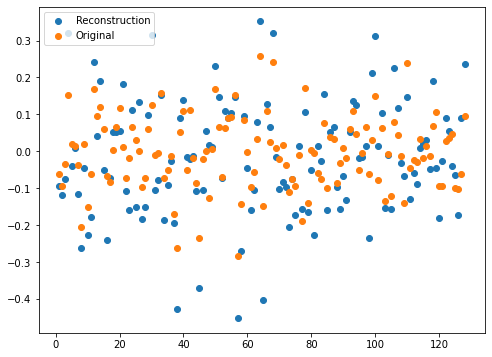

In [43]:
plt.scatter(x_axis, validate[0,:])
plt.scatter(x_axis, validate_decoder[0,0,:])

plt.legend(['Reconstruction','Original'],loc='upper left')

# Parametric interpolation in the latent space

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.


In [44]:
Lv2_latent.shape

(10, 64)

In [45]:
interp_latent = (Lv2_latent[interp1,:]+Lv2_latent[interp2,:])/2 #parameteric interpolation
interp_latent = interp_latent.reshape(1, -1)

interp_latent.shape

(1, 64)

In [46]:
interp_Lv1_latent, _ = Decoder(interp_latent, training=False)

interp_Lv1_latent.shape

TensorShape([1, 200, 128])

In [47]:
# Unscale

In [48]:
interp_Lv1_latent = interp_Lv1_latent*AT/2+mean

In [49]:
print(interp_Lv1_latent[0,0,0], f[0,0,0])

tf.Tensor(15.37784, shape=(), dtype=float32) 0.015722055062900028


In [50]:
filename4 = 'interpolated_latentcode'

np.savetxt(filename4, interp_Lv1_latent[0,:,:], fmt = '%f')

In [51]:
pause;

NameError: name 'pause' is not defined